# Predict Blood Donations

https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/

In [249]:
import pandas as pd
import numpy as np

# Jupyter Specific
%matplotlib inline
from IPython.display import display

# Import plotly and enable offline mode
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

# Machine Learning Library 
from theano.sandbox import cuda
import theano
import keras
# from keras import backend as K
# from keras.utils.data_utils import get_file
# from keras.utils import np_utils
# from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
# from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
# from keras.utils.layer_utils import layer_from_config
# from keras.metrics import categorical_crossentropy, categorical_accuracy
# from keras.layers.convolutional import *
# from keras.preprocessing import image, sequence
# from keras.preprocessing.text import Tokenizer

# Grab Data

In [1418]:
dataDir = './data/BloodDonations/'
%mkdir -p $dataDir

dataDefintions = [
    ('trainingData.csv', 'https://s3.amazonaws.com/drivendata/data/2/public/9db113a1-cdbe-4b1c-98c2-11590f124dd8.csv'),
    ('testData.csv', 'https://s3.amazonaws.com/drivendata/data/2/public/5c9fa979-5a84-45d6-93b9-543d1a0efc41.csv'),
    #('sampleSubmission', 'https://s3.amazonaws.com/drivendata/data/2/public/BloodDonationSubmissionFormat.csv')
]

def getFromCSV(filename, url, cacheDir = ''):
    '''Download and cache CSV file
    Params:
        dataDef: tuple of filename and url 
    '''    
    import os
    cachePath = cacheDir + filename
    if not os.path.isfile(cachePath):
        import requests
        r = requests.get(url)
        with open(cachePath, "wb") as f:
            f.write(r.content)
        print('Downloaded {} from {}'.format(filename, url))
    else:
        print('Loaded {} from cache'.format(filename))
     
    return pd.read_csv(cachePath)

#for filename, url in dataDefintions:
#    df = getCSV(filename, url, dataDir)
trainingData = getFromCSV(dataDefintions[0][0], dataDefintions[0][1], dataDir)
testData = getFromCSV(dataDefintions[1][0], dataDefintions[1][1], dataDir)
len(trainingData)

Loaded trainingData.csv from cache
Loaded testData.csv from cache


576

In [1402]:
len(testData)

200

In [89]:
trainingData.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


# Exploring Training Data

Use information about each donor's history
 * Months since Last Donation: this is the number of monthis since this donor's most recent donation.
 * Number of Donations: this is the total number of donations that the donor has made.
 * Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.
 * Months since First Donation: this is the number of months since the donor's first donation.

In [52]:
trainingData.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


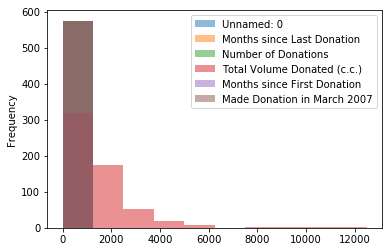

In [54]:
trainingData.plot.hist(alpha=0.5)

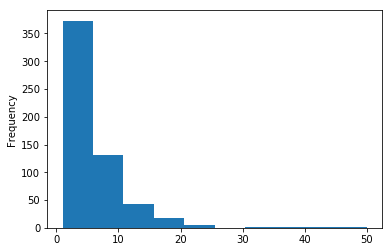

In [49]:
trainingData['Number of Donations'].plot.hist()

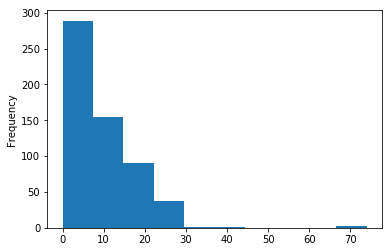

In [51]:
trainingData['Months since Last Donation'].plot.hist()

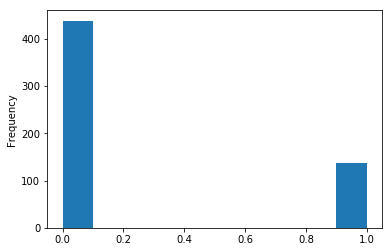

In [56]:
trainingData['Made Donation in March 2007'].plot.hist()

We have a lot more examples of people who didn't donate to people who donated.

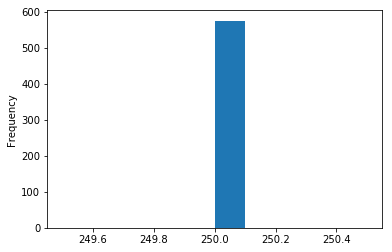

In [60]:
(trainingData['Total Volume Donated (c.c.)'] / trainingData['Number of Donations']).plot.hist()

Everyone donates 250cc per donation!, So it isn't an instresting variable. 

In [75]:
def scatterPlot(xLabel, yLabel):    
    trace = go.Scatter(
        x=trainingData[xLabel], 
        y=trainingData[yLabel], 
        mode='markers',
        marker=dict(
            size='8',
            color = trainingData['Made Donation in March 2007'], #set color equal to a variable
            colorscale='RdBu',
            showscale=True
        ),
        )

    layout= go.Layout(
        title= 'Blood Donations',
        hovermode= 'closest',
        xaxis= dict(
            title= xLabel,
            zeroline= False,
        ),
        yaxis=dict(
            title= yLabel,
        ),
        showlegend=False
    )
    fig= go.Figure(data=[trace], layout=layout)
    py.iplot(fig)

In [78]:
scatterPlot('Number of Donations', 'Months since Last Donation')

Seems like months since last donation is a better indication than number of donations

In [77]:
scatterPlot('Months since First Donation', 'Months since Last Donation')

In [81]:
scatterPlot('Number of Donations', 'Months since First Donation')

# Setup Data for Model

In [2537]:
def createValidation(data, prop = 0.8):
    msk = np.random.rand(len(data)) < prop
    trn = data[msk]
    val = data[~msk]
    return (trn, val)

def createModelData(data):
    
    #Grab target label if it exists
    if 'Made Donation in March 2007' in data.columns:
        out = data['Made Donation in March 2007'].as_matrix()
        inp = data.drop(['Unnamed: 0','Total Volume Donated (c.c.)', 'Made Donation in March 2007'],axis=1).as_matrix()
    else:
        out = None
        inp = data.drop(['Unnamed: 0', 'Total Volume Donated (c.c.)'],axis=1).as_matrix()
    
    return (inp, out)

def setupData(trainingData, testData):    
    training, valid = createValidation(trainingData)
    
    trn.x, trn.y = createModelData(training)
    val.x, val.y = createModelData(valid)
    test, _ = createModelData(testData)
    return (trn, val, test)
(trn, val, test) = setupData(trainingData, testData)
display(trn.x, trn.y)
# display(val.x, val.y)
trn.x.shape


array([[ 0, 13, 28],
       [ 1, 16, 35],
       [ 1, 24, 77],
       ..., 
       [16,  3, 86],
       [21,  2, 52],
       [72,  1, 72]])

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0,

(474, 3)

# Linear Model

In [250]:
linearModel = Sequential([
        BatchNormalization(input_shape=(3,)),
        Dense(1),
        Activation('sigmoid')
        ])

linearModel.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [1897]:
def trainModel(model):
    model.fit(trn.x, trn.y, batch_size=64, nb_epoch=10, validation_data=(val.x, val.y))
# Perform 1 iteration at low lr
linearModel.optimizer.lr = 0.01
trainModel(linearModel)

Train on 448 samples, validate on 128 samples
Epoch 1/10
448/448 [==============================] - 0s - loss: 0.5138 - acc: 0.7545 - val_loss: 0.4858 - val_acc: 0.7812
Epoch 2/10
448/448 [==============================] - 0s - loss: 0.5187 - acc: 0.7522 - val_loss: 0.4850 - val_acc: 0.7969
Epoch 3/10
448/448 [==============================] - 0s - loss: 0.5145 - acc: 0.7433 - val_loss: 0.4844 - val_acc: 0.7969
Epoch 4/10
448/448 [==============================] - 0s - loss: 0.5109 - acc: 0.7478 - val_loss: 0.4861 - val_acc: 0.7812
Epoch 5/10
448/448 [==============================] - 0s - loss: 0.5215 - acc: 0.7388 - val_loss: 0.4854 - val_acc: 0.8047
Epoch 6/10
448/448 [==============================] - 0s - loss: 0.5164 - acc: 0.7478 - val_loss: 0.4858 - val_acc: 0.8047
Epoch 7/10
448/448 [==============================] - 0s - loss: 0.5161 - acc: 0.7567 - val_loss: 0.4865 - val_acc: 0.8047
Epoch 8/10
448/448 [==============================] - 0s - loss: 0.5179 - acc: 0.7545 - val_l

,Made Donation in March 2007
659,0.5
276,0.5
263,0.5
303,0.5
83,0.5
500,0.5
530,0.5
244,0.5

In [1398]:
def createSubmission(model):
    pred = np.squeeze(model.predict(test))
    ids = testData['Unnamed: 0'].as_matrix()
    return np.stack([ids, pred], axis=1)

def outputSubmission(filename, subm):
    np.savetxt(filename, subm, fmt='%d,%.5f', header=',Made Donation in March 2007', comments='')

submissionFile = dataDir + 'submissionLinear.csv'
outputSubmission(submissionFile, createSubmission(linearModel) )
# subm = createSubmission(linearModel)
# np.savetxt(submissionFile, subm, fmt='%d,%.5f', header=',Made Donation in March 2007', comments='')

top: failed tty get


### DriveData Evaluation

DriveData uses binary log loss defined as:

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(h_i) + (1 - y_i) \log(1 - h_i)\right]$$
- $n$ is the number of samples in the test set
- $h_i$  is the predicted label
- $y_i$ is the true label
- $log()$ is the natural (base e) logarithm

As shown in the plot below, there is a "infinte" penality for predicting the wrong label with high confidence, i.e. predicting 0 when it should be 1. A trick to improve kaggle score is to clip the confident predictions.

The clipping amount is random 

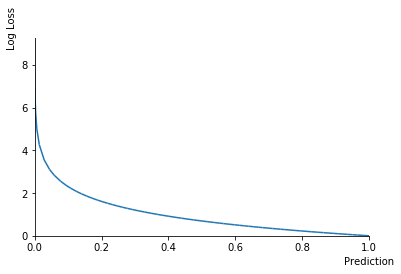

In [293]:
# Lets plot the log loss for the case that the image is a dog, i.e. y_i = 1
from sympy import symbols, log
from sympy import plot
import math

h, y = symbols('h y')
logloss = - ( y*log(h) + (1-y)*log(1-h) )

plot(logloss.subs(y,1), (h, 0, 1), xlabel='Prediction', ylabel='Log Loss');

In [297]:
#If we guess 0.5 throughout the loss would be:
logloss.subs([(y,1), (h, 0.5)])

0.693147180559945

In [313]:
def logLoss(y, h):
    l = -np.sum(y*np.log(h) + (1-y)*np.log(1-h)) / len(h)
    return l

logLoss(val.y, np.squeeze(linearModel.predict(val.x)))

0.42102138815494644

# Simple Neural Network

Exploring various network architectures

| Model | Val Accuracy |
|------ |------|
|20, 20 | 0.8151|
|10     | 0.8151|
|32     | 0.8319|
|32,32  | 0.8103|
|100    | 0.7847|
|3      | 0.7414|

Tried adding total volume of donation, but as expected no improvement

Overall network architecture doesn't seem to have an impact. So lets keep it simple.

With feature engineering, a large network seems to work a litte bitter, can be trained easier.


In [2494]:
NNModel = Sequential([
        BatchNormalization(input_shape=(3,)),
        Dense(100),
        Activation('relu'),
        Dense(30),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
        ])

epochs = 300
learning_rate = 0.01
decay_rate = learning_rate / epochs

NNModel.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])


In [2495]:
NNModel.fit(trn.x, trn.y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 

Train on 452 samples, validate on 124 samples
Epoch 1/300
452/452 [==============================] - 0s - loss: 0.7064 - acc: 0.4071 - val_loss: 0.6253 - val_acc: 0.7177
Epoch 2/300
452/452 [==============================] - 0s - loss: 0.6814 - acc: 0.6106 - val_loss: 0.5638 - val_acc: 0.7419
Epoch 3/300
452/452 [==============================] - 0s - loss: 0.6597 - acc: 0.6704 - val_loss: 0.5711 - val_acc: 0.7419
Epoch 4/300
452/452 [==============================] - 0s - loss: 0.6408 - acc: 0.7633 - val_loss: 0.5898 - val_acc: 0.7419
Epoch 5/300
452/452 [==============================] - 0s - loss: 0.6218 - acc: 0.7965 - val_loss: 0.6066 - val_acc: 0.7419
Epoch 6/300
452/452 [==============================] - 0s - loss: 0.6046 - acc: 0.7788 - val_loss: 0.6217 - val_acc: 0.7419
Epoch 7/300
452/452 [==============================] - 0s - loss: 0.5906 - acc: 0.7677 - val_loss: 0.6327 - val_acc: 0.7419
Epoch 8/300
452/452 [==============================] - 0s - loss: 0.5767 - acc: 0.7677

452/452 [==============================] - 0s - loss: 0.4575 - acc: 0.7987 - val_loss: 0.4963 - val_acc: 0.7661
Epoch 67/300
452/452 [==============================] - ETA: 0s - loss: 0.5140 - acc: 0.769 - 0s - loss: 0.4578 - acc: 0.7987 - val_loss: 0.4956 - val_acc: 0.7661
Epoch 68/300
452/452 [==============================] - 0s - loss: 0.4570 - acc: 0.8075 - val_loss: 0.4955 - val_acc: 0.7661
Epoch 69/300
452/452 [==============================] - 0s - loss: 0.4606 - acc: 0.7965 - val_loss: 0.4949 - val_acc: 0.7661
Epoch 70/300
452/452 [==============================] - 0s - loss: 0.4572 - acc: 0.8031 - val_loss: 0.4941 - val_acc: 0.7661
Epoch 71/300
452/452 [==============================] - 0s - loss: 0.4567 - acc: 0.8053 - val_loss: 0.4935 - val_acc: 0.7661
Epoch 72/300
452/452 [==============================] - 0s - loss: 0.4536 - acc: 0.8031 - val_loss: 0.4928 - val_acc: 0.7742
Epoch 73/300
452/452 [==============================] - 0s - loss: 0.4541 - acc: 0.8053 - val_loss: 

452/452 [==============================] - 0s - loss: 0.4459 - acc: 0.8075 - val_loss: 0.4815 - val_acc: 0.7742
Epoch 131/300
452/452 [==============================] - 0s - loss: 0.4468 - acc: 0.8119 - val_loss: 0.4816 - val_acc: 0.7742
Epoch 132/300
452/452 [==============================] - 0s - loss: 0.4445 - acc: 0.8075 - val_loss: 0.4816 - val_acc: 0.7742
Epoch 133/300
452/452 [==============================] - 0s - loss: 0.4447 - acc: 0.8164 - val_loss: 0.4817 - val_acc: 0.7742
Epoch 134/300
452/452 [==============================] - 0s - loss: 0.4484 - acc: 0.8097 - val_loss: 0.4819 - val_acc: 0.7742
Epoch 135/300
452/452 [==============================] - 0s - loss: 0.4491 - acc: 0.8097 - val_loss: 0.4822 - val_acc: 0.7742
Epoch 136/300
452/452 [==============================] - 0s - loss: 0.4455 - acc: 0.8097 - val_loss: 0.4824 - val_acc: 0.7742
Epoch 137/300
452/452 [==============================] - 0s - loss: 0.4459 - acc: 0.8075 - val_loss: 0.4823 - val_acc: 0.7742
Epoch 

452/452 [==============================] - 0s - loss: 0.4381 - acc: 0.8097 - val_loss: 0.4869 - val_acc: 0.7742
Epoch 196/300
452/452 [==============================] - 0s - loss: 0.4400 - acc: 0.8142 - val_loss: 0.4866 - val_acc: 0.7742
Epoch 197/300
452/452 [==============================] - 0s - loss: 0.4386 - acc: 0.8186 - val_loss: 0.4863 - val_acc: 0.7742
Epoch 198/300
452/452 [==============================] - 0s - loss: 0.4400 - acc: 0.8142 - val_loss: 0.4866 - val_acc: 0.7823
Epoch 199/300
452/452 [==============================] - 0s - loss: 0.4400 - acc: 0.8142 - val_loss: 0.4868 - val_acc: 0.7742
Epoch 200/300
452/452 [==============================] - 0s - loss: 0.4391 - acc: 0.8142 - val_loss: 0.4876 - val_acc: 0.7742
Epoch 201/300
452/452 [==============================] - 0s - loss: 0.4386 - acc: 0.8208 - val_loss: 0.4883 - val_acc: 0.7742
Epoch 202/300
452/452 [==============================] - 0s - loss: 0.4391 - acc: 0.8119 - val_loss: 0.4893 - val_acc: 0.7742
Epoch 

452/452 [==============================] - 0s - loss: 0.4349 - acc: 0.8186 - val_loss: 0.4961 - val_acc: 0.7742
Epoch 260/300
452/452 [==============================] - 0s - loss: 0.4337 - acc: 0.8186 - val_loss: 0.4965 - val_acc: 0.7742
Epoch 261/300
452/452 [==============================] - 0s - loss: 0.4388 - acc: 0.8186 - val_loss: 0.4967 - val_acc: 0.7742
Epoch 262/300
452/452 [==============================] - 0s - loss: 0.4325 - acc: 0.8186 - val_loss: 0.4971 - val_acc: 0.7742
Epoch 263/300
452/452 [==============================] - 0s - loss: 0.4392 - acc: 0.8164 - val_loss: 0.4965 - val_acc: 0.7742
Epoch 264/300
452/452 [==============================] - 0s - loss: 0.4347 - acc: 0.8208 - val_loss: 0.4965 - val_acc: 0.7823
Epoch 265/300
452/452 [==============================] - 0s - loss: 0.4294 - acc: 0.8230 - val_loss: 0.4965 - val_acc: 0.7823
Epoch 266/300
452/452 [==============================] - 0s - loss: 0.4422 - acc: 0.8119 - val_loss: 0.4963 - val_acc: 0.7823
Epoch 

In [2351]:
trn.x

array([[ 2, 50, 98],
       [ 0, 13, 28],
       [ 1, 16, 35],
       ..., 
       [21,  2, 52],
       [39,  1, 39],
       [72,  1, 72]])

In [1399]:
logLoss(val.y, np.squeeze(NNModel.predict(val.x)))

0.45798065248427205

In [1403]:
submissionFile = dataDir + 'submissionNN.csv'
outputSubmission(submissionFile, createSubmission(NNModel) )

# Lets try some feature engineering

## Remove Skewness in data

In [2486]:
def removeSkewness(dfCopy):
    df = dfCopy.copy() #Simulate call by value
    df['Months since First Donation'] = np.log(df['Months since First Donation']+0.00001)
    df['Months since Last Donation'] = np.log(df['Months since Last Donation']+0.00001)
#     df['Number of Donations'] = np.log(df['Number of Donations']+0.00001)
    
    return(df)

trainingSkewness = removeSkewness(trainingData)
testSkewness = removeSkewness(testData)


(trn, val, test) = setupData(trainingSkewness, testSkewness)


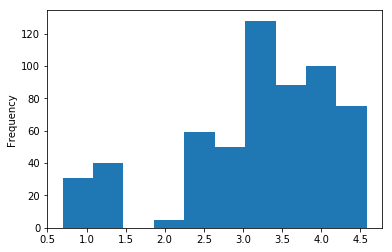

In [1650]:
trainingSkewness['Months since First Donation'].plot.hist()

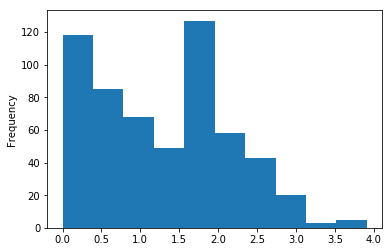

In [1479]:
trainingSkewness['Number of Donations'].plot.hist()

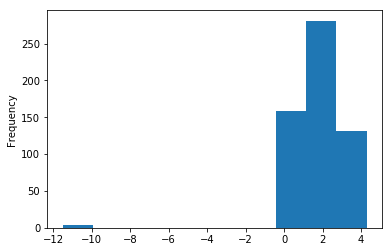

In [1480]:
trainingSkewness['Months since Last Donation'].plot.hist()

In [2487]:
NNModel.fit(trn.x, trn.y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 

Train on 464 samples, validate on 112 samples
Epoch 1/300
464/464 [==============================] - 0s - loss: 0.6973 - acc: 0.5603 - val_loss: 0.6161 - val_acc: 0.7589
Epoch 2/300
464/464 [==============================] - 0s - loss: 0.6773 - acc: 0.6552 - val_loss: 0.5894 - val_acc: 0.7500
Epoch 3/300
464/464 [==============================] - 0s - loss: 0.6608 - acc: 0.6918 - val_loss: 0.5738 - val_acc: 0.7589
Epoch 4/300
464/464 [==============================] - 0s - loss: 0.6432 - acc: 0.7241 - val_loss: 0.5645 - val_acc: 0.7679
Epoch 5/300
464/464 [==============================] - 0s - loss: 0.6291 - acc: 0.7608 - val_loss: 0.5599 - val_acc: 0.7679
Epoch 6/300
464/464 [==============================] - 0s - loss: 0.6193 - acc: 0.7565 - val_loss: 0.5597 - val_acc: 0.7679
Epoch 7/300
464/464 [==============================] - 0s - loss: 0.6096 - acc: 0.7586 - val_loss: 0.5627 - val_acc: 0.7679
Epoch 8/300
464/464 [==============================] - 0s - loss: 0.5968 - acc: 0.7586

464/464 [==============================] - 0s - loss: 0.4602 - acc: 0.7866 - val_loss: 0.5938 - val_acc: 0.7589
Epoch 66/300
464/464 [==============================] - 0s - loss: 0.4579 - acc: 0.7888 - val_loss: 0.5906 - val_acc: 0.7589
Epoch 67/300
464/464 [==============================] - 0s - loss: 0.4571 - acc: 0.7888 - val_loss: 0.5877 - val_acc: 0.7589
Epoch 68/300
464/464 [==============================] - 0s - loss: 0.4576 - acc: 0.7866 - val_loss: 0.5856 - val_acc: 0.7589
Epoch 69/300
464/464 [==============================] - 0s - loss: 0.4559 - acc: 0.7953 - val_loss: 0.5833 - val_acc: 0.7589
Epoch 70/300
464/464 [==============================] - 0s - loss: 0.4576 - acc: 0.7909 - val_loss: 0.5813 - val_acc: 0.7589
Epoch 71/300
464/464 [==============================] - 0s - loss: 0.4677 - acc: 0.7845 - val_loss: 0.5801 - val_acc: 0.7589
Epoch 72/300
464/464 [==============================] - 0s - loss: 0.4580 - acc: 0.7996 - val_loss: 0.5787 - val_acc: 0.7679
Epoch 73/300


464/464 [==============================] - 0s - loss: 0.4485 - acc: 0.8125 - val_loss: 0.5182 - val_acc: 0.7857
Epoch 131/300
464/464 [==============================] - 0s - loss: 0.4517 - acc: 0.8125 - val_loss: 0.5176 - val_acc: 0.7857
Epoch 132/300
464/464 [==============================] - 0s - loss: 0.4463 - acc: 0.8103 - val_loss: 0.5178 - val_acc: 0.7857
Epoch 133/300
464/464 [==============================] - 0s - loss: 0.4441 - acc: 0.8017 - val_loss: 0.5176 - val_acc: 0.7857
Epoch 134/300
464/464 [==============================] - 0s - loss: 0.4490 - acc: 0.7996 - val_loss: 0.5162 - val_acc: 0.7857
Epoch 135/300
464/464 [==============================] - 0s - loss: 0.4451 - acc: 0.8103 - val_loss: 0.5148 - val_acc: 0.7857
Epoch 136/300
464/464 [==============================] - 0s - loss: 0.4498 - acc: 0.8103 - val_loss: 0.5144 - val_acc: 0.7857
Epoch 137/300
464/464 [==============================] - 0s - loss: 0.4485 - acc: 0.8082 - val_loss: 0.5132 - val_acc: 0.7857
Epoch 

464/464 [==============================] - 0s - loss: 0.4415 - acc: 0.8060 - val_loss: 0.5028 - val_acc: 0.8125
Epoch 195/300
464/464 [==============================] - 0s - loss: 0.4396 - acc: 0.8125 - val_loss: 0.5046 - val_acc: 0.8125
Epoch 196/300
464/464 [==============================] - 0s - loss: 0.4411 - acc: 0.8103 - val_loss: 0.5054 - val_acc: 0.8125
Epoch 197/300
464/464 [==============================] - 0s - loss: 0.4390 - acc: 0.8168 - val_loss: 0.5048 - val_acc: 0.8125
Epoch 198/300
464/464 [==============================] - 0s - loss: 0.4519 - acc: 0.8103 - val_loss: 0.5058 - val_acc: 0.8125
Epoch 199/300
464/464 [==============================] - 0s - loss: 0.4465 - acc: 0.7996 - val_loss: 0.5045 - val_acc: 0.8125
Epoch 200/300
464/464 [==============================] - 0s - loss: 0.4475 - acc: 0.7974 - val_loss: 0.5042 - val_acc: 0.8036
Epoch 201/300
464/464 [==============================] - 0s - loss: 0.4401 - acc: 0.8060 - val_loss: 0.5039 - val_acc: 0.8036
Epoch 

464/464 [==============================] - 0s - loss: 0.4315 - acc: 0.8125 - val_loss: 0.5031 - val_acc: 0.8125
Epoch 259/300
464/464 [==============================] - 0s - loss: 0.4316 - acc: 0.8125 - val_loss: 0.5043 - val_acc: 0.8125
Epoch 260/300
464/464 [==============================] - 0s - loss: 0.4352 - acc: 0.8168 - val_loss: 0.5051 - val_acc: 0.8125
Epoch 261/300
464/464 [==============================] - 0s - loss: 0.4403 - acc: 0.8125 - val_loss: 0.5051 - val_acc: 0.8125
Epoch 262/300
464/464 [==============================] - 0s - loss: 0.4354 - acc: 0.8103 - val_loss: 0.5050 - val_acc: 0.8125
Epoch 263/300
464/464 [==============================] - 0s - loss: 0.4367 - acc: 0.8017 - val_loss: 0.5054 - val_acc: 0.8125
Epoch 264/300
464/464 [==============================] - 0s - loss: 0.4356 - acc: 0.8147 - val_loss: 0.5055 - val_acc: 0.8125
Epoch 265/300
464/464 [==============================] - 0s - loss: 0.4350 - acc: 0.8168 - val_loss: 0.5061 - val_acc: 0.8125
Epoch 

In [2476]:
trn.x

array([[ -1.15129255e+01,   1.30000000e+01,   3.33220487e+00],
       [  9.99995000e-06,   1.60000000e+01,   3.55534835e+00],
       [  9.99995000e-06,   2.40000000e+01,   4.34380555e+00],
       ..., 
       [  3.13549465e+00,   1.00000000e+00,   3.13549465e+00],
       [  3.13549465e+00,   1.00000000e+00,   3.13549465e+00],
       [  3.04452291e+00,   2.00000000e+00,   3.95124391e+00]])

Okay so we are seeing an improvement of about 2-3% by unskewing the data! It did not work well to log the number of donations

## Feature Engineering

In [2505]:
def featureEngineering(dfCopy):
    df = dfCopy.copy() #Simulate call by value
#     del df['Unnamed: 0']
#     del df['Total Volume Donated (c.c.)']
    df['Active Donation Months'] = (df['Months since First Donation'] - df['Months since Last Donation'])
    df['Average Months Between Donations'] = df['Active Donation Months'] / df['Number of Donations']
    df['Last Donation over First Donation'] = df['Months since Last Donation'] / df['Months since First Donation']
    df['Long Very Time Recent Donor'] = np.logical_and(df['Months since Last Donation'] < np.log(3), df['Months since First Donation'] > np.log(24))
    df['Long Time Recent Donor'] = np.logical_and(df['Months since Last Donation'] < np.log(6), df['Months since First Donation'] > np.log(24))
    df['Recent Donor'] = df['Months since Last Donation'] < np.log(3)
    df['Very Recent Donor'] = df['Months since Last Donation'] < np.log(6)
    df['Quitted'] = np.logical_and(df['Months since Last Donation'] > np.log(12), df['Number of Donations'] < 3)

    return(df)

trainingFeatured = featureEngineering(trainingSkewness)
testFeatured = featureEngineering(testSkewness)

(trn, val, test) = setupData(trainingFeatured, testFeatured)

display(trn.x, trn.y)
trainingFeatured.tail()
display(trn.x.shape)

array([[0.6931521805474454, 50, 4.584967580711383, ..., True, True, False],
       [-11.512925464970229, 13, 3.3322048673179974, ..., True, True, False],
       [9.999950000398841e-06, 16, 3.5553483472036587, ..., True, True,
        False],
       ..., 
       [3.1354946507116637, 1, 3.1354946507116637, ..., False, False, True],
       [3.66356190253987, 1, 3.66356190253987, ..., False, False, True],
       [4.276666257904934, 1, 4.276666257904934, ..., False, False, True]], dtype=object)

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0,

(472, 11)

In [2506]:
featuredNNModel = Sequential([
        BatchNormalization(input_shape=(11,)),
        Dense(100),
        Activation('relu'),
        Dense(30),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
        ])

featuredNNModel.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])
featuredNNModel.fit(trn.x, trn.y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 
    

Train on 472 samples, validate on 104 samples
Epoch 1/300
472/472 [==============================] - 0s - loss: 0.6615 - acc: 0.7267 - val_loss: 0.5886 - val_acc: 0.8365
Epoch 2/300
472/472 [==============================] - 0s - loss: 0.6330 - acc: 0.7436 - val_loss: 0.5631 - val_acc: 0.8365
Epoch 3/300
472/472 [==============================] - 0s - loss: 0.6019 - acc: 0.7436 - val_loss: 0.5409 - val_acc: 0.8365
Epoch 4/300
472/472 [==============================] - 0s - loss: 0.5845 - acc: 0.7436 - val_loss: 0.5204 - val_acc: 0.8365
Epoch 5/300
472/472 [==============================] - 0s - loss: 0.5621 - acc: 0.7500 - val_loss: 0.5001 - val_acc: 0.8365
Epoch 6/300
472/472 [==============================] - 0s - loss: 0.5507 - acc: 0.7754 - val_loss: 0.4807 - val_acc: 0.8365
Epoch 7/300
472/472 [==============================] - 0s - loss: 0.5369 - acc: 0.7669 - val_loss: 0.4634 - val_acc: 0.8365
Epoch 8/300
472/472 [==============================] - 0s - loss: 0.5254 - acc: 0.7585

472/472 [==============================] - 0s - loss: 0.4692 - acc: 0.8030 - val_loss: 0.3996 - val_acc: 0.8269
Epoch 67/300
472/472 [==============================] - 0s - loss: 0.4663 - acc: 0.7945 - val_loss: 0.3990 - val_acc: 0.8269
Epoch 68/300
472/472 [==============================] - 0s - loss: 0.4647 - acc: 0.7945 - val_loss: 0.3984 - val_acc: 0.8269
Epoch 69/300
472/472 [==============================] - 0s - loss: 0.4640 - acc: 0.8051 - val_loss: 0.3977 - val_acc: 0.8269
Epoch 70/300
472/472 [==============================] - 0s - loss: 0.4639 - acc: 0.8051 - val_loss: 0.3970 - val_acc: 0.8269
Epoch 71/300
472/472 [==============================] - 0s - loss: 0.4690 - acc: 0.8051 - val_loss: 0.3963 - val_acc: 0.8269
Epoch 72/300
472/472 [==============================] - 0s - loss: 0.4642 - acc: 0.8008 - val_loss: 0.3959 - val_acc: 0.8269
Epoch 73/300
472/472 [==============================] - 0s - loss: 0.4680 - acc: 0.7924 - val_loss: 0.3965 - val_acc: 0.8269
Epoch 74/300


472/472 [==============================] - 0s - loss: 0.4519 - acc: 0.8051 - val_loss: 0.3863 - val_acc: 0.8365
Epoch 132/300
472/472 [==============================] - 0s - loss: 0.4610 - acc: 0.8008 - val_loss: 0.3871 - val_acc: 0.8365
Epoch 133/300
472/472 [==============================] - 0s - loss: 0.4537 - acc: 0.8008 - val_loss: 0.3870 - val_acc: 0.8365
Epoch 134/300
472/472 [==============================] - 0s - loss: 0.4468 - acc: 0.8114 - val_loss: 0.3873 - val_acc: 0.8365
Epoch 135/300
472/472 [==============================] - 0s - loss: 0.4540 - acc: 0.8051 - val_loss: 0.3868 - val_acc: 0.8365
Epoch 136/300
472/472 [==============================] - 0s - loss: 0.4544 - acc: 0.8093 - val_loss: 0.3860 - val_acc: 0.8365
Epoch 137/300
472/472 [==============================] - 0s - loss: 0.4500 - acc: 0.8093 - val_loss: 0.3848 - val_acc: 0.8365
Epoch 138/300
472/472 [==============================] - 0s - loss: 0.4639 - acc: 0.8093 - val_loss: 0.3838 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4472 - acc: 0.8072 - val_loss: 0.3881 - val_acc: 0.8558
Epoch 197/300
472/472 [==============================] - 0s - loss: 0.4479 - acc: 0.7987 - val_loss: 0.3879 - val_acc: 0.8558
Epoch 198/300
472/472 [==============================] - 0s - loss: 0.4423 - acc: 0.8051 - val_loss: 0.3880 - val_acc: 0.8558
Epoch 199/300
472/472 [==============================] - 0s - loss: 0.4424 - acc: 0.8093 - val_loss: 0.3887 - val_acc: 0.8558
Epoch 200/300
472/472 [==============================] - 0s - loss: 0.4438 - acc: 0.8136 - val_loss: 0.3893 - val_acc: 0.8558
Epoch 201/300
472/472 [==============================] - 0s - loss: 0.4449 - acc: 0.8093 - val_loss: 0.3895 - val_acc: 0.8558
Epoch 202/300
472/472 [==============================] - 0s - loss: 0.4420 - acc: 0.8093 - val_loss: 0.3899 - val_acc: 0.8558
Epoch 203/300
472/472 [==============================] - 0s - loss: 0.4429 - acc: 0.8136 - val_loss: 0.3897 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4314 - acc: 0.8093 - val_loss: 0.3966 - val_acc: 0.8558
Epoch 261/300
472/472 [==============================] - 0s - loss: 0.4358 - acc: 0.8178 - val_loss: 0.3972 - val_acc: 0.8654
Epoch 262/300
472/472 [==============================] - 0s - loss: 0.4478 - acc: 0.8051 - val_loss: 0.3971 - val_acc: 0.8558
Epoch 263/300
472/472 [==============================] - 0s - loss: 0.4315 - acc: 0.8093 - val_loss: 0.3973 - val_acc: 0.8654
Epoch 264/300
472/472 [==============================] - 0s - loss: 0.4316 - acc: 0.8136 - val_loss: 0.3975 - val_acc: 0.8654
Epoch 265/300
472/472 [==============================] - 0s - loss: 0.4368 - acc: 0.8093 - val_loss: 0.3977 - val_acc: 0.8654
Epoch 266/300
472/472 [==============================] - 0s - loss: 0.4304 - acc: 0.8114 - val_loss: 0.3979 - val_acc: 0.8558
Epoch 267/300
472/472 [==============================] - 0s - loss: 0.4343 - acc: 0.8114 - val_loss: 0.3966 - val_acc: 0.8654
Epoch 

Feature engineering does not seem to do any harm! Perhaps some few percentages

# Lets Create an ensamble model

In [2508]:
def ensambleModel():
    model =  Sequential([
        BatchNormalization(input_shape=(11,)),
        Dense(100),
        Activation('relu'),
        Dense(30),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
        ])
    model.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(trn.x, trn.y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 
    return model 


models = [ensambleModel() for i in range(10)]

Train on 472 samples, validate on 104 samples
Epoch 1/300
472/472 [==============================] - 0s - loss: 0.7804 - acc: 0.4703 - val_loss: 0.5783 - val_acc: 0.8269
Epoch 2/300
472/472 [==============================] - 0s - loss: 0.7205 - acc: 0.5233 - val_loss: 0.5357 - val_acc: 0.8365
Epoch 3/300
472/472 [==============================] - 0s - loss: 0.6874 - acc: 0.5318 - val_loss: 0.5132 - val_acc: 0.8365
Epoch 4/300
472/472 [==============================] - 0s - loss: 0.6423 - acc: 0.6483 - val_loss: 0.5006 - val_acc: 0.8365
Epoch 5/300
472/472 [==============================] - 0s - loss: 0.6142 - acc: 0.7458 - val_loss: 0.4905 - val_acc: 0.8365
Epoch 6/300
472/472 [==============================] - 0s - loss: 0.5924 - acc: 0.7436 - val_loss: 0.4810 - val_acc: 0.8365
Epoch 7/300
472/472 [==============================] - 0s - loss: 0.5752 - acc: 0.7436 - val_loss: 0.4720 - val_acc: 0.8365
Epoch 8/300
472/472 [==============================] - 0s - loss: 0.5599 - acc: 0.7436

472/472 [==============================] - 0s - loss: 0.4690 - acc: 0.7903 - val_loss: 0.3891 - val_acc: 0.8365
Epoch 67/300
472/472 [==============================] - 0s - loss: 0.4783 - acc: 0.7903 - val_loss: 0.3890 - val_acc: 0.8365
Epoch 68/300
472/472 [==============================] - 0s - loss: 0.4706 - acc: 0.7987 - val_loss: 0.3885 - val_acc: 0.8365
Epoch 69/300
472/472 [==============================] - 0s - loss: 0.4660 - acc: 0.7924 - val_loss: 0.3884 - val_acc: 0.8365
Epoch 70/300
472/472 [==============================] - 0s - loss: 0.4726 - acc: 0.7924 - val_loss: 0.3882 - val_acc: 0.8365
Epoch 71/300
472/472 [==============================] - 0s - loss: 0.4675 - acc: 0.7903 - val_loss: 0.3879 - val_acc: 0.8365
Epoch 72/300
472/472 [==============================] - 0s - loss: 0.4711 - acc: 0.7924 - val_loss: 0.3875 - val_acc: 0.8365
Epoch 73/300
472/472 [==============================] - 0s - loss: 0.4669 - acc: 0.8008 - val_loss: 0.3869 - val_acc: 0.8365
Epoch 74/300


472/472 [==============================] - 0s - loss: 0.4524 - acc: 0.8093 - val_loss: 0.3828 - val_acc: 0.8654
Epoch 131/300
472/472 [==============================] - 0s - loss: 0.4532 - acc: 0.8093 - val_loss: 0.3831 - val_acc: 0.8654
Epoch 132/300
472/472 [==============================] - 0s - loss: 0.4569 - acc: 0.8093 - val_loss: 0.3831 - val_acc: 0.8654
Epoch 133/300
472/472 [==============================] - 0s - loss: 0.4546 - acc: 0.8008 - val_loss: 0.3829 - val_acc: 0.8654
Epoch 134/300
472/472 [==============================] - 0s - loss: 0.4518 - acc: 0.8136 - val_loss: 0.3821 - val_acc: 0.8558
Epoch 135/300
472/472 [==============================] - 0s - loss: 0.4566 - acc: 0.7945 - val_loss: 0.3814 - val_acc: 0.8462
Epoch 136/300
472/472 [==============================] - ETA: 0s - loss: 0.4694 - acc: 0.804 - 0s - loss: 0.4509 - acc: 0.8136 - val_loss: 0.3810 - val_acc: 0.8558
Epoch 137/300
472/472 [==============================] - 0s - loss: 0.4514 - acc: 0.8178 - val

472/472 [==============================] - 0s - loss: 0.4437 - acc: 0.8072 - val_loss: 0.3882 - val_acc: 0.8558
Epoch 195/300
472/472 [==============================] - 0s - loss: 0.4385 - acc: 0.8114 - val_loss: 0.3873 - val_acc: 0.8558
Epoch 196/300
472/472 [==============================] - 0s - loss: 0.4483 - acc: 0.8157 - val_loss: 0.3866 - val_acc: 0.8558
Epoch 197/300
472/472 [==============================] - 0s - loss: 0.4414 - acc: 0.8072 - val_loss: 0.3871 - val_acc: 0.8558
Epoch 198/300
472/472 [==============================] - 0s - loss: 0.4404 - acc: 0.8114 - val_loss: 0.3878 - val_acc: 0.8558
Epoch 199/300
472/472 [==============================] - 0s - loss: 0.4408 - acc: 0.8136 - val_loss: 0.3880 - val_acc: 0.8462
Epoch 200/300
472/472 [==============================] - 0s - loss: 0.4459 - acc: 0.8093 - val_loss: 0.3888 - val_acc: 0.8558
Epoch 201/300
472/472 [==============================] - 0s - loss: 0.4386 - acc: 0.8072 - val_loss: 0.3881 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4412 - acc: 0.8072 - val_loss: 0.3980 - val_acc: 0.8654
Epoch 259/300
472/472 [==============================] - 0s - loss: 0.4416 - acc: 0.8093 - val_loss: 0.3978 - val_acc: 0.8654
Epoch 260/300
472/472 [==============================] - 0s - loss: 0.4335 - acc: 0.8093 - val_loss: 0.3955 - val_acc: 0.8654
Epoch 261/300
472/472 [==============================] - 0s - loss: 0.4334 - acc: 0.8030 - val_loss: 0.3933 - val_acc: 0.8654
Epoch 262/300
472/472 [==============================] - 0s - loss: 0.4499 - acc: 0.7945 - val_loss: 0.3938 - val_acc: 0.8654
Epoch 263/300
472/472 [==============================] - 0s - loss: 0.4359 - acc: 0.8093 - val_loss: 0.3928 - val_acc: 0.8654
Epoch 264/300
472/472 [==============================] - 0s - loss: 0.4431 - acc: 0.8093 - val_loss: 0.3911 - val_acc: 0.8654
Epoch 265/300
472/472 [==============================] - 0s - loss: 0.4341 - acc: 0.8114 - val_loss: 0.3917 - val_acc: 0.8654
Epoch 

472/472 [==============================] - 0s - loss: 0.4900 - acc: 0.7648 - val_loss: 0.4114 - val_acc: 0.8365
Epoch 24/300
472/472 [==============================] - 0s - loss: 0.4911 - acc: 0.7585 - val_loss: 0.4105 - val_acc: 0.8365
Epoch 25/300
472/472 [==============================] - 0s - loss: 0.4904 - acc: 0.7627 - val_loss: 0.4100 - val_acc: 0.8365
Epoch 26/300
472/472 [==============================] - 0s - loss: 0.4889 - acc: 0.7691 - val_loss: 0.4095 - val_acc: 0.8365
Epoch 27/300
472/472 [==============================] - 0s - loss: 0.4875 - acc: 0.7712 - val_loss: 0.4091 - val_acc: 0.8365
Epoch 28/300
472/472 [==============================] - 0s - loss: 0.4857 - acc: 0.7648 - val_loss: 0.4087 - val_acc: 0.8365
Epoch 29/300
472/472 [==============================] - 0s - loss: 0.4850 - acc: 0.7712 - val_loss: 0.4083 - val_acc: 0.8365
Epoch 30/300
472/472 [==============================] - 0s - loss: 0.4871 - acc: 0.7564 - val_loss: 0.4079 - val_acc: 0.8365
Epoch 31/300


472/472 [==============================] - 0s - loss: 0.4684 - acc: 0.8051 - val_loss: 0.3857 - val_acc: 0.8558
Epoch 89/300
472/472 [==============================] - 0s - loss: 0.4682 - acc: 0.8051 - val_loss: 0.3857 - val_acc: 0.8462
Epoch 90/300
472/472 [==============================] - 0s - loss: 0.4672 - acc: 0.8072 - val_loss: 0.3860 - val_acc: 0.8462
Epoch 91/300
472/472 [==============================] - 0s - loss: 0.4694 - acc: 0.8030 - val_loss: 0.3865 - val_acc: 0.8462
Epoch 92/300
472/472 [==============================] - 0s - loss: 0.4698 - acc: 0.7987 - val_loss: 0.3872 - val_acc: 0.8462
Epoch 93/300
472/472 [==============================] - 0s - loss: 0.4635 - acc: 0.8072 - val_loss: 0.3872 - val_acc: 0.8462
Epoch 94/300
472/472 [==============================] - 0s - loss: 0.4626 - acc: 0.8051 - val_loss: 0.3872 - val_acc: 0.8462
Epoch 95/300
472/472 [==============================] - 0s - loss: 0.4639 - acc: 0.8008 - val_loss: 0.3868 - val_acc: 0.8462
Epoch 96/300


472/472 [==============================] - 0s - loss: 0.4622 - acc: 0.7987 - val_loss: 0.3833 - val_acc: 0.8654
Epoch 154/300
472/472 [==============================] - 0s - loss: 0.4506 - acc: 0.8114 - val_loss: 0.3831 - val_acc: 0.8654
Epoch 155/300
472/472 [==============================] - 0s - loss: 0.4506 - acc: 0.8093 - val_loss: 0.3835 - val_acc: 0.8654
Epoch 156/300
472/472 [==============================] - 0s - loss: 0.4567 - acc: 0.8093 - val_loss: 0.3841 - val_acc: 0.8654
Epoch 157/300
472/472 [==============================] - 0s - loss: 0.4520 - acc: 0.8114 - val_loss: 0.3839 - val_acc: 0.8654
Epoch 158/300
472/472 [==============================] - 0s - loss: 0.4528 - acc: 0.8114 - val_loss: 0.3834 - val_acc: 0.8654
Epoch 159/300
472/472 [==============================] - 0s - loss: 0.4547 - acc: 0.8114 - val_loss: 0.3831 - val_acc: 0.8654
Epoch 160/300
472/472 [==============================] - 0s - loss: 0.4520 - acc: 0.8114 - val_loss: 0.3830 - val_acc: 0.8654
Epoch 

472/472 [==============================] - 0s - loss: 0.4555 - acc: 0.7987 - val_loss: 0.3909 - val_acc: 0.8654
Epoch 218/300
472/472 [==============================] - 0s - loss: 0.4433 - acc: 0.8051 - val_loss: 0.3904 - val_acc: 0.8654
Epoch 219/300
472/472 [==============================] - 0s - loss: 0.4399 - acc: 0.8093 - val_loss: 0.3898 - val_acc: 0.8654
Epoch 220/300
472/472 [==============================] - 0s - loss: 0.4434 - acc: 0.8136 - val_loss: 0.3884 - val_acc: 0.8558
Epoch 221/300
472/472 [==============================] - 0s - loss: 0.4408 - acc: 0.8157 - val_loss: 0.3883 - val_acc: 0.8654
Epoch 222/300
472/472 [==============================] - 0s - loss: 0.4491 - acc: 0.8051 - val_loss: 0.3893 - val_acc: 0.8654
Epoch 223/300
472/472 [==============================] - 0s - loss: 0.4363 - acc: 0.8030 - val_loss: 0.3893 - val_acc: 0.8654
Epoch 224/300
472/472 [==============================] - 0s - loss: 0.4584 - acc: 0.7754 - val_loss: 0.3905 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4294 - acc: 0.8114 - val_loss: 0.3890 - val_acc: 0.8654
Epoch 282/300
472/472 [==============================] - 0s - loss: 0.4266 - acc: 0.8178 - val_loss: 0.3905 - val_acc: 0.8654
Epoch 283/300
472/472 [==============================] - 0s - loss: 0.4299 - acc: 0.8114 - val_loss: 0.3913 - val_acc: 0.8654
Epoch 284/300
472/472 [==============================] - ETA: 0s - loss: 0.4288 - acc: 0.812 - 0s - loss: 0.4307 - acc: 0.8114 - val_loss: 0.3913 - val_acc: 0.8654
Epoch 285/300
472/472 [==============================] - 0s - loss: 0.4321 - acc: 0.8114 - val_loss: 0.3904 - val_acc: 0.8654
Epoch 286/300
472/472 [==============================] - 0s - loss: 0.4258 - acc: 0.8157 - val_loss: 0.3914 - val_acc: 0.8654
Epoch 287/300
472/472 [==============================] - 0s - loss: 0.4286 - acc: 0.8072 - val_loss: 0.3925 - val_acc: 0.8654
Epoch 288/300
472/472 [==============================] - 0s - loss: 0.4335 - acc: 0.8199 - val

472/472 [==============================] - 0s - loss: 0.4787 - acc: 0.7733 - val_loss: 0.4089 - val_acc: 0.8365
Epoch 46/300
472/472 [==============================] - 0s - loss: 0.4773 - acc: 0.7839 - val_loss: 0.4085 - val_acc: 0.8365
Epoch 47/300
472/472 [==============================] - 0s - loss: 0.4770 - acc: 0.7881 - val_loss: 0.4078 - val_acc: 0.8365
Epoch 48/300
472/472 [==============================] - 0s - loss: 0.4799 - acc: 0.7754 - val_loss: 0.4071 - val_acc: 0.8365
Epoch 49/300
472/472 [==============================] - 0s - loss: 0.4765 - acc: 0.7881 - val_loss: 0.4072 - val_acc: 0.8365
Epoch 50/300
472/472 [==============================] - 0s - loss: 0.4753 - acc: 0.7860 - val_loss: 0.4071 - val_acc: 0.8365
Epoch 51/300
472/472 [==============================] - 0s - loss: 0.4784 - acc: 0.7839 - val_loss: 0.4068 - val_acc: 0.8365
Epoch 52/300
472/472 [==============================] - 0s - loss: 0.4753 - acc: 0.7839 - val_loss: 0.4068 - val_acc: 0.8365
Epoch 53/300


472/472 [==============================] - 0s - loss: 0.4622 - acc: 0.8136 - val_loss: 0.3890 - val_acc: 0.8462
Epoch 111/300
472/472 [==============================] - 0s - loss: 0.4597 - acc: 0.8114 - val_loss: 0.3890 - val_acc: 0.8462
Epoch 112/300
472/472 [==============================] - 0s - loss: 0.4532 - acc: 0.8157 - val_loss: 0.3890 - val_acc: 0.8462
Epoch 113/300
472/472 [==============================] - 0s - loss: 0.4583 - acc: 0.8072 - val_loss: 0.3890 - val_acc: 0.8462
Epoch 114/300
472/472 [==============================] - 0s - loss: 0.4545 - acc: 0.8093 - val_loss: 0.3886 - val_acc: 0.8462
Epoch 115/300
472/472 [==============================] - 0s - loss: 0.4550 - acc: 0.8114 - val_loss: 0.3882 - val_acc: 0.8462
Epoch 116/300
472/472 [==============================] - 0s - loss: 0.4577 - acc: 0.8072 - val_loss: 0.3884 - val_acc: 0.8462
Epoch 117/300
472/472 [==============================] - 0s - loss: 0.4568 - acc: 0.8114 - val_loss: 0.3890 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4461 - acc: 0.8114 - val_loss: 0.3946 - val_acc: 0.8462
Epoch 176/300
472/472 [==============================] - 0s - loss: 0.4494 - acc: 0.8136 - val_loss: 0.3958 - val_acc: 0.8462
Epoch 177/300
472/472 [==============================] - 0s - loss: 0.4413 - acc: 0.8199 - val_loss: 0.3972 - val_acc: 0.8462
Epoch 178/300
472/472 [==============================] - 0s - loss: 0.4609 - acc: 0.7987 - val_loss: 0.3997 - val_acc: 0.8462
Epoch 179/300
472/472 [==============================] - 0s - loss: 0.4411 - acc: 0.8157 - val_loss: 0.4011 - val_acc: 0.8462
Epoch 180/300
472/472 [==============================] - 0s - loss: 0.4485 - acc: 0.8072 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 181/300
472/472 [==============================] - 0s - loss: 0.4521 - acc: 0.8114 - val_loss: 0.3980 - val_acc: 0.8462
Epoch 182/300
472/472 [==============================] - ETA: 0s - loss: 0.4175 - acc: 0.832 - 0s - loss: 0.4478 - acc: 0.8178 - val

472/472 [==============================] - 0s - loss: 0.4353 - acc: 0.8157 - val_loss: 0.3969 - val_acc: 0.8462
Epoch 240/300
472/472 [==============================] - 0s - loss: 0.4336 - acc: 0.8093 - val_loss: 0.3974 - val_acc: 0.8462
Epoch 241/300
472/472 [==============================] - 0s - loss: 0.4507 - acc: 0.7903 - val_loss: 0.4000 - val_acc: 0.8462
Epoch 242/300
472/472 [==============================] - 0s - loss: 0.4530 - acc: 0.8051 - val_loss: 0.4023 - val_acc: 0.8462
Epoch 243/300
472/472 [==============================] - 0s - loss: 0.4405 - acc: 0.8136 - val_loss: 0.4019 - val_acc: 0.8462
Epoch 244/300
472/472 [==============================] - 0s - loss: 0.4366 - acc: 0.8051 - val_loss: 0.4005 - val_acc: 0.8462
Epoch 245/300
472/472 [==============================] - 0s - loss: 0.4345 - acc: 0.8008 - val_loss: 0.3978 - val_acc: 0.8462
Epoch 246/300
472/472 [==============================] - 0s - loss: 0.4362 - acc: 0.8093 - val_loss: 0.3967 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.6398 - acc: 0.6907 - val_loss: 0.6018 - val_acc: 0.8365
Epoch 4/300
472/472 [==============================] - 0s - loss: 0.6152 - acc: 0.7458 - val_loss: 0.5766 - val_acc: 0.8365
Epoch 5/300
472/472 [==============================] - 0s - loss: 0.5942 - acc: 0.7436 - val_loss: 0.5548 - val_acc: 0.8365
Epoch 6/300
472/472 [==============================] - 0s - loss: 0.5770 - acc: 0.7436 - val_loss: 0.5350 - val_acc: 0.8365
Epoch 7/300
472/472 [==============================] - 0s - loss: 0.5605 - acc: 0.7436 - val_loss: 0.5175 - val_acc: 0.8365
Epoch 8/300
472/472 [==============================] - 0s - loss: 0.5486 - acc: 0.7436 - val_loss: 0.5022 - val_acc: 0.8365
Epoch 9/300
472/472 [==============================] - 0s - loss: 0.5373 - acc: 0.7436 - val_loss: 0.4882 - val_acc: 0.8365
Epoch 10/300
472/472 [==============================] - 0s - loss: 0.5215 - acc: 0.7500 - val_loss: 0.4759 - val_acc: 0.8365
Epoch 11/300
472/47

472/472 [==============================] - 0s - loss: 0.4684 - acc: 0.7924 - val_loss: 0.3948 - val_acc: 0.8365
Epoch 69/300
472/472 [==============================] - 0s - loss: 0.4689 - acc: 0.8008 - val_loss: 0.3944 - val_acc: 0.8365
Epoch 70/300
472/472 [==============================] - 0s - loss: 0.4655 - acc: 0.7987 - val_loss: 0.3938 - val_acc: 0.8365
Epoch 71/300
472/472 [==============================] - 0s - loss: 0.4715 - acc: 0.8072 - val_loss: 0.3932 - val_acc: 0.8365
Epoch 72/300
472/472 [==============================] - 0s - loss: 0.4726 - acc: 0.7839 - val_loss: 0.3931 - val_acc: 0.8365
Epoch 73/300
472/472 [==============================] - 0s - loss: 0.4629 - acc: 0.8030 - val_loss: 0.3934 - val_acc: 0.8365
Epoch 74/300
472/472 [==============================] - 0s - loss: 0.4643 - acc: 0.8008 - val_loss: 0.3935 - val_acc: 0.8365
Epoch 75/300
472/472 [==============================] - 0s - loss: 0.4639 - acc: 0.7966 - val_loss: 0.3939 - val_acc: 0.8365
Epoch 76/300


472/472 [==============================] - 0s - loss: 0.4483 - acc: 0.8114 - val_loss: 0.3917 - val_acc: 0.8558
Epoch 134/300
472/472 [==============================] - 0s - loss: 0.4465 - acc: 0.8114 - val_loss: 0.3918 - val_acc: 0.8558
Epoch 135/300
472/472 [==============================] - 0s - loss: 0.4469 - acc: 0.8114 - val_loss: 0.3922 - val_acc: 0.8558
Epoch 136/300
472/472 [==============================] - 0s - loss: 0.4403 - acc: 0.8051 - val_loss: 0.3931 - val_acc: 0.8558
Epoch 137/300
472/472 [==============================] - 0s - loss: 0.4592 - acc: 0.8051 - val_loss: 0.3942 - val_acc: 0.8462
Epoch 138/300
472/472 [==============================] - ETA: 0s - loss: 0.4916 - acc: 0.773 - 0s - loss: 0.4505 - acc: 0.8136 - val_loss: 0.3947 - val_acc: 0.8558
Epoch 139/300
472/472 [==============================] - 0s - loss: 0.4478 - acc: 0.8008 - val_loss: 0.3944 - val_acc: 0.8558
Epoch 140/300
472/472 [==============================] - 0s - loss: 0.4520 - acc: 0.8072 - val

472/472 [==============================] - 0s - loss: 0.4347 - acc: 0.8114 - val_loss: 0.3987 - val_acc: 0.8462
Epoch 198/300
472/472 [==============================] - 0s - loss: 0.4335 - acc: 0.8157 - val_loss: 0.3987 - val_acc: 0.8558
Epoch 199/300
472/472 [==============================] - 0s - loss: 0.4326 - acc: 0.8157 - val_loss: 0.3990 - val_acc: 0.8558
Epoch 200/300
472/472 [==============================] - 0s - loss: 0.4354 - acc: 0.8199 - val_loss: 0.4007 - val_acc: 0.8558
Epoch 201/300
472/472 [==============================] - 0s - loss: 0.4322 - acc: 0.8157 - val_loss: 0.4027 - val_acc: 0.8558
Epoch 202/300
472/472 [==============================] - 0s - loss: 0.4343 - acc: 0.8157 - val_loss: 0.4025 - val_acc: 0.8558
Epoch 203/300
472/472 [==============================] - 0s - loss: 0.4348 - acc: 0.8157 - val_loss: 0.4028 - val_acc: 0.8558
Epoch 204/300
472/472 [==============================] - 0s - loss: 0.4437 - acc: 0.7987 - val_loss: 0.4029 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4297 - acc: 0.8114 - val_loss: 0.4073 - val_acc: 0.8462
Epoch 263/300
472/472 [==============================] - 0s - loss: 0.4245 - acc: 0.8136 - val_loss: 0.4089 - val_acc: 0.8462
Epoch 264/300
472/472 [==============================] - 0s - loss: 0.4210 - acc: 0.8157 - val_loss: 0.4095 - val_acc: 0.8462
Epoch 265/300
472/472 [==============================] - 0s - loss: 0.4176 - acc: 0.8178 - val_loss: 0.4108 - val_acc: 0.8462
Epoch 266/300
472/472 [==============================] - 0s - loss: 0.4318 - acc: 0.8093 - val_loss: 0.4117 - val_acc: 0.8462
Epoch 267/300
472/472 [==============================] - 0s - loss: 0.4245 - acc: 0.8136 - val_loss: 0.4133 - val_acc: 0.8365
Epoch 268/300
472/472 [==============================] - 0s - loss: 0.4293 - acc: 0.8030 - val_loss: 0.4133 - val_acc: 0.8365
Epoch 269/300
472/472 [==============================] - 0s - loss: 0.4287 - acc: 0.8093 - val_loss: 0.4138 - val_acc: 0.8365
Epoch 

472/472 [==============================] - 0s - loss: 0.4879 - acc: 0.7627 - val_loss: 0.4146 - val_acc: 0.8365
Epoch 27/300
472/472 [==============================] - 0s - loss: 0.4890 - acc: 0.7691 - val_loss: 0.4127 - val_acc: 0.8365
Epoch 28/300
472/472 [==============================] - 0s - loss: 0.4864 - acc: 0.7669 - val_loss: 0.4115 - val_acc: 0.8365
Epoch 29/300
472/472 [==============================] - 0s - loss: 0.4845 - acc: 0.7627 - val_loss: 0.4102 - val_acc: 0.8365
Epoch 30/300
472/472 [==============================] - 0s - loss: 0.4858 - acc: 0.7691 - val_loss: 0.4092 - val_acc: 0.8365
Epoch 31/300
472/472 [==============================] - 0s - loss: 0.4880 - acc: 0.7648 - val_loss: 0.4078 - val_acc: 0.8365
Epoch 32/300
472/472 [==============================] - 0s - loss: 0.4847 - acc: 0.7775 - val_loss: 0.4067 - val_acc: 0.8365
Epoch 33/300
472/472 [==============================] - 0s - loss: 0.4843 - acc: 0.7754 - val_loss: 0.4056 - val_acc: 0.8365
Epoch 34/300


472/472 [==============================] - 0s - loss: 0.4663 - acc: 0.8051 - val_loss: 0.3855 - val_acc: 0.8365
Epoch 92/300
472/472 [==============================] - 0s - loss: 0.4626 - acc: 0.7987 - val_loss: 0.3856 - val_acc: 0.8365
Epoch 93/300
472/472 [==============================] - 0s - loss: 0.4609 - acc: 0.8072 - val_loss: 0.3856 - val_acc: 0.8365
Epoch 94/300
472/472 [==============================] - 0s - loss: 0.4611 - acc: 0.8072 - val_loss: 0.3850 - val_acc: 0.8462
Epoch 95/300
472/472 [==============================] - 0s - loss: 0.4619 - acc: 0.7987 - val_loss: 0.3839 - val_acc: 0.8462
Epoch 96/300
472/472 [==============================] - 0s - loss: 0.4687 - acc: 0.7987 - val_loss: 0.3836 - val_acc: 0.8462
Epoch 97/300
472/472 [==============================] - 0s - loss: 0.4618 - acc: 0.8072 - val_loss: 0.3838 - val_acc: 0.8462
Epoch 98/300
472/472 [==============================] - 0s - loss: 0.4614 - acc: 0.8051 - val_loss: 0.3841 - val_acc: 0.8462
Epoch 99/300


472/472 [==============================] - 0s - loss: 0.4483 - acc: 0.8114 - val_loss: 0.3871 - val_acc: 0.8462
Epoch 157/300
472/472 [==============================] - 0s - loss: 0.4556 - acc: 0.8030 - val_loss: 0.3874 - val_acc: 0.8462
Epoch 158/300
472/472 [==============================] - 0s - loss: 0.4578 - acc: 0.8008 - val_loss: 0.3884 - val_acc: 0.8462
Epoch 159/300
472/472 [==============================] - 0s - loss: 0.4552 - acc: 0.8114 - val_loss: 0.3884 - val_acc: 0.8558
Epoch 160/300
472/472 [==============================] - 0s - loss: 0.4479 - acc: 0.8114 - val_loss: 0.3887 - val_acc: 0.8558
Epoch 161/300
472/472 [==============================] - 0s - loss: 0.4536 - acc: 0.8051 - val_loss: 0.3894 - val_acc: 0.8558
Epoch 162/300
472/472 [==============================] - 0s - loss: 0.4517 - acc: 0.8093 - val_loss: 0.3900 - val_acc: 0.8558
Epoch 163/300
472/472 [==============================] - 0s - loss: 0.4496 - acc: 0.8093 - val_loss: 0.3892 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4400 - acc: 0.8072 - val_loss: 0.3934 - val_acc: 0.8462
Epoch 222/300
472/472 [==============================] - 0s - loss: 0.4474 - acc: 0.8072 - val_loss: 0.3931 - val_acc: 0.8462
Epoch 223/300
472/472 [==============================] - 0s - loss: 0.4364 - acc: 0.8114 - val_loss: 0.3925 - val_acc: 0.8462
Epoch 224/300
472/472 [==============================] - 0s - loss: 0.4331 - acc: 0.8114 - val_loss: 0.3926 - val_acc: 0.8462
Epoch 225/300
472/472 [==============================] - 0s - loss: 0.4434 - acc: 0.8093 - val_loss: 0.3936 - val_acc: 0.8462
Epoch 226/300
472/472 [==============================] - ETA: 0s - loss: 0.4273 - acc: 0.816 - 0s - loss: 0.4354 - acc: 0.8072 - val_loss: 0.3918 - val_acc: 0.8462
Epoch 227/300
472/472 [==============================] - 0s - loss: 0.4384 - acc: 0.8051 - val_loss: 0.3910 - val_acc: 0.8462
Epoch 228/300
472/472 [==============================] - 0s - loss: 0.4415 - acc: 0.8030 - val

472/472 [==============================] - 0s - loss: 0.4298 - acc: 0.8157 - val_loss: 0.3964 - val_acc: 0.8462
Epoch 286/300
472/472 [==============================] - 0s - loss: 0.4299 - acc: 0.8136 - val_loss: 0.3962 - val_acc: 0.8462
Epoch 287/300
472/472 [==============================] - 0s - loss: 0.4306 - acc: 0.8178 - val_loss: 0.3962 - val_acc: 0.8365
Epoch 288/300
472/472 [==============================] - 0s - loss: 0.4290 - acc: 0.8178 - val_loss: 0.3971 - val_acc: 0.8365
Epoch 289/300
472/472 [==============================] - 0s - loss: 0.4323 - acc: 0.8008 - val_loss: 0.3984 - val_acc: 0.8269
Epoch 290/300
472/472 [==============================] - 0s - loss: 0.4277 - acc: 0.8114 - val_loss: 0.4015 - val_acc: 0.8269
Epoch 291/300
472/472 [==============================] - 0s - loss: 0.4259 - acc: 0.8157 - val_loss: 0.4035 - val_acc: 0.8269
Epoch 292/300
472/472 [==============================] - 0s - loss: 0.4267 - acc: 0.8051 - val_loss: 0.4049 - val_acc: 0.8365
Epoch 

472/472 [==============================] - ETA: 0s - loss: 0.4708 - acc: 0.785 - 0s - loss: 0.4784 - acc: 0.7797 - val_loss: 0.3945 - val_acc: 0.8365
Epoch 50/300
472/472 [==============================] - 0s - loss: 0.4777 - acc: 0.7818 - val_loss: 0.3942 - val_acc: 0.8365
Epoch 51/300
472/472 [==============================] - 0s - loss: 0.4760 - acc: 0.7839 - val_loss: 0.3938 - val_acc: 0.8365
Epoch 52/300
472/472 [==============================] - 0s - loss: 0.4767 - acc: 0.7797 - val_loss: 0.3936 - val_acc: 0.8365
Epoch 53/300
472/472 [==============================] - 0s - loss: 0.4754 - acc: 0.7797 - val_loss: 0.3934 - val_acc: 0.8365
Epoch 54/300
472/472 [==============================] - 0s - loss: 0.4765 - acc: 0.7797 - val_loss: 0.3934 - val_acc: 0.8365
Epoch 55/300
472/472 [==============================] - 0s - loss: 0.4749 - acc: 0.7860 - val_loss: 0.3933 - val_acc: 0.8365
Epoch 56/300
472/472 [==============================] - 0s - loss: 0.4783 - acc: 0.7924 - val_loss: 

472/472 [==============================] - 0s - loss: 0.4627 - acc: 0.8072 - val_loss: 0.3855 - val_acc: 0.8558
Epoch 115/300
472/472 [==============================] - 0s - loss: 0.4563 - acc: 0.8114 - val_loss: 0.3857 - val_acc: 0.8558
Epoch 116/300
472/472 [==============================] - 0s - loss: 0.4570 - acc: 0.8072 - val_loss: 0.3865 - val_acc: 0.8654
Epoch 117/300
472/472 [==============================] - 0s - loss: 0.4523 - acc: 0.8136 - val_loss: 0.3867 - val_acc: 0.8654
Epoch 118/300
472/472 [==============================] - 0s - loss: 0.4586 - acc: 0.8051 - val_loss: 0.3872 - val_acc: 0.8654
Epoch 119/300
472/472 [==============================] - 0s - loss: 0.4617 - acc: 0.8114 - val_loss: 0.3870 - val_acc: 0.8654
Epoch 120/300
472/472 [==============================] - 0s - loss: 0.4533 - acc: 0.8072 - val_loss: 0.3876 - val_acc: 0.8654
Epoch 121/300
472/472 [==============================] - 0s - loss: 0.4561 - acc: 0.8093 - val_loss: 0.3879 - val_acc: 0.8654
Epoch 

472/472 [==============================] - 0s - loss: 0.4560 - acc: 0.8114 - val_loss: 0.3884 - val_acc: 0.8558
Epoch 180/300
472/472 [==============================] - 0s - loss: 0.4468 - acc: 0.8114 - val_loss: 0.3883 - val_acc: 0.8558
Epoch 181/300
472/472 [==============================] - 0s - loss: 0.4449 - acc: 0.8093 - val_loss: 0.3887 - val_acc: 0.8558
Epoch 182/300
472/472 [==============================] - 0s - loss: 0.4409 - acc: 0.8093 - val_loss: 0.3885 - val_acc: 0.8558
Epoch 183/300
472/472 [==============================] - 0s - loss: 0.4502 - acc: 0.8157 - val_loss: 0.3883 - val_acc: 0.8558
Epoch 184/300
472/472 [==============================] - 0s - loss: 0.4404 - acc: 0.8093 - val_loss: 0.3890 - val_acc: 0.8558
Epoch 185/300
472/472 [==============================] - 0s - loss: 0.4518 - acc: 0.8114 - val_loss: 0.3903 - val_acc: 0.8558
Epoch 186/300
472/472 [==============================] - 0s - loss: 0.4424 - acc: 0.8114 - val_loss: 0.3904 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4279 - acc: 0.8136 - val_loss: 0.3956 - val_acc: 0.8462
Epoch 245/300
472/472 [==============================] - 0s - loss: 0.4411 - acc: 0.7987 - val_loss: 0.3963 - val_acc: 0.8462
Epoch 246/300
472/472 [==============================] - 0s - loss: 0.4356 - acc: 0.8008 - val_loss: 0.3964 - val_acc: 0.8462
Epoch 247/300
472/472 [==============================] - 0s - loss: 0.4366 - acc: 0.8114 - val_loss: 0.3953 - val_acc: 0.8462
Epoch 248/300
472/472 [==============================] - 0s - loss: 0.4275 - acc: 0.8199 - val_loss: 0.3947 - val_acc: 0.8365
Epoch 249/300
472/472 [==============================] - 0s - loss: 0.4376 - acc: 0.8136 - val_loss: 0.3938 - val_acc: 0.8365
Epoch 250/300
472/472 [==============================] - 0s - loss: 0.4337 - acc: 0.8008 - val_loss: 0.3934 - val_acc: 0.8365
Epoch 251/300
472/472 [==============================] - 0s - loss: 0.4346 - acc: 0.8093 - val_loss: 0.3930 - val_acc: 0.8365
Epoch 

472/472 [==============================] - 0s - loss: 0.5651 - acc: 0.7479 - val_loss: 0.5233 - val_acc: 0.8365
Epoch 9/300
472/472 [==============================] - 0s - loss: 0.5543 - acc: 0.7542 - val_loss: 0.5091 - val_acc: 0.8365
Epoch 10/300
472/472 [==============================] - 0s - loss: 0.5468 - acc: 0.7564 - val_loss: 0.4967 - val_acc: 0.8365
Epoch 11/300
472/472 [==============================] - 0s - loss: 0.5409 - acc: 0.7458 - val_loss: 0.4857 - val_acc: 0.8365
Epoch 12/300
472/472 [==============================] - 0s - loss: 0.5270 - acc: 0.7479 - val_loss: 0.4755 - val_acc: 0.8365
Epoch 13/300
472/472 [==============================] - 0s - loss: 0.5218 - acc: 0.7585 - val_loss: 0.4658 - val_acc: 0.8365
Epoch 14/300
472/472 [==============================] - 0s - loss: 0.5169 - acc: 0.7585 - val_loss: 0.4568 - val_acc: 0.8462
Epoch 15/300
472/472 [==============================] - 0s - loss: 0.5105 - acc: 0.7564 - val_loss: 0.4488 - val_acc: 0.8462
Epoch 16/300
4

472/472 [==============================] - 0s - loss: 0.4673 - acc: 0.7987 - val_loss: 0.3963 - val_acc: 0.8365
Epoch 74/300
472/472 [==============================] - 0s - loss: 0.4729 - acc: 0.7945 - val_loss: 0.3960 - val_acc: 0.8462
Epoch 75/300
472/472 [==============================] - 0s - loss: 0.4656 - acc: 0.8051 - val_loss: 0.3965 - val_acc: 0.8462
Epoch 76/300
472/472 [==============================] - 0s - loss: 0.4670 - acc: 0.7903 - val_loss: 0.3964 - val_acc: 0.8462
Epoch 77/300
472/472 [==============================] - 0s - loss: 0.4617 - acc: 0.8051 - val_loss: 0.3960 - val_acc: 0.8462
Epoch 78/300
472/472 [==============================] - 0s - loss: 0.4640 - acc: 0.8051 - val_loss: 0.3953 - val_acc: 0.8558
Epoch 79/300
472/472 [==============================] - 0s - loss: 0.4632 - acc: 0.8072 - val_loss: 0.3945 - val_acc: 0.8558
Epoch 80/300
472/472 [==============================] - 0s - loss: 0.4660 - acc: 0.8008 - val_loss: 0.3939 - val_acc: 0.8558
Epoch 81/300


472/472 [==============================] - 0s - loss: 0.4464 - acc: 0.8093 - val_loss: 0.3873 - val_acc: 0.8462
Epoch 139/300
472/472 [==============================] - 0s - loss: 0.4474 - acc: 0.8136 - val_loss: 0.3870 - val_acc: 0.8462
Epoch 140/300
472/472 [==============================] - 0s - loss: 0.4495 - acc: 0.8178 - val_loss: 0.3879 - val_acc: 0.8462
Epoch 141/300
472/472 [==============================] - 0s - loss: 0.4485 - acc: 0.8114 - val_loss: 0.3880 - val_acc: 0.8462
Epoch 142/300
472/472 [==============================] - 0s - loss: 0.4527 - acc: 0.8072 - val_loss: 0.3870 - val_acc: 0.8462
Epoch 143/300
472/472 [==============================] - 0s - loss: 0.4483 - acc: 0.8093 - val_loss: 0.3868 - val_acc: 0.8462
Epoch 144/300
472/472 [==============================] - 0s - loss: 0.4470 - acc: 0.8093 - val_loss: 0.3870 - val_acc: 0.8558
Epoch 145/300
472/472 [==============================] - 0s - loss: 0.4479 - acc: 0.7987 - val_loss: 0.3870 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4364 - acc: 0.8093 - val_loss: 0.3933 - val_acc: 0.8462
Epoch 204/300
472/472 [==============================] - 0s - loss: 0.4419 - acc: 0.8030 - val_loss: 0.3934 - val_acc: 0.8462
Epoch 205/300
472/472 [==============================] - 0s - loss: 0.4404 - acc: 0.8093 - val_loss: 0.3943 - val_acc: 0.8462
Epoch 206/300
472/472 [==============================] - 0s - loss: 0.4333 - acc: 0.8136 - val_loss: 0.3944 - val_acc: 0.8365
Epoch 207/300
472/472 [==============================] - 0s - loss: 0.4404 - acc: 0.8136 - val_loss: 0.3938 - val_acc: 0.8365
Epoch 208/300
472/472 [==============================] - 0s - loss: 0.4665 - acc: 0.7754 - val_loss: 0.3929 - val_acc: 0.8462
Epoch 209/300
472/472 [==============================] - 0s - loss: 0.4370 - acc: 0.8136 - val_loss: 0.3926 - val_acc: 0.8462
Epoch 210/300
472/472 [==============================] - 0s - loss: 0.4394 - acc: 0.8030 - val_loss: 0.3927 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4238 - acc: 0.8199 - val_loss: 0.3951 - val_acc: 0.8365
Epoch 268/300
472/472 [==============================] - 0s - loss: 0.4270 - acc: 0.8136 - val_loss: 0.3949 - val_acc: 0.8365
Epoch 269/300
472/472 [==============================] - 0s - loss: 0.4256 - acc: 0.8157 - val_loss: 0.3951 - val_acc: 0.8365
Epoch 270/300
472/472 [==============================] - 0s - loss: 0.4270 - acc: 0.8157 - val_loss: 0.3945 - val_acc: 0.8365
Epoch 271/300
472/472 [==============================] - 0s - loss: 0.4267 - acc: 0.8178 - val_loss: 0.3944 - val_acc: 0.8365
Epoch 272/300
472/472 [==============================] - 0s - loss: 0.4280 - acc: 0.8157 - val_loss: 0.3947 - val_acc: 0.8365
Epoch 273/300
472/472 [==============================] - 0s - loss: 0.4287 - acc: 0.8114 - val_loss: 0.3946 - val_acc: 0.8365
Epoch 274/300
472/472 [==============================] - 0s - loss: 0.4265 - acc: 0.8093 - val_loss: 0.3962 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4896 - acc: 0.7542 - val_loss: 0.4280 - val_acc: 0.8654
Epoch 32/300
472/472 [==============================] - 0s - loss: 0.4877 - acc: 0.7627 - val_loss: 0.4259 - val_acc: 0.8558
Epoch 33/300
472/472 [==============================] - 0s - loss: 0.4918 - acc: 0.7712 - val_loss: 0.4236 - val_acc: 0.8462
Epoch 34/300
472/472 [==============================] - 0s - loss: 0.4860 - acc: 0.7606 - val_loss: 0.4218 - val_acc: 0.8462
Epoch 35/300
472/472 [==============================] - 0s - loss: 0.4863 - acc: 0.7648 - val_loss: 0.4197 - val_acc: 0.8462
Epoch 36/300
472/472 [==============================] - 0s - loss: 0.4860 - acc: 0.7754 - val_loss: 0.4180 - val_acc: 0.8462
Epoch 37/300
472/472 [==============================] - 0s - loss: 0.4842 - acc: 0.7669 - val_loss: 0.4164 - val_acc: 0.8462
Epoch 38/300
472/472 [==============================] - 0s - loss: 0.4855 - acc: 0.7627 - val_loss: 0.4153 - val_acc: 0.8462
Epoch 39/300


472/472 [==============================] - 0s - loss: 0.4604 - acc: 0.8072 - val_loss: 0.3987 - val_acc: 0.8365
Epoch 96/300
472/472 [==============================] - 0s - loss: 0.4564 - acc: 0.7966 - val_loss: 0.3992 - val_acc: 0.8365
Epoch 97/300
472/472 [==============================] - 0s - loss: 0.4635 - acc: 0.8008 - val_loss: 0.3987 - val_acc: 0.8462
Epoch 98/300
472/472 [==============================] - 0s - loss: 0.4610 - acc: 0.8051 - val_loss: 0.3982 - val_acc: 0.8462
Epoch 99/300
472/472 [==============================] - 0s - loss: 0.4586 - acc: 0.8051 - val_loss: 0.3976 - val_acc: 0.8462
Epoch 100/300
472/472 [==============================] - 0s - loss: 0.4564 - acc: 0.8008 - val_loss: 0.3968 - val_acc: 0.8462
Epoch 101/300
472/472 [==============================] - 0s - loss: 0.4558 - acc: 0.8051 - val_loss: 0.3955 - val_acc: 0.8462
Epoch 102/300
472/472 [==============================] - 0s - loss: 0.4647 - acc: 0.8008 - val_loss: 0.3947 - val_acc: 0.8462
Epoch 103/

472/472 [==============================] - 0s - loss: 0.4377 - acc: 0.8093 - val_loss: 0.3981 - val_acc: 0.8462
Epoch 161/300
472/472 [==============================] - 0s - loss: 0.4447 - acc: 0.8136 - val_loss: 0.3969 - val_acc: 0.8462
Epoch 162/300
472/472 [==============================] - 0s - loss: 0.4431 - acc: 0.8157 - val_loss: 0.3974 - val_acc: 0.8462
Epoch 163/300
472/472 [==============================] - 0s - loss: 0.4441 - acc: 0.8030 - val_loss: 0.3990 - val_acc: 0.8462
Epoch 164/300
472/472 [==============================] - 0s - loss: 0.4417 - acc: 0.8114 - val_loss: 0.3988 - val_acc: 0.8462
Epoch 165/300
472/472 [==============================] - 0s - loss: 0.4476 - acc: 0.8072 - val_loss: 0.3984 - val_acc: 0.8462
Epoch 166/300
472/472 [==============================] - 0s - loss: 0.4407 - acc: 0.8093 - val_loss: 0.3976 - val_acc: 0.8462
Epoch 167/300
472/472 [==============================] - 0s - loss: 0.4397 - acc: 0.8136 - val_loss: 0.3970 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4323 - acc: 0.8157 - val_loss: 0.4055 - val_acc: 0.8462
Epoch 226/300
472/472 [==============================] - 0s - loss: 0.4255 - acc: 0.8157 - val_loss: 0.4038 - val_acc: 0.8462
Epoch 227/300
472/472 [==============================] - 0s - loss: 0.4260 - acc: 0.8114 - val_loss: 0.4032 - val_acc: 0.8654
Epoch 228/300
472/472 [==============================] - 0s - loss: 0.4306 - acc: 0.8114 - val_loss: 0.4017 - val_acc: 0.8750
Epoch 229/300
472/472 [==============================] - 0s - loss: 0.4274 - acc: 0.8136 - val_loss: 0.4020 - val_acc: 0.8654
Epoch 230/300
472/472 [==============================] - 0s - loss: 0.4376 - acc: 0.7987 - val_loss: 0.4018 - val_acc: 0.8750
Epoch 231/300
472/472 [==============================] - 0s - loss: 0.4242 - acc: 0.8114 - val_loss: 0.4027 - val_acc: 0.8654
Epoch 232/300
472/472 [==============================] - 0s - loss: 0.4324 - acc: 0.8220 - val_loss: 0.4036 - val_acc: 0.8654
Epoch 

472/472 [==============================] - 0s - loss: 0.4206 - acc: 0.8284 - val_loss: 0.4002 - val_acc: 0.8558
Epoch 290/300
472/472 [==============================] - 0s - loss: 0.4305 - acc: 0.8093 - val_loss: 0.4020 - val_acc: 0.8558
Epoch 291/300
472/472 [==============================] - 0s - loss: 0.4118 - acc: 0.8199 - val_loss: 0.4037 - val_acc: 0.8558
Epoch 292/300
472/472 [==============================] - 0s - loss: 0.4242 - acc: 0.8114 - val_loss: 0.4058 - val_acc: 0.8654
Epoch 293/300
472/472 [==============================] - 0s - loss: 0.4128 - acc: 0.8157 - val_loss: 0.4072 - val_acc: 0.8654
Epoch 294/300
472/472 [==============================] - 0s - loss: 0.4149 - acc: 0.8178 - val_loss: 0.4064 - val_acc: 0.8654
Epoch 295/300
472/472 [==============================] - 0s - loss: 0.4141 - acc: 0.8242 - val_loss: 0.4056 - val_acc: 0.8654
Epoch 296/300
472/472 [==============================] - 0s - loss: 0.4254 - acc: 0.7987 - val_loss: 0.4045 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4842 - acc: 0.7691 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 54/300
472/472 [==============================] - 0s - loss: 0.4883 - acc: 0.7733 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 55/300
472/472 [==============================] - 0s - loss: 0.4825 - acc: 0.7754 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 56/300
472/472 [==============================] - 0s - loss: 0.4849 - acc: 0.7669 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 57/300
472/472 [==============================] - 0s - loss: 0.4778 - acc: 0.7754 - val_loss: 0.4002 - val_acc: 0.8462
Epoch 58/300
472/472 [==============================] - 0s - loss: 0.4794 - acc: 0.7754 - val_loss: 0.4005 - val_acc: 0.8462
Epoch 59/300
472/472 [==============================] - 0s - loss: 0.4795 - acc: 0.7712 - val_loss: 0.4006 - val_acc: 0.8462
Epoch 60/300
472/472 [==============================] - 0s - loss: 0.4795 - acc: 0.7754 - val_loss: 0.4006 - val_acc: 0.8365
Epoch 61/300


472/472 [==============================] - 0s - loss: 0.4587 - acc: 0.8114 - val_loss: 0.3895 - val_acc: 0.8654
Epoch 119/300
472/472 [==============================] - 0s - loss: 0.4637 - acc: 0.8030 - val_loss: 0.3891 - val_acc: 0.8654
Epoch 120/300
472/472 [==============================] - 0s - loss: 0.4573 - acc: 0.8093 - val_loss: 0.3888 - val_acc: 0.8654
Epoch 121/300
472/472 [==============================] - 0s - loss: 0.4621 - acc: 0.8114 - val_loss: 0.3884 - val_acc: 0.8654
Epoch 122/300
472/472 [==============================] - 0s - loss: 0.4698 - acc: 0.8030 - val_loss: 0.3883 - val_acc: 0.8654
Epoch 123/300
472/472 [==============================] - 0s - loss: 0.4799 - acc: 0.7966 - val_loss: 0.3885 - val_acc: 0.8654
Epoch 124/300
472/472 [==============================] - 0s - loss: 0.4584 - acc: 0.8051 - val_loss: 0.3887 - val_acc: 0.8654
Epoch 125/300
472/472 [==============================] - 0s - loss: 0.4641 - acc: 0.8030 - val_loss: 0.3891 - val_acc: 0.8750
Epoch 

472/472 [==============================] - 0s - loss: 0.4506 - acc: 0.8114 - val_loss: 0.3913 - val_acc: 0.8365
Epoch 183/300
472/472 [==============================] - 0s - loss: 0.4477 - acc: 0.8157 - val_loss: 0.3911 - val_acc: 0.8365
Epoch 184/300
472/472 [==============================] - 0s - loss: 0.4503 - acc: 0.8051 - val_loss: 0.3904 - val_acc: 0.8365
Epoch 185/300
472/472 [==============================] - 0s - loss: 0.4454 - acc: 0.8093 - val_loss: 0.3898 - val_acc: 0.8365
Epoch 186/300
472/472 [==============================] - 0s - loss: 0.4527 - acc: 0.8072 - val_loss: 0.3898 - val_acc: 0.8365
Epoch 187/300
472/472 [==============================] - 0s - loss: 0.4479 - acc: 0.8072 - val_loss: 0.3888 - val_acc: 0.8365
Epoch 188/300
472/472 [==============================] - 0s - loss: 0.4453 - acc: 0.8114 - val_loss: 0.3880 - val_acc: 0.8365
Epoch 189/300
472/472 [==============================] - 0s - loss: 0.4469 - acc: 0.8072 - val_loss: 0.3878 - val_acc: 0.8462
Epoch 

472/472 [==============================] - 0s - loss: 0.4397 - acc: 0.8114 - val_loss: 0.3958 - val_acc: 0.8462
Epoch 247/300
472/472 [==============================] - 0s - loss: 0.4343 - acc: 0.8136 - val_loss: 0.3938 - val_acc: 0.8462
Epoch 248/300
472/472 [==============================] - 0s - loss: 0.4354 - acc: 0.8114 - val_loss: 0.3926 - val_acc: 0.8558
Epoch 249/300
472/472 [==============================] - 0s - loss: 0.4348 - acc: 0.8157 - val_loss: 0.3913 - val_acc: 0.8558
Epoch 250/300
472/472 [==============================] - 0s - loss: 0.4459 - acc: 0.8008 - val_loss: 0.3913 - val_acc: 0.8558
Epoch 251/300
472/472 [==============================] - 0s - loss: 0.4377 - acc: 0.8114 - val_loss: 0.3921 - val_acc: 0.8365
Epoch 252/300
472/472 [==============================] - 0s - loss: 0.4367 - acc: 0.8072 - val_loss: 0.3926 - val_acc: 0.8365
Epoch 253/300
472/472 [==============================] - 0s - loss: 0.4362 - acc: 0.8093 - val_loss: 0.3936 - val_acc: 0.8365
Epoch 

472/472 [==============================] - 0s - loss: 0.5551 - acc: 0.7436 - val_loss: 0.5004 - val_acc: 0.8365
Epoch 11/300
472/472 [==============================] - 0s - loss: 0.5434 - acc: 0.7479 - val_loss: 0.4868 - val_acc: 0.8365
Epoch 12/300
472/472 [==============================] - 0s - loss: 0.5384 - acc: 0.7458 - val_loss: 0.4745 - val_acc: 0.8365
Epoch 13/300
472/472 [==============================] - 0s - loss: 0.5284 - acc: 0.7500 - val_loss: 0.4631 - val_acc: 0.8365
Epoch 14/300
472/472 [==============================] - 0s - loss: 0.5236 - acc: 0.7458 - val_loss: 0.4525 - val_acc: 0.8365
Epoch 15/300
472/472 [==============================] - 0s - loss: 0.5169 - acc: 0.7415 - val_loss: 0.4436 - val_acc: 0.8365
Epoch 16/300
472/472 [==============================] - 0s - loss: 0.5112 - acc: 0.7500 - val_loss: 0.4360 - val_acc: 0.8365
Epoch 17/300
472/472 [==============================] - 0s - loss: 0.5072 - acc: 0.7521 - val_loss: 0.4296 - val_acc: 0.8365
Epoch 18/300


472/472 [==============================] - 0s - loss: 0.4719 - acc: 0.7924 - val_loss: 0.3882 - val_acc: 0.8462
Epoch 76/300
472/472 [==============================] - ETA: 0s - loss: 0.4437 - acc: 0.781 - 0s - loss: 0.4696 - acc: 0.7775 - val_loss: 0.3882 - val_acc: 0.8462
Epoch 77/300
472/472 [==============================] - 0s - loss: 0.4659 - acc: 0.7903 - val_loss: 0.3884 - val_acc: 0.8462
Epoch 78/300
472/472 [==============================] - 0s - loss: 0.4677 - acc: 0.7797 - val_loss: 0.3881 - val_acc: 0.8462
Epoch 79/300
472/472 [==============================] - 0s - loss: 0.4688 - acc: 0.7860 - val_loss: 0.3877 - val_acc: 0.8462
Epoch 80/300
472/472 [==============================] - 0s - loss: 0.4716 - acc: 0.7839 - val_loss: 0.3877 - val_acc: 0.8462
Epoch 81/300
472/472 [==============================] - 0s - loss: 0.4696 - acc: 0.7860 - val_loss: 0.3877 - val_acc: 0.8462
Epoch 82/300
472/472 [==============================] - 0s - loss: 0.4664 - acc: 0.7903 - val_loss: 

Epoch 140/300
472/472 [==============================] - 0s - loss: 0.4504 - acc: 0.8051 - val_loss: 0.3848 - val_acc: 0.8654
Epoch 141/300
472/472 [==============================] - 0s - loss: 0.4492 - acc: 0.8072 - val_loss: 0.3855 - val_acc: 0.8654
Epoch 142/300
472/472 [==============================] - 0s - loss: 0.4463 - acc: 0.8114 - val_loss: 0.3860 - val_acc: 0.8654
Epoch 143/300
472/472 [==============================] - 0s - loss: 0.4445 - acc: 0.8093 - val_loss: 0.3862 - val_acc: 0.8558
Epoch 144/300
472/472 [==============================] - 0s - loss: 0.4499 - acc: 0.8051 - val_loss: 0.3864 - val_acc: 0.8558
Epoch 145/300
472/472 [==============================] - 0s - loss: 0.4489 - acc: 0.8136 - val_loss: 0.3854 - val_acc: 0.8558
Epoch 146/300
472/472 [==============================] - 0s - loss: 0.4507 - acc: 0.7945 - val_loss: 0.3853 - val_acc: 0.8462
Epoch 147/300
472/472 [==============================] - 0s - loss: 0.4466 - acc: 0.8114 - val_loss: 0.3851 - val_acc:

472/472 [==============================] - 0s - loss: 0.4337 - acc: 0.8242 - val_loss: 0.3898 - val_acc: 0.8558
Epoch 205/300
472/472 [==============================] - 0s - loss: 0.4344 - acc: 0.8199 - val_loss: 0.3899 - val_acc: 0.8558
Epoch 206/300
472/472 [==============================] - 0s - loss: 0.4350 - acc: 0.8220 - val_loss: 0.3897 - val_acc: 0.8558
Epoch 207/300
472/472 [==============================] - 0s - loss: 0.4416 - acc: 0.8051 - val_loss: 0.3896 - val_acc: 0.8558
Epoch 208/300
472/472 [==============================] - 0s - loss: 0.4349 - acc: 0.8157 - val_loss: 0.3886 - val_acc: 0.8558
Epoch 209/300
472/472 [==============================] - 0s - loss: 0.4383 - acc: 0.8072 - val_loss: 0.3875 - val_acc: 0.8558
Epoch 210/300
472/472 [==============================] - 0s - loss: 0.4353 - acc: 0.8051 - val_loss: 0.3870 - val_acc: 0.8558
Epoch 211/300
472/472 [==============================] - 0s - loss: 0.4355 - acc: 0.8136 - val_loss: 0.3875 - val_acc: 0.8558
Epoch 

472/472 [==============================] - 0s - loss: 0.4280 - acc: 0.8114 - val_loss: 0.3891 - val_acc: 0.8654
Epoch 269/300
472/472 [==============================] - 0s - loss: 0.4283 - acc: 0.8136 - val_loss: 0.3889 - val_acc: 0.8654
Epoch 270/300
472/472 [==============================] - 0s - loss: 0.4439 - acc: 0.8008 - val_loss: 0.3901 - val_acc: 0.8558
Epoch 271/300
472/472 [==============================] - 0s - loss: 0.4277 - acc: 0.8178 - val_loss: 0.3908 - val_acc: 0.8558
Epoch 272/300
472/472 [==============================] - 0s - loss: 0.4270 - acc: 0.8178 - val_loss: 0.3917 - val_acc: 0.8558
Epoch 273/300
472/472 [==============================] - 0s - loss: 0.4322 - acc: 0.8199 - val_loss: 0.3925 - val_acc: 0.8558
Epoch 274/300
472/472 [==============================] - 0s - loss: 0.4279 - acc: 0.8157 - val_loss: 0.3928 - val_acc: 0.8654
Epoch 275/300
472/472 [==============================] - 0s - loss: 0.4317 - acc: 0.8114 - val_loss: 0.3935 - val_acc: 0.8750
Epoch 

In [2509]:
#Lets get the logloss for the ensamble model on the validation set
def ensamblePrediction(models, inp):
    avgPred = np.array([np.squeeze(models[i].predict(inp)) for i in range(10)])
    return avgPred.mean(axis=0)

pred = ensamblePrediction(models, val.x)
logLoss(val.y, pred)

0.39848267172391599

Not as good as expected, but again perhaps a few points better

# Lets add validation data to set and train

In [2532]:
def ensambleNoCVModel():
    x = np.vstack((trn.x, val.x))
    y = np.concatenate((trn.y, val.y)) #Different methods as x is 2d vs y is 1d!
    
    model =  Sequential([
        BatchNormalization(input_shape=(11,)),
        Dense(100, activation='relu'),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
        ])
    
    epochs = 300
    learning_rate = 0.01
    decay_rate = learning_rate / epochs
    
    model.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x, y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 
    
    return model 


models = [ensambleNoCVModel() for i in range(10)]
pred = ensamblePrediction(models,val.x)
logLoss(val.y, pred)

Train on 576 samples, validate on 104 samples
Epoch 1/300
576/576 [==============================] - 0s - loss: 0.7489 - acc: 0.4201 - val_loss: 0.5409 - val_acc: 0.8365
Epoch 2/300
576/576 [==============================] - 0s - loss: 0.6803 - acc: 0.6128 - val_loss: 0.5022 - val_acc: 0.8365
Epoch 3/300
576/576 [==============================] - 0s - loss: 0.6210 - acc: 0.7483 - val_loss: 0.4872 - val_acc: 0.8365
Epoch 4/300
576/576 [==============================] - 0s - loss: 0.5759 - acc: 0.7500 - val_loss: 0.4779 - val_acc: 0.8365
Epoch 5/300
576/576 [==============================] - 0s - loss: 0.5481 - acc: 0.7587 - val_loss: 0.4701 - val_acc: 0.8365
Epoch 6/300
576/576 [==============================] - 0s - loss: 0.5254 - acc: 0.7622 - val_loss: 0.4622 - val_acc: 0.8365
Epoch 7/300
576/576 [==============================] - 0s - loss: 0.5145 - acc: 0.7604 - val_loss: 0.4550 - val_acc: 0.8365
Epoch 8/300
576/576 [==============================] - 0s - loss: 0.5002 - acc: 0.7604

576/576 [==============================] - 0s - loss: 0.4499 - acc: 0.8090 - val_loss: 0.3616 - val_acc: 0.8558
Epoch 67/300
576/576 [==============================] - 0s - loss: 0.4506 - acc: 0.7917 - val_loss: 0.3600 - val_acc: 0.8654
Epoch 68/300
576/576 [==============================] - 0s - loss: 0.4503 - acc: 0.7986 - val_loss: 0.3595 - val_acc: 0.8654
Epoch 69/300
576/576 [==============================] - 0s - loss: 0.4475 - acc: 0.8003 - val_loss: 0.3598 - val_acc: 0.8654
Epoch 70/300
576/576 [==============================] - 0s - loss: 0.4546 - acc: 0.8021 - val_loss: 0.3598 - val_acc: 0.8750
Epoch 71/300
576/576 [==============================] - 0s - loss: 0.4524 - acc: 0.8056 - val_loss: 0.3591 - val_acc: 0.8750
Epoch 72/300
576/576 [==============================] - 0s - loss: 0.4507 - acc: 0.8021 - val_loss: 0.3577 - val_acc: 0.8750
Epoch 73/300
576/576 [==============================] - 0s - loss: 0.4486 - acc: 0.8003 - val_loss: 0.3557 - val_acc: 0.8750
Epoch 74/300


576/576 [==============================] - 0s - loss: 0.4396 - acc: 0.8177 - val_loss: 0.3431 - val_acc: 0.8750
Epoch 132/300
576/576 [==============================] - 0s - loss: 0.4471 - acc: 0.8021 - val_loss: 0.3426 - val_acc: 0.8846
Epoch 133/300
576/576 [==============================] - 0s - loss: 0.4399 - acc: 0.8142 - val_loss: 0.3419 - val_acc: 0.8750
Epoch 134/300
576/576 [==============================] - 0s - loss: 0.4343 - acc: 0.8212 - val_loss: 0.3412 - val_acc: 0.8750
Epoch 135/300
576/576 [==============================] - 0s - loss: 0.4394 - acc: 0.8177 - val_loss: 0.3413 - val_acc: 0.8846
Epoch 136/300
576/576 [==============================] - 0s - loss: 0.4371 - acc: 0.8021 - val_loss: 0.3414 - val_acc: 0.8942
Epoch 137/300
576/576 [==============================] - 0s - loss: 0.4380 - acc: 0.8142 - val_loss: 0.3410 - val_acc: 0.8750
Epoch 138/300
576/576 [==============================] - 0s - loss: 0.4338 - acc: 0.8194 - val_loss: 0.3416 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4326 - acc: 0.8108 - val_loss: 0.3447 - val_acc: 0.8750
Epoch 196/300
576/576 [==============================] - 0s - loss: 0.4306 - acc: 0.8160 - val_loss: 0.3430 - val_acc: 0.8846
Epoch 197/300
576/576 [==============================] - 0s - loss: 0.4368 - acc: 0.8125 - val_loss: 0.3426 - val_acc: 0.8846
Epoch 198/300
576/576 [==============================] - 0s - loss: 0.4315 - acc: 0.8194 - val_loss: 0.3417 - val_acc: 0.8846
Epoch 199/300
576/576 [==============================] - 0s - loss: 0.4310 - acc: 0.8090 - val_loss: 0.3396 - val_acc: 0.8942
Epoch 200/300
576/576 [==============================] - 0s - loss: 0.4316 - acc: 0.8073 - val_loss: 0.3380 - val_acc: 0.8846
Epoch 201/300
576/576 [==============================] - 0s - loss: 0.4288 - acc: 0.8142 - val_loss: 0.3368 - val_acc: 0.8750
Epoch 202/300
576/576 [==============================] - 0s - loss: 0.4335 - acc: 0.8125 - val_loss: 0.3375 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4222 - acc: 0.8194 - val_loss: 0.3373 - val_acc: 0.8750
Epoch 261/300
576/576 [==============================] - 0s - loss: 0.4318 - acc: 0.8108 - val_loss: 0.3388 - val_acc: 0.8750
Epoch 262/300
576/576 [==============================] - 0s - loss: 0.4294 - acc: 0.8212 - val_loss: 0.3397 - val_acc: 0.8750
Epoch 263/300
576/576 [==============================] - 0s - loss: 0.4240 - acc: 0.8194 - val_loss: 0.3392 - val_acc: 0.8846
Epoch 264/300
576/576 [==============================] - 0s - loss: 0.4252 - acc: 0.8212 - val_loss: 0.3368 - val_acc: 0.8846
Epoch 265/300
576/576 [==============================] - 0s - loss: 0.4246 - acc: 0.8194 - val_loss: 0.3330 - val_acc: 0.8846
Epoch 266/300
576/576 [==============================] - 0s - loss: 0.4220 - acc: 0.8229 - val_loss: 0.3297 - val_acc: 0.8750
Epoch 267/300
576/576 [==============================] - 0s - loss: 0.4218 - acc: 0.8229 - val_loss: 0.3291 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4676 - acc: 0.7830 - val_loss: 0.3881 - val_acc: 0.8462
Epoch 26/300
576/576 [==============================] - 0s - loss: 0.4642 - acc: 0.7743 - val_loss: 0.3887 - val_acc: 0.8462
Epoch 27/300
576/576 [==============================] - 0s - loss: 0.4701 - acc: 0.7674 - val_loss: 0.3888 - val_acc: 0.8462
Epoch 28/300
576/576 [==============================] - 0s - loss: 0.4660 - acc: 0.7656 - val_loss: 0.3882 - val_acc: 0.8462
Epoch 29/300
576/576 [==============================] - 0s - loss: 0.4670 - acc: 0.7674 - val_loss: 0.3855 - val_acc: 0.8462
Epoch 30/300
576/576 [==============================] - 0s - loss: 0.4656 - acc: 0.7778 - val_loss: 0.3824 - val_acc: 0.8462
Epoch 31/300
576/576 [==============================] - 0s - loss: 0.4651 - acc: 0.7882 - val_loss: 0.3797 - val_acc: 0.8462
Epoch 32/300
576/576 [==============================] - 0s - loss: 0.4678 - acc: 0.7951 - val_loss: 0.3778 - val_acc: 0.8462
Epoch 33/300


576/576 [==============================] - 0s - loss: 0.4479 - acc: 0.8038 - val_loss: 0.3541 - val_acc: 0.8750
Epoch 91/300
576/576 [==============================] - 0s - loss: 0.4490 - acc: 0.8073 - val_loss: 0.3558 - val_acc: 0.8750
Epoch 92/300
576/576 [==============================] - 0s - loss: 0.4515 - acc: 0.8090 - val_loss: 0.3574 - val_acc: 0.8750
Epoch 93/300
576/576 [==============================] - 0s - loss: 0.4500 - acc: 0.8142 - val_loss: 0.3590 - val_acc: 0.8750
Epoch 94/300
576/576 [==============================] - 0s - loss: 0.4480 - acc: 0.8021 - val_loss: 0.3591 - val_acc: 0.8750
Epoch 95/300
576/576 [==============================] - 0s - loss: 0.4481 - acc: 0.8021 - val_loss: 0.3574 - val_acc: 0.8846
Epoch 96/300
576/576 [==============================] - 0s - loss: 0.4423 - acc: 0.8090 - val_loss: 0.3557 - val_acc: 0.8750
Epoch 97/300
576/576 [==============================] - 0s - loss: 0.4459 - acc: 0.8125 - val_loss: 0.3538 - val_acc: 0.8750
Epoch 98/300


576/576 [==============================] - 0s - loss: 0.4317 - acc: 0.8125 - val_loss: 0.3443 - val_acc: 0.8462
Epoch 156/300
576/576 [==============================] - 0s - loss: 0.4355 - acc: 0.8142 - val_loss: 0.3453 - val_acc: 0.8558
Epoch 157/300
576/576 [==============================] - 0s - loss: 0.4389 - acc: 0.8073 - val_loss: 0.3444 - val_acc: 0.8558
Epoch 158/300
576/576 [==============================] - 0s - loss: 0.4398 - acc: 0.8194 - val_loss: 0.3447 - val_acc: 0.8654
Epoch 159/300
576/576 [==============================] - 0s - loss: 0.4383 - acc: 0.8142 - val_loss: 0.3451 - val_acc: 0.8654
Epoch 160/300
576/576 [==============================] - 0s - loss: 0.4309 - acc: 0.8160 - val_loss: 0.3443 - val_acc: 0.8750
Epoch 161/300
576/576 [==============================] - 0s - loss: 0.4368 - acc: 0.8194 - val_loss: 0.3434 - val_acc: 0.8558
Epoch 162/300
576/576 [==============================] - 0s - loss: 0.4352 - acc: 0.8090 - val_loss: 0.3433 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4324 - acc: 0.8142 - val_loss: 0.3384 - val_acc: 0.8558
Epoch 221/300
576/576 [==============================] - 0s - loss: 0.4250 - acc: 0.8194 - val_loss: 0.3397 - val_acc: 0.8462
Epoch 222/300
576/576 [==============================] - 0s - loss: 0.4286 - acc: 0.8177 - val_loss: 0.3409 - val_acc: 0.8558
Epoch 223/300
576/576 [==============================] - 0s - loss: 0.4275 - acc: 0.8194 - val_loss: 0.3423 - val_acc: 0.8558
Epoch 224/300
576/576 [==============================] - 0s - loss: 0.4263 - acc: 0.8212 - val_loss: 0.3437 - val_acc: 0.8654
Epoch 225/300
576/576 [==============================] - 0s - loss: 0.4250 - acc: 0.8212 - val_loss: 0.3466 - val_acc: 0.8558
Epoch 226/300
576/576 [==============================] - 0s - loss: 0.4310 - acc: 0.8125 - val_loss: 0.3487 - val_acc: 0.8750
Epoch 227/300
576/576 [==============================] - 0s - loss: 0.4276 - acc: 0.8194 - val_loss: 0.3472 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4237 - acc: 0.8177 - val_loss: 0.3345 - val_acc: 0.8654
Epoch 286/300
576/576 [==============================] - 0s - loss: 0.4225 - acc: 0.8212 - val_loss: 0.3326 - val_acc: 0.8654
Epoch 287/300
576/576 [==============================] - ETA: 0s - loss: 0.3687 - acc: 0.843 - 0s - loss: 0.4200 - acc: 0.8125 - val_loss: 0.3319 - val_acc: 0.8750
Epoch 288/300
576/576 [==============================] - 0s - loss: 0.4210 - acc: 0.8142 - val_loss: 0.3304 - val_acc: 0.8654
Epoch 289/300
576/576 [==============================] - 0s - loss: 0.4216 - acc: 0.8177 - val_loss: 0.3298 - val_acc: 0.8654
Epoch 290/300
576/576 [==============================] - 0s - loss: 0.4185 - acc: 0.8212 - val_loss: 0.3282 - val_acc: 0.8654
Epoch 291/300
576/576 [==============================] - 0s - loss: 0.4249 - acc: 0.8194 - val_loss: 0.3281 - val_acc: 0.8750
Epoch 292/300
576/576 [==============================] - 0s - loss: 0.4206 - acc: 0.8194 - val

576/576 [==============================] - 0s - loss: 0.4589 - acc: 0.7882 - val_loss: 0.3762 - val_acc: 0.8365
Epoch 50/300
576/576 [==============================] - 0s - loss: 0.4619 - acc: 0.7917 - val_loss: 0.3775 - val_acc: 0.8365
Epoch 51/300
576/576 [==============================] - 0s - loss: 0.4560 - acc: 0.7917 - val_loss: 0.3775 - val_acc: 0.8365
Epoch 52/300
576/576 [==============================] - 0s - loss: 0.4615 - acc: 0.7951 - val_loss: 0.3772 - val_acc: 0.8462
Epoch 53/300
576/576 [==============================] - 0s - loss: 0.4598 - acc: 0.7899 - val_loss: 0.3764 - val_acc: 0.8654
Epoch 54/300
576/576 [==============================] - 0s - loss: 0.4594 - acc: 0.8038 - val_loss: 0.3745 - val_acc: 0.8750
Epoch 55/300
576/576 [==============================] - 0s - loss: 0.4587 - acc: 0.8021 - val_loss: 0.3721 - val_acc: 0.8750
Epoch 56/300
576/576 [==============================] - 0s - loss: 0.4566 - acc: 0.7986 - val_loss: 0.3698 - val_acc: 0.8750
Epoch 57/300


576/576 [==============================] - 0s - loss: 0.4411 - acc: 0.8108 - val_loss: 0.3570 - val_acc: 0.8654
Epoch 115/300
576/576 [==============================] - 0s - loss: 0.4398 - acc: 0.8073 - val_loss: 0.3574 - val_acc: 0.8654
Epoch 116/300
576/576 [==============================] - 0s - loss: 0.4417 - acc: 0.8090 - val_loss: 0.3571 - val_acc: 0.8654
Epoch 117/300
576/576 [==============================] - 0s - loss: 0.4371 - acc: 0.8021 - val_loss: 0.3563 - val_acc: 0.8558
Epoch 118/300
576/576 [==============================] - 0s - loss: 0.4471 - acc: 0.8003 - val_loss: 0.3550 - val_acc: 0.8558
Epoch 119/300
576/576 [==============================] - 0s - loss: 0.4477 - acc: 0.8125 - val_loss: 0.3531 - val_acc: 0.8558
Epoch 120/300
576/576 [==============================] - 0s - loss: 0.4424 - acc: 0.8003 - val_loss: 0.3528 - val_acc: 0.8558
Epoch 121/300
576/576 [==============================] - 0s - loss: 0.4447 - acc: 0.8125 - val_loss: 0.3526 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4360 - acc: 0.8160 - val_loss: 0.3451 - val_acc: 0.8846
Epoch 180/300
576/576 [==============================] - 0s - loss: 0.4376 - acc: 0.8108 - val_loss: 0.3479 - val_acc: 0.8846
Epoch 181/300
576/576 [==============================] - 0s - loss: 0.4297 - acc: 0.8212 - val_loss: 0.3463 - val_acc: 0.8846
Epoch 182/300
576/576 [==============================] - 0s - loss: 0.4329 - acc: 0.8108 - val_loss: 0.3432 - val_acc: 0.8750
Epoch 183/300
576/576 [==============================] - 0s - loss: 0.4305 - acc: 0.8108 - val_loss: 0.3391 - val_acc: 0.8558
Epoch 184/300
576/576 [==============================] - 0s - loss: 0.4350 - acc: 0.8177 - val_loss: 0.3367 - val_acc: 0.8462
Epoch 185/300
576/576 [==============================] - 0s - loss: 0.4340 - acc: 0.8073 - val_loss: 0.3361 - val_acc: 0.8558
Epoch 186/300
576/576 [==============================] - 0s - loss: 0.4283 - acc: 0.8090 - val_loss: 0.3390 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4303 - acc: 0.8194 - val_loss: 0.3293 - val_acc: 0.8846
Epoch 244/300
576/576 [==============================] - 0s - loss: 0.4267 - acc: 0.8108 - val_loss: 0.3254 - val_acc: 0.8846
Epoch 245/300
576/576 [==============================] - 0s - loss: 0.4196 - acc: 0.8160 - val_loss: 0.3255 - val_acc: 0.8750
Epoch 246/300
576/576 [==============================] - 0s - loss: 0.4245 - acc: 0.8194 - val_loss: 0.3265 - val_acc: 0.8750
Epoch 247/300
576/576 [==============================] - 0s - loss: 0.4277 - acc: 0.8090 - val_loss: 0.3283 - val_acc: 0.8654
Epoch 248/300
576/576 [==============================] - 0s - loss: 0.4192 - acc: 0.8212 - val_loss: 0.3278 - val_acc: 0.8654
Epoch 249/300
576/576 [==============================] - 0s - loss: 0.4233 - acc: 0.8125 - val_loss: 0.3286 - val_acc: 0.8654
Epoch 250/300
576/576 [==============================] - 0s - loss: 0.4211 - acc: 0.8108 - val_loss: 0.3292 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4883 - acc: 0.7691 - val_loss: 0.4394 - val_acc: 0.8365
Epoch 8/300
576/576 [==============================] - 0s - loss: 0.4883 - acc: 0.7639 - val_loss: 0.4285 - val_acc: 0.8365
Epoch 9/300
576/576 [==============================] - 0s - loss: 0.4817 - acc: 0.7656 - val_loss: 0.4196 - val_acc: 0.8365
Epoch 10/300
576/576 [==============================] - 0s - loss: 0.4818 - acc: 0.7708 - val_loss: 0.4121 - val_acc: 0.8365
Epoch 11/300
576/576 [==============================] - 0s - loss: 0.4788 - acc: 0.7743 - val_loss: 0.4084 - val_acc: 0.8365
Epoch 12/300
576/576 [==============================] - 0s - loss: 0.4805 - acc: 0.7760 - val_loss: 0.4059 - val_acc: 0.8462
Epoch 13/300
576/576 [==============================] - 0s - loss: 0.4733 - acc: 0.7760 - val_loss: 0.4037 - val_acc: 0.8462
Epoch 14/300
576/576 [==============================] - 0s - loss: 0.4760 - acc: 0.7812 - val_loss: 0.4018 - val_acc: 0.8462
Epoch 15/300
57

576/576 [==============================] - 0s - loss: 0.4501 - acc: 0.8021 - val_loss: 0.3519 - val_acc: 0.8750
Epoch 73/300
576/576 [==============================] - 0s - loss: 0.4516 - acc: 0.7986 - val_loss: 0.3529 - val_acc: 0.8750
Epoch 74/300
576/576 [==============================] - 0s - loss: 0.4487 - acc: 0.8038 - val_loss: 0.3559 - val_acc: 0.8654
Epoch 75/300
576/576 [==============================] - 0s - loss: 0.4477 - acc: 0.8142 - val_loss: 0.3574 - val_acc: 0.8654
Epoch 76/300
576/576 [==============================] - 0s - loss: 0.4486 - acc: 0.7934 - val_loss: 0.3562 - val_acc: 0.8654
Epoch 77/300
576/576 [==============================] - 0s - loss: 0.4490 - acc: 0.8090 - val_loss: 0.3551 - val_acc: 0.8558
Epoch 78/300
576/576 [==============================] - 0s - loss: 0.4522 - acc: 0.8021 - val_loss: 0.3552 - val_acc: 0.8654
Epoch 79/300
576/576 [==============================] - 0s - loss: 0.4455 - acc: 0.7969 - val_loss: 0.3547 - val_acc: 0.8750
Epoch 80/300


576/576 [==============================] - 0s - loss: 0.4412 - acc: 0.8125 - val_loss: 0.3377 - val_acc: 0.8942
Epoch 138/300
576/576 [==============================] - 0s - loss: 0.4346 - acc: 0.8056 - val_loss: 0.3392 - val_acc: 0.8942
Epoch 139/300
576/576 [==============================] - 0s - loss: 0.4397 - acc: 0.8090 - val_loss: 0.3412 - val_acc: 0.8750
Epoch 140/300
576/576 [==============================] - 0s - loss: 0.4381 - acc: 0.8056 - val_loss: 0.3413 - val_acc: 0.8654
Epoch 141/300
576/576 [==============================] - 0s - loss: 0.4391 - acc: 0.8125 - val_loss: 0.3413 - val_acc: 0.8654
Epoch 142/300
576/576 [==============================] - 0s - loss: 0.4397 - acc: 0.8125 - val_loss: 0.3422 - val_acc: 0.8654
Epoch 143/300
576/576 [==============================] - 0s - loss: 0.4405 - acc: 0.8073 - val_loss: 0.3424 - val_acc: 0.8654
Epoch 144/300
576/576 [==============================] - 0s - loss: 0.4355 - acc: 0.8125 - val_loss: 0.3414 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4297 - acc: 0.8125 - val_loss: 0.3341 - val_acc: 0.8750
Epoch 203/300
576/576 [==============================] - 0s - loss: 0.4319 - acc: 0.8125 - val_loss: 0.3334 - val_acc: 0.8942
Epoch 204/300
576/576 [==============================] - 0s - loss: 0.4302 - acc: 0.8073 - val_loss: 0.3322 - val_acc: 0.8750
Epoch 205/300
576/576 [==============================] - 0s - loss: 0.4275 - acc: 0.8160 - val_loss: 0.3332 - val_acc: 0.8654
Epoch 206/300
576/576 [==============================] - 0s - loss: 0.4228 - acc: 0.8194 - val_loss: 0.3338 - val_acc: 0.8654
Epoch 207/300
576/576 [==============================] - 0s - loss: 0.4303 - acc: 0.8177 - val_loss: 0.3332 - val_acc: 0.8654
Epoch 208/300
576/576 [==============================] - 0s - loss: 0.4293 - acc: 0.8090 - val_loss: 0.3312 - val_acc: 0.8654
Epoch 209/300
576/576 [==============================] - 0s - loss: 0.4362 - acc: 0.8177 - val_loss: 0.3278 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4238 - acc: 0.8194 - val_loss: 0.3301 - val_acc: 0.8654
Epoch 268/300
576/576 [==============================] - 0s - loss: 0.4240 - acc: 0.8160 - val_loss: 0.3334 - val_acc: 0.8654
Epoch 269/300
576/576 [==============================] - 0s - loss: 0.4245 - acc: 0.8264 - val_loss: 0.3351 - val_acc: 0.8654
Epoch 270/300
576/576 [==============================] - 0s - loss: 0.4181 - acc: 0.8229 - val_loss: 0.3335 - val_acc: 0.8846
Epoch 271/300
576/576 [==============================] - 0s - loss: 0.4209 - acc: 0.8212 - val_loss: 0.3320 - val_acc: 0.8846
Epoch 272/300
576/576 [==============================] - 0s - loss: 0.4207 - acc: 0.8177 - val_loss: 0.3314 - val_acc: 0.8846
Epoch 273/300
576/576 [==============================] - 0s - loss: 0.4236 - acc: 0.8177 - val_loss: 0.3316 - val_acc: 0.8750
Epoch 274/300
576/576 [==============================] - 0s - loss: 0.4305 - acc: 0.8090 - val_loss: 0.3310 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4655 - acc: 0.8021 - val_loss: 0.4030 - val_acc: 0.8365
Epoch 32/300
576/576 [==============================] - 0s - loss: 0.4639 - acc: 0.7917 - val_loss: 0.4028 - val_acc: 0.8365
Epoch 33/300
576/576 [==============================] - 0s - loss: 0.4615 - acc: 0.7969 - val_loss: 0.4048 - val_acc: 0.8365
Epoch 34/300
576/576 [==============================] - 0s - loss: 0.4656 - acc: 0.7899 - val_loss: 0.4042 - val_acc: 0.8365
Epoch 35/300
576/576 [==============================] - 0s - loss: 0.4670 - acc: 0.7882 - val_loss: 0.4032 - val_acc: 0.8365
Epoch 36/300
576/576 [==============================] - 0s - loss: 0.4610 - acc: 0.7969 - val_loss: 0.3998 - val_acc: 0.8365
Epoch 37/300
576/576 [==============================] - 0s - loss: 0.4595 - acc: 0.7969 - val_loss: 0.3953 - val_acc: 0.8365
Epoch 38/300
576/576 [==============================] - 0s - loss: 0.4572 - acc: 0.8038 - val_loss: 0.3920 - val_acc: 0.8365
Epoch 39/300


576/576 [==============================] - 0s - loss: 0.4492 - acc: 0.8056 - val_loss: 0.3559 - val_acc: 0.8942
Epoch 97/300
576/576 [==============================] - 0s - loss: 0.4483 - acc: 0.8038 - val_loss: 0.3567 - val_acc: 0.8654
Epoch 98/300
576/576 [==============================] - 0s - loss: 0.4459 - acc: 0.8021 - val_loss: 0.3563 - val_acc: 0.8654
Epoch 99/300
576/576 [==============================] - 0s - loss: 0.4479 - acc: 0.8021 - val_loss: 0.3558 - val_acc: 0.8654
Epoch 100/300
576/576 [==============================] - 0s - loss: 0.4469 - acc: 0.8090 - val_loss: 0.3532 - val_acc: 0.8846
Epoch 101/300
576/576 [==============================] - 0s - loss: 0.4471 - acc: 0.8056 - val_loss: 0.3507 - val_acc: 0.8942
Epoch 102/300
576/576 [==============================] - 0s - loss: 0.4484 - acc: 0.8038 - val_loss: 0.3499 - val_acc: 0.8942
Epoch 103/300
576/576 [==============================] - 0s - loss: 0.4491 - acc: 0.8003 - val_loss: 0.3494 - val_acc: 0.9038
Epoch 104

576/576 [==============================] - 0s - loss: 0.4400 - acc: 0.8108 - val_loss: 0.3463 - val_acc: 0.8654
Epoch 161/300
576/576 [==============================] - 0s - loss: 0.4348 - acc: 0.8142 - val_loss: 0.3468 - val_acc: 0.8654
Epoch 162/300
576/576 [==============================] - 0s - loss: 0.4433 - acc: 0.8056 - val_loss: 0.3459 - val_acc: 0.8750
Epoch 163/300
576/576 [==============================] - 0s - loss: 0.4323 - acc: 0.8194 - val_loss: 0.3427 - val_acc: 0.8750
Epoch 164/300
576/576 [==============================] - 0s - loss: 0.4372 - acc: 0.8090 - val_loss: 0.3395 - val_acc: 0.8846
Epoch 165/300
576/576 [==============================] - 0s - loss: 0.4364 - acc: 0.8177 - val_loss: 0.3384 - val_acc: 0.8846
Epoch 166/300
576/576 [==============================] - 0s - loss: 0.4452 - acc: 0.7951 - val_loss: 0.3381 - val_acc: 0.8846
Epoch 167/300
576/576 [==============================] - 0s - loss: 0.4397 - acc: 0.8108 - val_loss: 0.3398 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4316 - acc: 0.8038 - val_loss: 0.3383 - val_acc: 0.8846
Epoch 225/300
576/576 [==============================] - 0s - loss: 0.4283 - acc: 0.8160 - val_loss: 0.3375 - val_acc: 0.8750
Epoch 226/300
576/576 [==============================] - 0s - loss: 0.4300 - acc: 0.8142 - val_loss: 0.3348 - val_acc: 0.8654
Epoch 227/300
576/576 [==============================] - 0s - loss: 0.4304 - acc: 0.8142 - val_loss: 0.3357 - val_acc: 0.8846
Epoch 228/300
576/576 [==============================] - 0s - loss: 0.4228 - acc: 0.8177 - val_loss: 0.3378 - val_acc: 0.8846
Epoch 229/300
576/576 [==============================] - 0s - loss: 0.4285 - acc: 0.8194 - val_loss: 0.3399 - val_acc: 0.8942
Epoch 230/300
576/576 [==============================] - 0s - loss: 0.4341 - acc: 0.8160 - val_loss: 0.3425 - val_acc: 0.8846
Epoch 231/300
576/576 [==============================] - 0s - loss: 0.4299 - acc: 0.8160 - val_loss: 0.3446 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4235 - acc: 0.8160 - val_loss: 0.3297 - val_acc: 0.8846
Epoch 290/300
576/576 [==============================] - 0s - loss: 0.4222 - acc: 0.8142 - val_loss: 0.3264 - val_acc: 0.8846
Epoch 291/300
576/576 [==============================] - 0s - loss: 0.4255 - acc: 0.8125 - val_loss: 0.3233 - val_acc: 0.8846
Epoch 292/300
576/576 [==============================] - 0s - loss: 0.4174 - acc: 0.8194 - val_loss: 0.3227 - val_acc: 0.8750
Epoch 293/300
576/576 [==============================] - 0s - loss: 0.4269 - acc: 0.8125 - val_loss: 0.3243 - val_acc: 0.8654
Epoch 294/300
576/576 [==============================] - 0s - loss: 0.4296 - acc: 0.8090 - val_loss: 0.3262 - val_acc: 0.8750
Epoch 295/300
576/576 [==============================] - 0s - loss: 0.4220 - acc: 0.8229 - val_loss: 0.3293 - val_acc: 0.8846
Epoch 296/300
576/576 [==============================] - 0s - loss: 0.4264 - acc: 0.8212 - val_loss: 0.3312 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4566 - acc: 0.7986 - val_loss: 0.3634 - val_acc: 0.8558
Epoch 55/300
576/576 [==============================] - 0s - loss: 0.4563 - acc: 0.7969 - val_loss: 0.3635 - val_acc: 0.8558
Epoch 56/300
576/576 [==============================] - 0s - loss: 0.4564 - acc: 0.7969 - val_loss: 0.3624 - val_acc: 0.8654
Epoch 57/300
576/576 [==============================] - 0s - loss: 0.4520 - acc: 0.7934 - val_loss: 0.3610 - val_acc: 0.8654
Epoch 58/300
576/576 [==============================] - 0s - loss: 0.4513 - acc: 0.8038 - val_loss: 0.3592 - val_acc: 0.8654
Epoch 59/300
576/576 [==============================] - 0s - loss: 0.4517 - acc: 0.8056 - val_loss: 0.3585 - val_acc: 0.8654
Epoch 60/300
576/576 [==============================] - 0s - loss: 0.4508 - acc: 0.8038 - val_loss: 0.3580 - val_acc: 0.8654
Epoch 61/300
576/576 [==============================] - 0s - loss: 0.4520 - acc: 0.7969 - val_loss: 0.3579 - val_acc: 0.8654
Epoch 62/300


576/576 [==============================] - 0s - loss: 0.4419 - acc: 0.8125 - val_loss: 0.3421 - val_acc: 0.8558
Epoch 120/300
576/576 [==============================] - 0s - loss: 0.4397 - acc: 0.8142 - val_loss: 0.3380 - val_acc: 0.8942
Epoch 121/300
576/576 [==============================] - 0s - loss: 0.4445 - acc: 0.8125 - val_loss: 0.3359 - val_acc: 0.8942
Epoch 122/300
576/576 [==============================] - 0s - loss: 0.4365 - acc: 0.8090 - val_loss: 0.3376 - val_acc: 0.8846
Epoch 123/300
576/576 [==============================] - 0s - loss: 0.4429 - acc: 0.7986 - val_loss: 0.3393 - val_acc: 0.8750
Epoch 124/300
576/576 [==============================] - 0s - loss: 0.4461 - acc: 0.8090 - val_loss: 0.3389 - val_acc: 0.8750
Epoch 125/300
576/576 [==============================] - 0s - loss: 0.4397 - acc: 0.8125 - val_loss: 0.3398 - val_acc: 0.8750
Epoch 126/300
576/576 [==============================] - 0s - loss: 0.4389 - acc: 0.8125 - val_loss: 0.3383 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4326 - acc: 0.8160 - val_loss: 0.3357 - val_acc: 0.8654
Epoch 185/300
576/576 [==============================] - 0s - loss: 0.4333 - acc: 0.8194 - val_loss: 0.3392 - val_acc: 0.8654
Epoch 186/300
576/576 [==============================] - 0s - loss: 0.4361 - acc: 0.8108 - val_loss: 0.3395 - val_acc: 0.8654
Epoch 187/300
576/576 [==============================] - 0s - loss: 0.4385 - acc: 0.8090 - val_loss: 0.3387 - val_acc: 0.8750
Epoch 188/300
576/576 [==============================] - 0s - loss: 0.4374 - acc: 0.8212 - val_loss: 0.3419 - val_acc: 0.8750
Epoch 189/300
576/576 [==============================] - 0s - loss: 0.4347 - acc: 0.8177 - val_loss: 0.3451 - val_acc: 0.8654
Epoch 190/300
576/576 [==============================] - 0s - loss: 0.4349 - acc: 0.8125 - val_loss: 0.3473 - val_acc: 0.8750
Epoch 191/300
576/576 [==============================] - 0s - loss: 0.4413 - acc: 0.8212 - val_loss: 0.3482 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4277 - acc: 0.8160 - val_loss: 0.3269 - val_acc: 0.8750
Epoch 250/300
576/576 [==============================] - 0s - loss: 0.4304 - acc: 0.8125 - val_loss: 0.3251 - val_acc: 0.8750
Epoch 251/300
576/576 [==============================] - 0s - loss: 0.4295 - acc: 0.8056 - val_loss: 0.3250 - val_acc: 0.8750
Epoch 252/300
576/576 [==============================] - 0s - loss: 0.4240 - acc: 0.8142 - val_loss: 0.3234 - val_acc: 0.8750
Epoch 253/300
576/576 [==============================] - 0s - loss: 0.4231 - acc: 0.8229 - val_loss: 0.3234 - val_acc: 0.8654
Epoch 254/300
576/576 [==============================] - 0s - loss: 0.4247 - acc: 0.8142 - val_loss: 0.3253 - val_acc: 0.8750
Epoch 255/300
576/576 [==============================] - 0s - loss: 0.4314 - acc: 0.8160 - val_loss: 0.3311 - val_acc: 0.8750
Epoch 256/300
576/576 [==============================] - 0s - loss: 0.4252 - acc: 0.8160 - val_loss: 0.3394 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4794 - acc: 0.7778 - val_loss: 0.4108 - val_acc: 0.8365
Epoch 14/300
576/576 [==============================] - 0s - loss: 0.4784 - acc: 0.7743 - val_loss: 0.4061 - val_acc: 0.8365
Epoch 15/300
576/576 [==============================] - 0s - loss: 0.4743 - acc: 0.7708 - val_loss: 0.4023 - val_acc: 0.8365
Epoch 16/300
576/576 [==============================] - 0s - loss: 0.4729 - acc: 0.7743 - val_loss: 0.3987 - val_acc: 0.8462
Epoch 17/300
576/576 [==============================] - 0s - loss: 0.4733 - acc: 0.7691 - val_loss: 0.3955 - val_acc: 0.8462
Epoch 18/300
576/576 [==============================] - 0s - loss: 0.4681 - acc: 0.7726 - val_loss: 0.3924 - val_acc: 0.8462
Epoch 19/300
576/576 [==============================] - 0s - loss: 0.4709 - acc: 0.7882 - val_loss: 0.3898 - val_acc: 0.8462
Epoch 20/300
576/576 [==============================] - 0s - loss: 0.4675 - acc: 0.7760 - val_loss: 0.3874 - val_acc: 0.8462
Epoch 21/300


576/576 [==============================] - 0s - loss: 0.4485 - acc: 0.8021 - val_loss: 0.3531 - val_acc: 0.8654
Epoch 79/300
576/576 [==============================] - 0s - loss: 0.4489 - acc: 0.8038 - val_loss: 0.3519 - val_acc: 0.8654
Epoch 80/300
576/576 [==============================] - 0s - loss: 0.4474 - acc: 0.8108 - val_loss: 0.3500 - val_acc: 0.8846
Epoch 81/300
576/576 [==============================] - 0s - loss: 0.4451 - acc: 0.8108 - val_loss: 0.3486 - val_acc: 0.8846
Epoch 82/300
576/576 [==============================] - 0s - loss: 0.4494 - acc: 0.8003 - val_loss: 0.3472 - val_acc: 0.8846
Epoch 83/300
576/576 [==============================] - 0s - loss: 0.4499 - acc: 0.7951 - val_loss: 0.3480 - val_acc: 0.8846
Epoch 84/300
576/576 [==============================] - 0s - loss: 0.4486 - acc: 0.7969 - val_loss: 0.3503 - val_acc: 0.8654
Epoch 85/300
576/576 [==============================] - 0s - loss: 0.4495 - acc: 0.8056 - val_loss: 0.3521 - val_acc: 0.8558
Epoch 86/300


576/576 [==============================] - 0s - loss: 0.4437 - acc: 0.8056 - val_loss: 0.3391 - val_acc: 0.8750
Epoch 144/300
576/576 [==============================] - 0s - loss: 0.4513 - acc: 0.7986 - val_loss: 0.3384 - val_acc: 0.8750
Epoch 145/300
576/576 [==============================] - 0s - loss: 0.4411 - acc: 0.8108 - val_loss: 0.3368 - val_acc: 0.8846
Epoch 146/300
576/576 [==============================] - 0s - loss: 0.4409 - acc: 0.8038 - val_loss: 0.3345 - val_acc: 0.8942
Epoch 147/300
576/576 [==============================] - 0s - loss: 0.4364 - acc: 0.8056 - val_loss: 0.3325 - val_acc: 0.8942
Epoch 148/300
576/576 [==============================] - 0s - loss: 0.4371 - acc: 0.8073 - val_loss: 0.3316 - val_acc: 0.8942
Epoch 149/300
576/576 [==============================] - 0s - loss: 0.4436 - acc: 0.7986 - val_loss: 0.3321 - val_acc: 0.8942
Epoch 150/300
576/576 [==============================] - 0s - loss: 0.4391 - acc: 0.8073 - val_loss: 0.3331 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4329 - acc: 0.8142 - val_loss: 0.3358 - val_acc: 0.8750
Epoch 208/300
576/576 [==============================] - 0s - loss: 0.4337 - acc: 0.8108 - val_loss: 0.3351 - val_acc: 0.8654
Epoch 209/300
576/576 [==============================] - 0s - loss: 0.4285 - acc: 0.8073 - val_loss: 0.3358 - val_acc: 0.8750
Epoch 210/300
576/576 [==============================] - 0s - loss: 0.4353 - acc: 0.8108 - val_loss: 0.3359 - val_acc: 0.8750
Epoch 211/300
576/576 [==============================] - 0s - loss: 0.4274 - acc: 0.8142 - val_loss: 0.3358 - val_acc: 0.8750
Epoch 212/300
576/576 [==============================] - 0s - loss: 0.4319 - acc: 0.8247 - val_loss: 0.3330 - val_acc: 0.8750
Epoch 213/300
576/576 [==============================] - 0s - loss: 0.4350 - acc: 0.8177 - val_loss: 0.3294 - val_acc: 0.8654
Epoch 214/300
576/576 [==============================] - 0s - loss: 0.4267 - acc: 0.8090 - val_loss: 0.3287 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4232 - acc: 0.8194 - val_loss: 0.3324 - val_acc: 0.8750
Epoch 273/300
576/576 [==============================] - 0s - loss: 0.4245 - acc: 0.8177 - val_loss: 0.3312 - val_acc: 0.8846
Epoch 274/300
576/576 [==============================] - 0s - loss: 0.4296 - acc: 0.8108 - val_loss: 0.3317 - val_acc: 0.8654
Epoch 275/300
576/576 [==============================] - 0s - loss: 0.4282 - acc: 0.8160 - val_loss: 0.3345 - val_acc: 0.8750
Epoch 276/300
576/576 [==============================] - 0s - loss: 0.4274 - acc: 0.8194 - val_loss: 0.3385 - val_acc: 0.8846
Epoch 277/300
576/576 [==============================] - 0s - loss: 0.4261 - acc: 0.8160 - val_loss: 0.3421 - val_acc: 0.8846
Epoch 278/300
576/576 [==============================] - 0s - loss: 0.4366 - acc: 0.8108 - val_loss: 0.3369 - val_acc: 0.8750
Epoch 279/300
576/576 [==============================] - 0s - loss: 0.4235 - acc: 0.8264 - val_loss: 0.3302 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4635 - acc: 0.7865 - val_loss: 0.3727 - val_acc: 0.8558
Epoch 37/300
576/576 [==============================] - ETA: 0s - loss: 0.4790 - acc: 0.773 - 0s - loss: 0.4644 - acc: 0.7847 - val_loss: 0.3719 - val_acc: 0.8462
Epoch 38/300
576/576 [==============================] - 0s - loss: 0.4622 - acc: 0.7934 - val_loss: 0.3707 - val_acc: 0.8558
Epoch 39/300
576/576 [==============================] - 0s - loss: 0.4638 - acc: 0.7899 - val_loss: 0.3694 - val_acc: 0.8462
Epoch 40/300
576/576 [==============================] - 0s - loss: 0.4614 - acc: 0.8021 - val_loss: 0.3683 - val_acc: 0.8558
Epoch 41/300
576/576 [==============================] - 0s - loss: 0.4618 - acc: 0.7951 - val_loss: 0.3676 - val_acc: 0.8558
Epoch 42/300
576/576 [==============================] - 0s - loss: 0.4593 - acc: 0.7951 - val_loss: 0.3667 - val_acc: 0.8558
Epoch 43/300
576/576 [==============================] - 0s - loss: 0.4602 - acc: 0.7969 - val_loss: 

576/576 [==============================] - 0s - loss: 0.4498 - acc: 0.7986 - val_loss: 0.3544 - val_acc: 0.8942
Epoch 102/300
576/576 [==============================] - 0s - loss: 0.4445 - acc: 0.8073 - val_loss: 0.3539 - val_acc: 0.8846
Epoch 103/300
576/576 [==============================] - 0s - loss: 0.4427 - acc: 0.8090 - val_loss: 0.3532 - val_acc: 0.8750
Epoch 104/300
576/576 [==============================] - 0s - loss: 0.4425 - acc: 0.8090 - val_loss: 0.3515 - val_acc: 0.8654
Epoch 105/300
576/576 [==============================] - 0s - loss: 0.4413 - acc: 0.8177 - val_loss: 0.3492 - val_acc: 0.8654
Epoch 106/300
576/576 [==============================] - 0s - loss: 0.4412 - acc: 0.8038 - val_loss: 0.3476 - val_acc: 0.8750
Epoch 107/300
576/576 [==============================] - 0s - loss: 0.4478 - acc: 0.8056 - val_loss: 0.3469 - val_acc: 0.8846
Epoch 108/300
576/576 [==============================] - 0s - loss: 0.4432 - acc: 0.7917 - val_loss: 0.3473 - val_acc: 0.8942
Epoch 

576/576 [==============================] - 0s - loss: 0.4323 - acc: 0.8142 - val_loss: 0.3423 - val_acc: 0.8750
Epoch 167/300
576/576 [==============================] - 0s - loss: 0.4362 - acc: 0.8125 - val_loss: 0.3450 - val_acc: 0.8750
Epoch 168/300
576/576 [==============================] - 0s - loss: 0.4419 - acc: 0.8073 - val_loss: 0.3488 - val_acc: 0.8654
Epoch 169/300
576/576 [==============================] - 0s - loss: 0.4331 - acc: 0.8142 - val_loss: 0.3523 - val_acc: 0.8654
Epoch 170/300
576/576 [==============================] - 0s - loss: 0.4340 - acc: 0.8142 - val_loss: 0.3516 - val_acc: 0.8750
Epoch 171/300
576/576 [==============================] - 0s - loss: 0.4389 - acc: 0.8177 - val_loss: 0.3484 - val_acc: 0.8750
Epoch 172/300
576/576 [==============================] - 0s - loss: 0.4309 - acc: 0.8125 - val_loss: 0.3471 - val_acc: 0.8750
Epoch 173/300
576/576 [==============================] - 0s - loss: 0.4292 - acc: 0.8090 - val_loss: 0.3465 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4282 - acc: 0.8160 - val_loss: 0.3457 - val_acc: 0.8654
Epoch 231/300
576/576 [==============================] - 0s - loss: 0.4301 - acc: 0.8090 - val_loss: 0.3421 - val_acc: 0.8558
Epoch 232/300
576/576 [==============================] - 0s - loss: 0.4306 - acc: 0.8194 - val_loss: 0.3373 - val_acc: 0.8558
Epoch 233/300
576/576 [==============================] - 0s - loss: 0.4271 - acc: 0.8142 - val_loss: 0.3363 - val_acc: 0.8654
Epoch 234/300
576/576 [==============================] - 0s - loss: 0.4191 - acc: 0.8177 - val_loss: 0.3357 - val_acc: 0.8558
Epoch 235/300
576/576 [==============================] - 0s - loss: 0.4242 - acc: 0.8194 - val_loss: 0.3327 - val_acc: 0.8558
Epoch 236/300
576/576 [==============================] - 0s - loss: 0.4279 - acc: 0.8194 - val_loss: 0.3291 - val_acc: 0.8558
Epoch 237/300
576/576 [==============================] - 0s - loss: 0.4342 - acc: 0.8038 - val_loss: 0.3287 - val_acc: 0.8558
Epoch 

576/576 [==============================] - 0s - loss: 0.4134 - acc: 0.8247 - val_loss: 0.3257 - val_acc: 0.8654
Epoch 296/300
576/576 [==============================] - 0s - loss: 0.4240 - acc: 0.8229 - val_loss: 0.3273 - val_acc: 0.8654
Epoch 297/300
576/576 [==============================] - 0s - loss: 0.4180 - acc: 0.8264 - val_loss: 0.3292 - val_acc: 0.8750
Epoch 298/300
576/576 [==============================] - 0s - loss: 0.4199 - acc: 0.8194 - val_loss: 0.3285 - val_acc: 0.8654
Epoch 299/300
576/576 [==============================] - 0s - loss: 0.4182 - acc: 0.8194 - val_loss: 0.3261 - val_acc: 0.8654
Epoch 300/300
576/576 [==============================] - 0s - loss: 0.4213 - acc: 0.8247 - val_loss: 0.3248 - val_acc: 0.8846
Train on 576 samples, validate on 104 samples
Epoch 1/300
576/576 [==============================] - 0s - loss: 0.7554 - acc: 0.2969 - val_loss: 1.0306 - val_acc: 0.1635
Epoch 2/300
576/576 [==============================] - 0s - loss: 0.7001 - acc: 0.4705 -

576/576 [==============================] - 0s - loss: 0.4596 - acc: 0.7934 - val_loss: 0.3592 - val_acc: 0.8654
Epoch 60/300
576/576 [==============================] - 0s - loss: 0.4528 - acc: 0.8038 - val_loss: 0.3580 - val_acc: 0.8654
Epoch 61/300
576/576 [==============================] - 0s - loss: 0.4606 - acc: 0.7847 - val_loss: 0.3569 - val_acc: 0.8750
Epoch 62/300
576/576 [==============================] - 0s - loss: 0.4542 - acc: 0.8056 - val_loss: 0.3555 - val_acc: 0.8654
Epoch 63/300
576/576 [==============================] - 0s - loss: 0.4553 - acc: 0.8038 - val_loss: 0.3540 - val_acc: 0.8654
Epoch 64/300
576/576 [==============================] - 0s - loss: 0.4534 - acc: 0.7986 - val_loss: 0.3534 - val_acc: 0.8654
Epoch 65/300
576/576 [==============================] - 0s - loss: 0.4534 - acc: 0.7986 - val_loss: 0.3537 - val_acc: 0.8654
Epoch 66/300
576/576 [==============================] - 0s - loss: 0.4519 - acc: 0.8038 - val_loss: 0.3535 - val_acc: 0.8654
Epoch 67/300


576/576 [==============================] - 0s - loss: 0.4418 - acc: 0.8090 - val_loss: 0.3503 - val_acc: 0.8654
Epoch 125/300
576/576 [==============================] - 0s - loss: 0.4524 - acc: 0.8056 - val_loss: 0.3512 - val_acc: 0.8654
Epoch 126/300
576/576 [==============================] - 0s - loss: 0.4434 - acc: 0.8021 - val_loss: 0.3522 - val_acc: 0.8558
Epoch 127/300
576/576 [==============================] - 0s - loss: 0.4429 - acc: 0.8038 - val_loss: 0.3500 - val_acc: 0.8558
Epoch 128/300
576/576 [==============================] - 0s - loss: 0.4445 - acc: 0.8038 - val_loss: 0.3476 - val_acc: 0.8654
Epoch 129/300
576/576 [==============================] - 0s - loss: 0.4433 - acc: 0.8090 - val_loss: 0.3458 - val_acc: 0.8558
Epoch 130/300
576/576 [==============================] - 0s - loss: 0.4402 - acc: 0.8142 - val_loss: 0.3458 - val_acc: 0.8558
Epoch 131/300
576/576 [==============================] - 0s - loss: 0.4367 - acc: 0.8194 - val_loss: 0.3450 - val_acc: 0.8654
Epoch 

576/576 [==============================] - 0s - loss: 0.4320 - acc: 0.8073 - val_loss: 0.3352 - val_acc: 0.8654
Epoch 189/300
576/576 [==============================] - 0s - loss: 0.4305 - acc: 0.8090 - val_loss: 0.3339 - val_acc: 0.8654
Epoch 190/300
576/576 [==============================] - 0s - loss: 0.4370 - acc: 0.8056 - val_loss: 0.3343 - val_acc: 0.8654
Epoch 191/300
576/576 [==============================] - 0s - loss: 0.4326 - acc: 0.8090 - val_loss: 0.3346 - val_acc: 0.8654
Epoch 192/300
576/576 [==============================] - 0s - loss: 0.4299 - acc: 0.8073 - val_loss: 0.3354 - val_acc: 0.8750
Epoch 193/300
576/576 [==============================] - 0s - loss: 0.4316 - acc: 0.8125 - val_loss: 0.3343 - val_acc: 0.8750
Epoch 194/300
576/576 [==============================] - 0s - loss: 0.4300 - acc: 0.8073 - val_loss: 0.3337 - val_acc: 0.8750
Epoch 195/300
576/576 [==============================] - 0s - loss: 0.4277 - acc: 0.8160 - val_loss: 0.3318 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4267 - acc: 0.8142 - val_loss: 0.3352 - val_acc: 0.8750
Epoch 254/300
576/576 [==============================] - 0s - loss: 0.4304 - acc: 0.8160 - val_loss: 0.3351 - val_acc: 0.8750
Epoch 255/300
576/576 [==============================] - 0s - loss: 0.4290 - acc: 0.8177 - val_loss: 0.3365 - val_acc: 0.8846
Epoch 256/300
576/576 [==============================] - 0s - loss: 0.4329 - acc: 0.8142 - val_loss: 0.3346 - val_acc: 0.8846
Epoch 257/300
576/576 [==============================] - 0s - loss: 0.4275 - acc: 0.8142 - val_loss: 0.3318 - val_acc: 0.8750
Epoch 258/300
576/576 [==============================] - 0s - loss: 0.4263 - acc: 0.8142 - val_loss: 0.3278 - val_acc: 0.8750
Epoch 259/300
576/576 [==============================] - 0s - loss: 0.4234 - acc: 0.8177 - val_loss: 0.3258 - val_acc: 0.8654
Epoch 260/300
576/576 [==============================] - 0s - loss: 0.4245 - acc: 0.8056 - val_loss: 0.3256 - val_acc: 0.8750
Epoch 

576/576 [==============================] - 0s - loss: 0.4778 - acc: 0.7639 - val_loss: 0.4173 - val_acc: 0.8365
Epoch 18/300
576/576 [==============================] - 0s - loss: 0.4788 - acc: 0.7760 - val_loss: 0.4144 - val_acc: 0.8365
Epoch 19/300
576/576 [==============================] - 0s - loss: 0.4738 - acc: 0.7865 - val_loss: 0.4118 - val_acc: 0.8365
Epoch 20/300
576/576 [==============================] - 0s - loss: 0.4737 - acc: 0.7812 - val_loss: 0.4091 - val_acc: 0.8365
Epoch 21/300
576/576 [==============================] - 0s - loss: 0.4688 - acc: 0.7778 - val_loss: 0.4061 - val_acc: 0.8365
Epoch 22/300
576/576 [==============================] - 0s - loss: 0.4677 - acc: 0.7795 - val_loss: 0.4036 - val_acc: 0.8365
Epoch 23/300
576/576 [==============================] - 0s - loss: 0.4691 - acc: 0.7795 - val_loss: 0.4019 - val_acc: 0.8365
Epoch 24/300
576/576 [==============================] - 0s - loss: 0.4661 - acc: 0.7778 - val_loss: 0.4006 - val_acc: 0.8365
Epoch 25/300


576/576 [==============================] - 0s - loss: 0.4536 - acc: 0.7986 - val_loss: 0.3587 - val_acc: 0.8558
Epoch 83/300
576/576 [==============================] - 0s - loss: 0.4475 - acc: 0.8073 - val_loss: 0.3596 - val_acc: 0.8558
Epoch 84/300
576/576 [==============================] - 0s - loss: 0.4447 - acc: 0.8108 - val_loss: 0.3586 - val_acc: 0.8462
Epoch 85/300
576/576 [==============================] - 0s - loss: 0.4475 - acc: 0.7986 - val_loss: 0.3575 - val_acc: 0.8462
Epoch 86/300
576/576 [==============================] - 0s - loss: 0.4441 - acc: 0.8073 - val_loss: 0.3549 - val_acc: 0.8654
Epoch 87/300
576/576 [==============================] - 0s - loss: 0.4509 - acc: 0.7934 - val_loss: 0.3525 - val_acc: 0.8558
Epoch 88/300
576/576 [==============================] - 0s - loss: 0.4496 - acc: 0.8038 - val_loss: 0.3502 - val_acc: 0.8654
Epoch 89/300
576/576 [==============================] - 0s - loss: 0.4512 - acc: 0.8038 - val_loss: 0.3486 - val_acc: 0.8750
Epoch 90/300


576/576 [==============================] - 0s - loss: 0.4395 - acc: 0.8073 - val_loss: 0.3412 - val_acc: 0.8654
Epoch 147/300
576/576 [==============================] - 0s - loss: 0.4375 - acc: 0.8108 - val_loss: 0.3422 - val_acc: 0.8654
Epoch 148/300
576/576 [==============================] - 0s - loss: 0.4348 - acc: 0.8212 - val_loss: 0.3409 - val_acc: 0.8654
Epoch 149/300
576/576 [==============================] - 0s - loss: 0.4327 - acc: 0.8229 - val_loss: 0.3398 - val_acc: 0.8750
Epoch 150/300
576/576 [==============================] - 0s - loss: 0.4346 - acc: 0.8160 - val_loss: 0.3370 - val_acc: 0.8846
Epoch 151/300
576/576 [==============================] - 0s - loss: 0.4342 - acc: 0.8108 - val_loss: 0.3359 - val_acc: 0.8846
Epoch 152/300
576/576 [==============================] - 0s - loss: 0.4373 - acc: 0.8021 - val_loss: 0.3376 - val_acc: 0.8846
Epoch 153/300
576/576 [==============================] - 0s - loss: 0.4362 - acc: 0.8142 - val_loss: 0.3385 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4268 - acc: 0.8247 - val_loss: 0.3322 - val_acc: 0.8846
Epoch 211/300
576/576 [==============================] - 0s - loss: 0.4247 - acc: 0.8247 - val_loss: 0.3333 - val_acc: 0.8846
Epoch 212/300
576/576 [==============================] - 0s - loss: 0.4267 - acc: 0.8125 - val_loss: 0.3374 - val_acc: 0.8750
Epoch 213/300
576/576 [==============================] - 0s - loss: 0.4244 - acc: 0.8247 - val_loss: 0.3401 - val_acc: 0.8654
Epoch 214/300
576/576 [==============================] - 0s - loss: 0.4250 - acc: 0.8142 - val_loss: 0.3405 - val_acc: 0.8654
Epoch 215/300
576/576 [==============================] - 0s - loss: 0.4293 - acc: 0.8125 - val_loss: 0.3373 - val_acc: 0.8846
Epoch 216/300
576/576 [==============================] - 0s - loss: 0.4292 - acc: 0.8229 - val_loss: 0.3344 - val_acc: 0.8846
Epoch 217/300
576/576 [==============================] - 0s - loss: 0.4207 - acc: 0.8160 - val_loss: 0.3323 - val_acc: 0.8846
Epoch 

576/576 [==============================] - 0s - loss: 0.4156 - acc: 0.8194 - val_loss: 0.3296 - val_acc: 0.8750
Epoch 275/300
576/576 [==============================] - 0s - loss: 0.4176 - acc: 0.8212 - val_loss: 0.3258 - val_acc: 0.8750
Epoch 276/300
576/576 [==============================] - 0s - loss: 0.4163 - acc: 0.8281 - val_loss: 0.3213 - val_acc: 0.8750
Epoch 277/300
576/576 [==============================] - 0s - loss: 0.4194 - acc: 0.8073 - val_loss: 0.3202 - val_acc: 0.8942
Epoch 278/300
576/576 [==============================] - 0s - loss: 0.4091 - acc: 0.8247 - val_loss: 0.3205 - val_acc: 0.8846
Epoch 279/300
576/576 [==============================] - 0s - loss: 0.4175 - acc: 0.8177 - val_loss: 0.3215 - val_acc: 0.8846
Epoch 280/300
576/576 [==============================] - 0s - loss: 0.4202 - acc: 0.8177 - val_loss: 0.3244 - val_acc: 0.8750
Epoch 281/300
576/576 [==============================] - 0s - loss: 0.4201 - acc: 0.8125 - val_loss: 0.3284 - val_acc: 0.8750
Epoch 

0.32748829944130892

test

In [2515]:
def outputSubmission(filename, pred):
    ids = testData['Unnamed: 0'].as_matrix()
    subm = np.stack([ids, pred], axis=1)
    np.savetxt(filename, subm, fmt='%d,%.5f', header=',Made Donation in March 2007', comments='')

outputSubmission(dataDir+'ensambleNoCVModel', ensamblePrediction(models, test))

# Semi-Supervised Learning

Lets use the ensamble modle to predict the label of the test set and using in training. This works as the test set is about 25% of the training set. we should shuffle the data so that batches don't purely contain test set

In [2529]:
x = np.vstack((trn.x, val.x, test))
y = np.concatenate((trn.y, val.y, ensamblePrediction(models, test))) #Different methods as x is 2d vs y is 1d!
s = np.arange(x.shape[0])
np.random.shuffle(s)
x = x[s]
y = y[s]

In [2535]:
def ensambleSemiModel():
    
    model =  Sequential([
        BatchNormalization(input_shape=(11,)),
        Dense(100, activation='relu'),
        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid'),
        ])
    
    epochs = 400
    learning_rate = 0.01
    decay_rate = learning_rate / epochs
    
    model.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x, y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y)) 
    
    return model 


models = [ensambleSemiModel() for i in range(10)]
pred = ensamblePrediction(models, val.x)
logLoss(val.y, pred)

Train on 776 samples, validate on 104 samples
Epoch 1/400
776/776 [==============================] - 0s - loss: 0.6549 - acc: 0.5451 - val_loss: 0.5390 - val_acc: 0.8365
Epoch 2/400
776/776 [==============================] - 0s - loss: 0.5890 - acc: 0.5644 - val_loss: 0.5278 - val_acc: 0.8365
Epoch 3/400
776/776 [==============================] - 0s - loss: 0.5486 - acc: 0.5644 - val_loss: 0.5188 - val_acc: 0.8365
Epoch 4/400
776/776 [==============================] - 0s - loss: 0.5237 - acc: 0.5644 - val_loss: 0.5068 - val_acc: 0.8365
Epoch 5/400
776/776 [==============================] - 0s - loss: 0.5054 - acc: 0.5644 - val_loss: 0.4923 - val_acc: 0.8365
Epoch 6/400
776/776 [==============================] - 0s - loss: 0.4952 - acc: 0.5709 - val_loss: 0.4771 - val_acc: 0.8365
Epoch 7/400
776/776 [==============================] - 0s - loss: 0.4881 - acc: 0.5696 - val_loss: 0.4622 - val_acc: 0.8365
Epoch 8/400
776/776 [==============================] - 0s - loss: 0.4871 - acc: 0.5670

776/776 [==============================] - 0s - loss: 0.4648 - acc: 0.5902 - val_loss: 0.3705 - val_acc: 0.8558
Epoch 66/400
776/776 [==============================] - 0s - loss: 0.4569 - acc: 0.5851 - val_loss: 0.3744 - val_acc: 0.8462
Epoch 67/400
776/776 [==============================] - 0s - loss: 0.4598 - acc: 0.5825 - val_loss: 0.3738 - val_acc: 0.8558
Epoch 68/400
776/776 [==============================] - 0s - loss: 0.4599 - acc: 0.5863 - val_loss: 0.3704 - val_acc: 0.8750
Epoch 69/400
776/776 [==============================] - 0s - loss: 0.4599 - acc: 0.5889 - val_loss: 0.3637 - val_acc: 0.8750
Epoch 70/400
776/776 [==============================] - 0s - loss: 0.4581 - acc: 0.5928 - val_loss: 0.3577 - val_acc: 0.8750
Epoch 71/400
776/776 [==============================] - 0s - loss: 0.4564 - acc: 0.5915 - val_loss: 0.3550 - val_acc: 0.8846
Epoch 72/400
776/776 [==============================] - 0s - loss: 0.4599 - acc: 0.5966 - val_loss: 0.3572 - val_acc: 0.8654
Epoch 73/400


776/776 [==============================] - 0s - loss: 0.4514 - acc: 0.5915 - val_loss: 0.3453 - val_acc: 0.8558
Epoch 131/400
776/776 [==============================] - 0s - loss: 0.4526 - acc: 0.5928 - val_loss: 0.3462 - val_acc: 0.8654
Epoch 132/400
776/776 [==============================] - ETA: 0s - loss: 0.4637 - acc: 0.578 - 0s - loss: 0.4535 - acc: 0.5889 - val_loss: 0.3524 - val_acc: 0.8750
Epoch 133/400
776/776 [==============================] - 0s - loss: 0.4564 - acc: 0.5941 - val_loss: 0.3617 - val_acc: 0.8942
Epoch 134/400
776/776 [==============================] - 0s - loss: 0.4584 - acc: 0.5902 - val_loss: 0.3847 - val_acc: 0.8654
Epoch 135/400
776/776 [==============================] - 0s - loss: 0.4692 - acc: 0.5915 - val_loss: 0.3947 - val_acc: 0.8846
Epoch 136/400
776/776 [==============================] - 0s - loss: 0.4717 - acc: 0.6018 - val_loss: 0.3833 - val_acc: 0.8750
Epoch 137/400
776/776 [==============================] - 0s - loss: 0.4613 - acc: 0.5979 - val

776/776 [==============================] - 0s - loss: 0.4483 - acc: 0.5992 - val_loss: 0.3546 - val_acc: 0.8558
Epoch 195/400
776/776 [==============================] - 0s - loss: 0.4512 - acc: 0.5979 - val_loss: 0.3568 - val_acc: 0.8558
Epoch 196/400
776/776 [==============================] - 0s - loss: 0.4569 - acc: 0.5966 - val_loss: 0.3516 - val_acc: 0.8654
Epoch 197/400
776/776 [==============================] - 0s - loss: 0.4513 - acc: 0.6005 - val_loss: 0.3435 - val_acc: 0.8558
Epoch 198/400
776/776 [==============================] - 0s - loss: 0.4514 - acc: 0.5954 - val_loss: 0.3369 - val_acc: 0.8462
Epoch 199/400
776/776 [==============================] - 0s - loss: 0.4479 - acc: 0.5941 - val_loss: 0.3322 - val_acc: 0.8750
Epoch 200/400
776/776 [==============================] - 0s - loss: 0.4467 - acc: 0.5928 - val_loss: 0.3301 - val_acc: 0.8750
Epoch 201/400
776/776 [==============================] - 0s - loss: 0.4514 - acc: 0.5928 - val_loss: 0.3292 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4482 - acc: 0.5979 - val_loss: 0.3352 - val_acc: 0.8942
Epoch 260/400
776/776 [==============================] - 0s - loss: 0.4526 - acc: 0.5954 - val_loss: 0.3347 - val_acc: 0.8942
Epoch 261/400
776/776 [==============================] - 0s - loss: 0.4455 - acc: 0.6057 - val_loss: 0.3419 - val_acc: 0.9038
Epoch 262/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6044 - val_loss: 0.3508 - val_acc: 0.8846
Epoch 263/400
776/776 [==============================] - 0s - loss: 0.4463 - acc: 0.6044 - val_loss: 0.3597 - val_acc: 0.8750
Epoch 264/400
776/776 [==============================] - 0s - loss: 0.4507 - acc: 0.5915 - val_loss: 0.3619 - val_acc: 0.8750
Epoch 265/400
776/776 [==============================] - 0s - loss: 0.4540 - acc: 0.5954 - val_loss: 0.3609 - val_acc: 0.8654
Epoch 266/400
776/776 [==============================] - 0s - loss: 0.4521 - acc: 0.5954 - val_loss: 0.3536 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6057 - val_loss: 0.3417 - val_acc: 0.8654
Epoch 324/400
776/776 [==============================] - 0s - loss: 0.4367 - acc: 0.6070 - val_loss: 0.3434 - val_acc: 0.8654
Epoch 325/400
776/776 [==============================] - 0s - loss: 0.4420 - acc: 0.5966 - val_loss: 0.3480 - val_acc: 0.8462
Epoch 326/400
776/776 [==============================] - 0s - loss: 0.4352 - acc: 0.6031 - val_loss: 0.3518 - val_acc: 0.8558
Epoch 327/400
776/776 [==============================] - 0s - loss: 0.4414 - acc: 0.6057 - val_loss: 0.3537 - val_acc: 0.8558
Epoch 328/400
776/776 [==============================] - 0s - loss: 0.4397 - acc: 0.6057 - val_loss: 0.3548 - val_acc: 0.8654
Epoch 329/400
776/776 [==============================] - 0s - loss: 0.4419 - acc: 0.5992 - val_loss: 0.3552 - val_acc: 0.8750
Epoch 330/400
776/776 [==============================] - 0s - loss: 0.4434 - acc: 0.6057 - val_loss: 0.3505 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4369 - acc: 0.6082 - val_loss: 0.3492 - val_acc: 0.8846
Epoch 388/400
776/776 [==============================] - 0s - loss: 0.4418 - acc: 0.6031 - val_loss: 0.3466 - val_acc: 0.8846
Epoch 389/400
776/776 [==============================] - 0s - loss: 0.4397 - acc: 0.6005 - val_loss: 0.3401 - val_acc: 0.8846
Epoch 390/400
776/776 [==============================] - 0s - loss: 0.4409 - acc: 0.6031 - val_loss: 0.3352 - val_acc: 0.8654
Epoch 391/400
776/776 [==============================] - 0s - loss: 0.4405 - acc: 0.6031 - val_loss: 0.3324 - val_acc: 0.8750
Epoch 392/400
776/776 [==============================] - 0s - loss: 0.4356 - acc: 0.5992 - val_loss: 0.3332 - val_acc: 0.8846
Epoch 393/400
776/776 [==============================] - 0s - loss: 0.4416 - acc: 0.6044 - val_loss: 0.3344 - val_acc: 0.8942
Epoch 394/400
776/776 [==============================] - 0s - loss: 0.4381 - acc: 0.6095 - val_loss: 0.3389 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4556 - acc: 0.5954 - val_loss: 0.3509 - val_acc: 0.8750
Epoch 53/400
776/776 [==============================] - 0s - loss: 0.4602 - acc: 0.5863 - val_loss: 0.3530 - val_acc: 0.8365
Epoch 54/400
776/776 [==============================] - 0s - loss: 0.4627 - acc: 0.5825 - val_loss: 0.3568 - val_acc: 0.8365
Epoch 55/400
776/776 [==============================] - 0s - loss: 0.4687 - acc: 0.5735 - val_loss: 0.3557 - val_acc: 0.8365
Epoch 56/400
776/776 [==============================] - 0s - loss: 0.4686 - acc: 0.5760 - val_loss: 0.3521 - val_acc: 0.8462
Epoch 57/400
776/776 [==============================] - 0s - loss: 0.4604 - acc: 0.5773 - val_loss: 0.3514 - val_acc: 0.8558
Epoch 58/400
776/776 [==============================] - 0s - loss: 0.4595 - acc: 0.5851 - val_loss: 0.3509 - val_acc: 0.8654
Epoch 59/400
776/776 [==============================] - 0s - loss: 0.4539 - acc: 0.5863 - val_loss: 0.3512 - val_acc: 0.8846
Epoch 60/400


776/776 [==============================] - 0s - loss: 0.4502 - acc: 0.5992 - val_loss: 0.3516 - val_acc: 0.8558
Epoch 117/400
776/776 [==============================] - 0s - loss: 0.4459 - acc: 0.6018 - val_loss: 0.3525 - val_acc: 0.8558
Epoch 118/400
776/776 [==============================] - 0s - loss: 0.4497 - acc: 0.6018 - val_loss: 0.3536 - val_acc: 0.8654
Epoch 119/400
776/776 [==============================] - 0s - loss: 0.4552 - acc: 0.5979 - val_loss: 0.3593 - val_acc: 0.8654
Epoch 120/400
776/776 [==============================] - 0s - loss: 0.4497 - acc: 0.6031 - val_loss: 0.3538 - val_acc: 0.8750
Epoch 121/400
776/776 [==============================] - 0s - loss: 0.4496 - acc: 0.6018 - val_loss: 0.3487 - val_acc: 0.8750
Epoch 122/400
776/776 [==============================] - 0s - loss: 0.4504 - acc: 0.5941 - val_loss: 0.3437 - val_acc: 0.8846
Epoch 123/400
776/776 [==============================] - 0s - loss: 0.4538 - acc: 0.5915 - val_loss: 0.3419 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4479 - acc: 0.6095 - val_loss: 0.3652 - val_acc: 0.8654
Epoch 182/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6057 - val_loss: 0.3626 - val_acc: 0.8654
Epoch 183/400
776/776 [==============================] - 0s - loss: 0.4451 - acc: 0.6070 - val_loss: 0.3607 - val_acc: 0.8750
Epoch 184/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6018 - val_loss: 0.3623 - val_acc: 0.8654
Epoch 185/400
776/776 [==============================] - 0s - loss: 0.4514 - acc: 0.6005 - val_loss: 0.3729 - val_acc: 0.8750
Epoch 186/400
776/776 [==============================] - 0s - loss: 0.4555 - acc: 0.6057 - val_loss: 0.3754 - val_acc: 0.8750
Epoch 187/400
776/776 [==============================] - 0s - loss: 0.4573 - acc: 0.6005 - val_loss: 0.3706 - val_acc: 0.8750
Epoch 188/400
776/776 [==============================] - 0s - loss: 0.4564 - acc: 0.5941 - val_loss: 0.3588 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4490 - acc: 0.5954 - val_loss: 0.3446 - val_acc: 0.8750
Epoch 247/400
776/776 [==============================] - 0s - loss: 0.4446 - acc: 0.6018 - val_loss: 0.3412 - val_acc: 0.8750
Epoch 248/400
776/776 [==============================] - 0s - loss: 0.4422 - acc: 0.6005 - val_loss: 0.3457 - val_acc: 0.8654
Epoch 249/400
776/776 [==============================] - 0s - loss: 0.4409 - acc: 0.6070 - val_loss: 0.3531 - val_acc: 0.8654
Epoch 250/400
776/776 [==============================] - 0s - loss: 0.4453 - acc: 0.5979 - val_loss: 0.3551 - val_acc: 0.8654
Epoch 251/400
776/776 [==============================] - 0s - loss: 0.4432 - acc: 0.5992 - val_loss: 0.3516 - val_acc: 0.8654
Epoch 252/400
776/776 [==============================] - 0s - loss: 0.4427 - acc: 0.6005 - val_loss: 0.3464 - val_acc: 0.8654
Epoch 253/400
776/776 [==============================] - 0s - loss: 0.4424 - acc: 0.5992 - val_loss: 0.3429 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4495 - acc: 0.5941 - val_loss: 0.3354 - val_acc: 0.8750
Epoch 311/400
776/776 [==============================] - 0s - loss: 0.4433 - acc: 0.6005 - val_loss: 0.3360 - val_acc: 0.8750
Epoch 312/400
776/776 [==============================] - 0s - loss: 0.4371 - acc: 0.6070 - val_loss: 0.3383 - val_acc: 0.8654
Epoch 313/400
776/776 [==============================] - 0s - loss: 0.4396 - acc: 0.5979 - val_loss: 0.3427 - val_acc: 0.8654
Epoch 314/400
776/776 [==============================] - 0s - loss: 0.4392 - acc: 0.6044 - val_loss: 0.3443 - val_acc: 0.8654
Epoch 315/400
776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6044 - val_loss: 0.3425 - val_acc: 0.8654
Epoch 316/400
776/776 [==============================] - 0s - loss: 0.4385 - acc: 0.6018 - val_loss: 0.3423 - val_acc: 0.8654
Epoch 317/400
776/776 [==============================] - 0s - loss: 0.4425 - acc: 0.6005 - val_loss: 0.3396 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4352 - acc: 0.6031 - val_loss: 0.3306 - val_acc: 0.8750
Epoch 376/400
776/776 [==============================] - 0s - loss: 0.4343 - acc: 0.6031 - val_loss: 0.3335 - val_acc: 0.8750
Epoch 377/400
776/776 [==============================] - 0s - loss: 0.4351 - acc: 0.6070 - val_loss: 0.3332 - val_acc: 0.8750
Epoch 378/400
776/776 [==============================] - 0s - loss: 0.4360 - acc: 0.5992 - val_loss: 0.3331 - val_acc: 0.8750
Epoch 379/400
776/776 [==============================] - 0s - loss: 0.4333 - acc: 0.6057 - val_loss: 0.3322 - val_acc: 0.8750
Epoch 380/400
776/776 [==============================] - 0s - loss: 0.4339 - acc: 0.6082 - val_loss: 0.3331 - val_acc: 0.8750
Epoch 381/400
776/776 [==============================] - 0s - loss: 0.4374 - acc: 0.6057 - val_loss: 0.3367 - val_acc: 0.8846
Epoch 382/400
776/776 [==============================] - 0s - loss: 0.4393 - acc: 0.6134 - val_loss: 0.3391 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4621 - acc: 0.5915 - val_loss: 0.3713 - val_acc: 0.8365
Epoch 41/400
776/776 [==============================] - 0s - loss: 0.4611 - acc: 0.5838 - val_loss: 0.3719 - val_acc: 0.8365
Epoch 42/400
776/776 [==============================] - 0s - loss: 0.4644 - acc: 0.5812 - val_loss: 0.3658 - val_acc: 0.8462
Epoch 43/400
776/776 [==============================] - 0s - loss: 0.4594 - acc: 0.5889 - val_loss: 0.3603 - val_acc: 0.8462
Epoch 44/400
776/776 [==============================] - 0s - loss: 0.4625 - acc: 0.5941 - val_loss: 0.3591 - val_acc: 0.8750
Epoch 45/400
776/776 [==============================] - 0s - loss: 0.4603 - acc: 0.5954 - val_loss: 0.3608 - val_acc: 0.8654
Epoch 46/400
776/776 [==============================] - 0s - loss: 0.4609 - acc: 0.5902 - val_loss: 0.3639 - val_acc: 0.8462
Epoch 47/400
776/776 [==============================] - 0s - loss: 0.4633 - acc: 0.5928 - val_loss: 0.3683 - val_acc: 0.8462
Epoch 48/400


776/776 [==============================] - 0s - loss: 0.4573 - acc: 0.6005 - val_loss: 0.3683 - val_acc: 0.8654
Epoch 106/400
776/776 [==============================] - 0s - loss: 0.4507 - acc: 0.6018 - val_loss: 0.3639 - val_acc: 0.8750
Epoch 107/400
776/776 [==============================] - 0s - loss: 0.4536 - acc: 0.5954 - val_loss: 0.3608 - val_acc: 0.8750
Epoch 108/400
776/776 [==============================] - 0s - loss: 0.4522 - acc: 0.6005 - val_loss: 0.3569 - val_acc: 0.8750
Epoch 109/400
776/776 [==============================] - 0s - loss: 0.4528 - acc: 0.5966 - val_loss: 0.3516 - val_acc: 0.8750
Epoch 110/400
776/776 [==============================] - 0s - loss: 0.4544 - acc: 0.6005 - val_loss: 0.3474 - val_acc: 0.8942
Epoch 111/400
776/776 [==============================] - 0s - loss: 0.4531 - acc: 0.5915 - val_loss: 0.3470 - val_acc: 0.8846
Epoch 112/400
776/776 [==============================] - 0s - loss: 0.4524 - acc: 0.5928 - val_loss: 0.3469 - val_acc: 0.8942
Epoch 

776/776 [==============================] - 0s - loss: 0.4531 - acc: 0.5979 - val_loss: 0.3640 - val_acc: 0.8846
Epoch 171/400
776/776 [==============================] - 0s - loss: 0.4491 - acc: 0.6018 - val_loss: 0.3616 - val_acc: 0.8942
Epoch 172/400
776/776 [==============================] - 0s - loss: 0.4474 - acc: 0.6005 - val_loss: 0.3646 - val_acc: 0.8942
Epoch 173/400
776/776 [==============================] - 0s - loss: 0.4495 - acc: 0.6044 - val_loss: 0.3714 - val_acc: 0.8750
Epoch 174/400
776/776 [==============================] - 0s - loss: 0.4537 - acc: 0.6031 - val_loss: 0.3743 - val_acc: 0.8750
Epoch 175/400
776/776 [==============================] - 0s - loss: 0.4546 - acc: 0.6095 - val_loss: 0.3755 - val_acc: 0.8750
Epoch 176/400
776/776 [==============================] - 0s - loss: 0.4523 - acc: 0.5992 - val_loss: 0.3717 - val_acc: 0.8846
Epoch 177/400
776/776 [==============================] - 0s - loss: 0.4506 - acc: 0.6070 - val_loss: 0.3659 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4498 - acc: 0.6031 - val_loss: 0.3517 - val_acc: 0.8654
Epoch 235/400
776/776 [==============================] - 0s - loss: 0.4447 - acc: 0.6057 - val_loss: 0.3463 - val_acc: 0.8558
Epoch 236/400
776/776 [==============================] - ETA: 0s - loss: 0.4358 - acc: 0.621 - 0s - loss: 0.4451 - acc: 0.6057 - val_loss: 0.3423 - val_acc: 0.8750
Epoch 237/400
776/776 [==============================] - 0s - loss: 0.4454 - acc: 0.5928 - val_loss: 0.3414 - val_acc: 0.8750
Epoch 238/400
776/776 [==============================] - 0s - loss: 0.4436 - acc: 0.6018 - val_loss: 0.3416 - val_acc: 0.8750
Epoch 239/400
776/776 [==============================] - 0s - loss: 0.4439 - acc: 0.6044 - val_loss: 0.3440 - val_acc: 0.8750
Epoch 240/400
776/776 [==============================] - 0s - loss: 0.4447 - acc: 0.6005 - val_loss: 0.3472 - val_acc: 0.8750
Epoch 241/400
776/776 [==============================] - 0s - loss: 0.4447 - acc: 0.6044 - val

776/776 [==============================] - 0s - loss: 0.4443 - acc: 0.6057 - val_loss: 0.3455 - val_acc: 0.8750
Epoch 299/400
776/776 [==============================] - 0s - loss: 0.4414 - acc: 0.6057 - val_loss: 0.3430 - val_acc: 0.8654
Epoch 300/400
776/776 [==============================] - 0s - loss: 0.4420 - acc: 0.6044 - val_loss: 0.3417 - val_acc: 0.8654
Epoch 301/400
776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6018 - val_loss: 0.3409 - val_acc: 0.8846
Epoch 302/400
776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.6031 - val_loss: 0.3398 - val_acc: 0.8846
Epoch 303/400
776/776 [==============================] - 0s - loss: 0.4419 - acc: 0.6005 - val_loss: 0.3398 - val_acc: 0.8750
Epoch 304/400
776/776 [==============================] - 0s - loss: 0.4495 - acc: 0.5966 - val_loss: 0.3405 - val_acc: 0.8750
Epoch 305/400
776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6044 - val_loss: 0.3447 - val_acc: 0.8558
Epoch 

776/776 [==============================] - 0s - loss: 0.4393 - acc: 0.6018 - val_loss: 0.3338 - val_acc: 0.8846
Epoch 363/400
776/776 [==============================] - 0s - loss: 0.4436 - acc: 0.6031 - val_loss: 0.3345 - val_acc: 0.8750
Epoch 364/400
776/776 [==============================] - 0s - loss: 0.4402 - acc: 0.6057 - val_loss: 0.3366 - val_acc: 0.8942
Epoch 365/400
776/776 [==============================] - 0s - loss: 0.4340 - acc: 0.6082 - val_loss: 0.3427 - val_acc: 0.8750
Epoch 366/400
776/776 [==============================] - 0s - loss: 0.4427 - acc: 0.6044 - val_loss: 0.3467 - val_acc: 0.8846
Epoch 367/400
776/776 [==============================] - 0s - loss: 0.4375 - acc: 0.6134 - val_loss: 0.3471 - val_acc: 0.8750
Epoch 368/400
776/776 [==============================] - 0s - loss: 0.4371 - acc: 0.6095 - val_loss: 0.3435 - val_acc: 0.8654
Epoch 369/400
776/776 [==============================] - 0s - loss: 0.4356 - acc: 0.6070 - val_loss: 0.3384 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4751 - acc: 0.5902 - val_loss: 0.3950 - val_acc: 0.8654
Epoch 28/400
776/776 [==============================] - 0s - loss: 0.4723 - acc: 0.5773 - val_loss: 0.3949 - val_acc: 0.8365
Epoch 29/400
776/776 [==============================] - 0s - loss: 0.4791 - acc: 0.5747 - val_loss: 0.3985 - val_acc: 0.8365
Epoch 30/400
776/776 [==============================] - 0s - loss: 0.4761 - acc: 0.5773 - val_loss: 0.3992 - val_acc: 0.8365
Epoch 31/400
776/776 [==============================] - 0s - loss: 0.4802 - acc: 0.5722 - val_loss: 0.3989 - val_acc: 0.8365
Epoch 32/400
776/776 [==============================] - 0s - loss: 0.4763 - acc: 0.5735 - val_loss: 0.4052 - val_acc: 0.8558
Epoch 33/400
776/776 [==============================] - 0s - loss: 0.4795 - acc: 0.5863 - val_loss: 0.4122 - val_acc: 0.8846
Epoch 34/400
776/776 [==============================] - 0s - loss: 0.4814 - acc: 0.5928 - val_loss: 0.4116 - val_acc: 0.8750
Epoch 35/400


776/776 [==============================] - 0s - loss: 0.4550 - acc: 0.5915 - val_loss: 0.3538 - val_acc: 0.8846
Epoch 93/400
776/776 [==============================] - 0s - loss: 0.4596 - acc: 0.5902 - val_loss: 0.3556 - val_acc: 0.8846
Epoch 94/400
776/776 [==============================] - 0s - loss: 0.4583 - acc: 0.5838 - val_loss: 0.3568 - val_acc: 0.8846
Epoch 95/400
776/776 [==============================] - 0s - loss: 0.4622 - acc: 0.5851 - val_loss: 0.3565 - val_acc: 0.8846
Epoch 96/400
776/776 [==============================] - 0s - loss: 0.4628 - acc: 0.5863 - val_loss: 0.3538 - val_acc: 0.8846
Epoch 97/400
776/776 [==============================] - 0s - loss: 0.4569 - acc: 0.5902 - val_loss: 0.3500 - val_acc: 0.8750
Epoch 98/400
776/776 [==============================] - 0s - loss: 0.4560 - acc: 0.5863 - val_loss: 0.3484 - val_acc: 0.8654
Epoch 99/400
776/776 [==============================] - 0s - loss: 0.4541 - acc: 0.5966 - val_loss: 0.3495 - val_acc: 0.8654
Epoch 100/400

776/776 [==============================] - 0s - loss: 0.4548 - acc: 0.5941 - val_loss: 0.3579 - val_acc: 0.8846
Epoch 157/400
776/776 [==============================] - 0s - loss: 0.4613 - acc: 0.5915 - val_loss: 0.3579 - val_acc: 0.8846
Epoch 158/400
776/776 [==============================] - 0s - loss: 0.4602 - acc: 0.5915 - val_loss: 0.3565 - val_acc: 0.8846
Epoch 159/400
776/776 [==============================] - 0s - loss: 0.4629 - acc: 0.5851 - val_loss: 0.3548 - val_acc: 0.8750
Epoch 160/400
776/776 [==============================] - 0s - loss: 0.4551 - acc: 0.5954 - val_loss: 0.3511 - val_acc: 0.8846
Epoch 161/400
776/776 [==============================] - 0s - loss: 0.4532 - acc: 0.5928 - val_loss: 0.3473 - val_acc: 0.8654
Epoch 162/400
776/776 [==============================] - 0s - loss: 0.4532 - acc: 0.5992 - val_loss: 0.3459 - val_acc: 0.8654
Epoch 163/400
776/776 [==============================] - 0s - loss: 0.4549 - acc: 0.5992 - val_loss: 0.3456 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4454 - acc: 0.6057 - val_loss: 0.3544 - val_acc: 0.8750
Epoch 222/400
776/776 [==============================] - 0s - loss: 0.4496 - acc: 0.6031 - val_loss: 0.3547 - val_acc: 0.8846
Epoch 223/400
776/776 [==============================] - 0s - loss: 0.4526 - acc: 0.5979 - val_loss: 0.3523 - val_acc: 0.8750
Epoch 224/400
776/776 [==============================] - 0s - loss: 0.4476 - acc: 0.6082 - val_loss: 0.3535 - val_acc: 0.8558
Epoch 225/400
776/776 [==============================] - 0s - loss: 0.4445 - acc: 0.6018 - val_loss: 0.3530 - val_acc: 0.8654
Epoch 226/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6070 - val_loss: 0.3548 - val_acc: 0.8654
Epoch 227/400
776/776 [==============================] - 0s - loss: 0.4491 - acc: 0.6031 - val_loss: 0.3603 - val_acc: 0.8654
Epoch 228/400
776/776 [==============================] - 0s - loss: 0.4505 - acc: 0.6005 - val_loss: 0.3572 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4400 - acc: 0.6018 - val_loss: 0.3418 - val_acc: 0.8654
Epoch 287/400
776/776 [==============================] - 0s - loss: 0.4423 - acc: 0.6070 - val_loss: 0.3409 - val_acc: 0.8750
Epoch 288/400
776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.6057 - val_loss: 0.3436 - val_acc: 0.8846
Epoch 289/400
776/776 [==============================] - 0s - loss: 0.4420 - acc: 0.6082 - val_loss: 0.3477 - val_acc: 0.8750
Epoch 290/400
776/776 [==============================] - 0s - loss: 0.4478 - acc: 0.5992 - val_loss: 0.3497 - val_acc: 0.8654
Epoch 291/400
776/776 [==============================] - 0s - loss: 0.4438 - acc: 0.5992 - val_loss: 0.3454 - val_acc: 0.8654
Epoch 292/400
776/776 [==============================] - 0s - loss: 0.4427 - acc: 0.6057 - val_loss: 0.3422 - val_acc: 0.8750
Epoch 293/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6018 - val_loss: 0.3450 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4435 - acc: 0.5979 - val_loss: 0.3369 - val_acc: 0.8558
Epoch 352/400
776/776 [==============================] - 0s - loss: 0.4392 - acc: 0.5992 - val_loss: 0.3391 - val_acc: 0.8654
Epoch 353/400
776/776 [==============================] - 0s - loss: 0.4432 - acc: 0.5941 - val_loss: 0.3406 - val_acc: 0.8750
Epoch 354/400
776/776 [==============================] - 0s - loss: 0.4458 - acc: 0.6018 - val_loss: 0.3411 - val_acc: 0.8750
Epoch 355/400
776/776 [==============================] - 0s - loss: 0.4436 - acc: 0.5992 - val_loss: 0.3374 - val_acc: 0.8750
Epoch 356/400
776/776 [==============================] - 0s - loss: 0.4397 - acc: 0.6005 - val_loss: 0.3344 - val_acc: 0.8558
Epoch 357/400
776/776 [==============================] - 0s - loss: 0.4361 - acc: 0.6044 - val_loss: 0.3369 - val_acc: 0.8558
Epoch 358/400
776/776 [==============================] - 0s - loss: 0.4381 - acc: 0.5992 - val_loss: 0.3400 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4739 - acc: 0.5902 - val_loss: 0.3858 - val_acc: 0.8462
Epoch 16/400
776/776 [==============================] - 0s - loss: 0.4712 - acc: 0.5851 - val_loss: 0.3821 - val_acc: 0.8462
Epoch 17/400
776/776 [==============================] - 0s - loss: 0.4680 - acc: 0.5889 - val_loss: 0.3795 - val_acc: 0.8558
Epoch 18/400
776/776 [==============================] - ETA: 0s - loss: 0.4438 - acc: 0.621 - 0s - loss: 0.4678 - acc: 0.5902 - val_loss: 0.3766 - val_acc: 0.8558
Epoch 19/400
776/776 [==============================] - 0s - loss: 0.4676 - acc: 0.5876 - val_loss: 0.3725 - val_acc: 0.8558
Epoch 20/400
776/776 [==============================] - 0s - loss: 0.4683 - acc: 0.5812 - val_loss: 0.3701 - val_acc: 0.8462
Epoch 21/400
776/776 [==============================] - 0s - loss: 0.4716 - acc: 0.5799 - val_loss: 0.3695 - val_acc: 0.8462
Epoch 22/400
776/776 [==============================] - 0s - loss: 0.4777 - acc: 0.5863 - val_loss: 

776/776 [==============================] - 0s - loss: 0.4546 - acc: 0.5915 - val_loss: 0.3513 - val_acc: 0.8750
Epoch 81/400
776/776 [==============================] - 0s - loss: 0.4625 - acc: 0.5799 - val_loss: 0.3563 - val_acc: 0.8750
Epoch 82/400
776/776 [==============================] - 0s - loss: 0.4621 - acc: 0.5760 - val_loss: 0.3669 - val_acc: 0.8750
Epoch 83/400
776/776 [==============================] - 0s - loss: 0.4588 - acc: 0.6018 - val_loss: 0.3812 - val_acc: 0.8750
Epoch 84/400
776/776 [==============================] - 0s - loss: 0.4684 - acc: 0.5954 - val_loss: 0.3865 - val_acc: 0.8750
Epoch 85/400
776/776 [==============================] - 0s - loss: 0.4744 - acc: 0.5954 - val_loss: 0.3887 - val_acc: 0.8558
Epoch 86/400
776/776 [==============================] - 0s - loss: 0.4684 - acc: 0.5954 - val_loss: 0.3783 - val_acc: 0.8750
Epoch 87/400
776/776 [==============================] - 0s - loss: 0.4587 - acc: 0.5966 - val_loss: 0.3656 - val_acc: 0.8654
Epoch 88/400


776/776 [==============================] - 0s - loss: 0.4505 - acc: 0.6031 - val_loss: 0.3674 - val_acc: 0.8558
Epoch 145/400
776/776 [==============================] - 0s - loss: 0.4509 - acc: 0.6057 - val_loss: 0.3628 - val_acc: 0.8558
Epoch 146/400
776/776 [==============================] - 0s - loss: 0.4491 - acc: 0.5979 - val_loss: 0.3577 - val_acc: 0.8558
Epoch 147/400
776/776 [==============================] - 0s - loss: 0.4496 - acc: 0.5954 - val_loss: 0.3584 - val_acc: 0.8750
Epoch 148/400
776/776 [==============================] - 0s - loss: 0.4543 - acc: 0.5902 - val_loss: 0.3622 - val_acc: 0.8558
Epoch 149/400
776/776 [==============================] - 0s - loss: 0.4471 - acc: 0.5979 - val_loss: 0.3682 - val_acc: 0.8558
Epoch 150/400
776/776 [==============================] - 0s - loss: 0.4491 - acc: 0.6082 - val_loss: 0.3686 - val_acc: 0.8654
Epoch 151/400
776/776 [==============================] - 0s - loss: 0.4509 - acc: 0.6044 - val_loss: 0.3666 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4454 - acc: 0.6005 - val_loss: 0.3521 - val_acc: 0.8558
Epoch 209/400
776/776 [==============================] - 0s - loss: 0.4437 - acc: 0.6018 - val_loss: 0.3517 - val_acc: 0.8462
Epoch 210/400
776/776 [==============================] - 0s - loss: 0.4405 - acc: 0.6095 - val_loss: 0.3513 - val_acc: 0.8558
Epoch 211/400
776/776 [==============================] - 0s - loss: 0.4440 - acc: 0.6044 - val_loss: 0.3507 - val_acc: 0.8558
Epoch 212/400
776/776 [==============================] - 0s - loss: 0.4438 - acc: 0.6095 - val_loss: 0.3525 - val_acc: 0.8558
Epoch 213/400
776/776 [==============================] - 0s - loss: 0.4443 - acc: 0.6031 - val_loss: 0.3533 - val_acc: 0.8558
Epoch 214/400
776/776 [==============================] - 0s - loss: 0.4456 - acc: 0.6005 - val_loss: 0.3520 - val_acc: 0.8558
Epoch 215/400
776/776 [==============================] - 0s - loss: 0.4425 - acc: 0.6070 - val_loss: 0.3523 - val_acc: 0.8558
Epoch 

776/776 [==============================] - 0s - loss: 0.4406 - acc: 0.6018 - val_loss: 0.3423 - val_acc: 0.8654
Epoch 274/400
776/776 [==============================] - 0s - loss: 0.4410 - acc: 0.6044 - val_loss: 0.3516 - val_acc: 0.8654
Epoch 275/400
776/776 [==============================] - 0s - loss: 0.4433 - acc: 0.5992 - val_loss: 0.3582 - val_acc: 0.8750
Epoch 276/400
776/776 [==============================] - 0s - loss: 0.4487 - acc: 0.6031 - val_loss: 0.3630 - val_acc: 0.8750
Epoch 277/400
776/776 [==============================] - 0s - loss: 0.4431 - acc: 0.6070 - val_loss: 0.3587 - val_acc: 0.8750
Epoch 278/400
776/776 [==============================] - 0s - loss: 0.4472 - acc: 0.6018 - val_loss: 0.3498 - val_acc: 0.8750
Epoch 279/400
776/776 [==============================] - 0s - loss: 0.4437 - acc: 0.6044 - val_loss: 0.3456 - val_acc: 0.8654
Epoch 280/400
776/776 [==============================] - 0s - loss: 0.4442 - acc: 0.6057 - val_loss: 0.3457 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4467 - acc: 0.6044 - val_loss: 0.3593 - val_acc: 0.8654
Epoch 339/400
776/776 [==============================] - 0s - loss: 0.4429 - acc: 0.6082 - val_loss: 0.3576 - val_acc: 0.8654
Epoch 340/400
776/776 [==============================] - 0s - loss: 0.4442 - acc: 0.6031 - val_loss: 0.3543 - val_acc: 0.8654
Epoch 341/400
776/776 [==============================] - 0s - loss: 0.4426 - acc: 0.6095 - val_loss: 0.3521 - val_acc: 0.8654
Epoch 342/400
776/776 [==============================] - 0s - loss: 0.4388 - acc: 0.6031 - val_loss: 0.3461 - val_acc: 0.8654
Epoch 343/400
776/776 [==============================] - 0s - loss: 0.4426 - acc: 0.6057 - val_loss: 0.3407 - val_acc: 0.8654
Epoch 344/400
776/776 [==============================] - 0s - loss: 0.4416 - acc: 0.6018 - val_loss: 0.3384 - val_acc: 0.8558
Epoch 345/400
776/776 [==============================] - 0s - loss: 0.4412 - acc: 0.5992 - val_loss: 0.3383 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.6064 - acc: 0.5644 - val_loss: 0.4949 - val_acc: 0.8365
Epoch 3/400
776/776 [==============================] - 0s - loss: 0.5636 - acc: 0.5644 - val_loss: 0.4614 - val_acc: 0.8365
Epoch 4/400
776/776 [==============================] - 0s - loss: 0.5343 - acc: 0.5644 - val_loss: 0.4416 - val_acc: 0.8365
Epoch 5/400
776/776 [==============================] - 0s - loss: 0.5164 - acc: 0.5644 - val_loss: 0.4344 - val_acc: 0.8365
Epoch 6/400
776/776 [==============================] - 0s - loss: 0.5045 - acc: 0.5644 - val_loss: 0.4295 - val_acc: 0.8365
Epoch 7/400
776/776 [==============================] - 0s - loss: 0.5000 - acc: 0.5631 - val_loss: 0.4223 - val_acc: 0.8365
Epoch 8/400
776/776 [==============================] - 0s - loss: 0.4944 - acc: 0.5631 - val_loss: 0.4178 - val_acc: 0.8365
Epoch 9/400
776/776 [==============================] - 0s - loss: 0.4937 - acc: 0.5644 - val_loss: 0.4122 - val_acc: 0.8365
Epoch 10/400
776/776

776/776 [==============================] - 0s - loss: 0.4620 - acc: 0.5722 - val_loss: 0.3579 - val_acc: 0.8462
Epoch 68/400
776/776 [==============================] - 0s - loss: 0.4681 - acc: 0.5657 - val_loss: 0.3576 - val_acc: 0.8558
Epoch 69/400
776/776 [==============================] - 0s - loss: 0.4625 - acc: 0.5799 - val_loss: 0.3564 - val_acc: 0.8846
Epoch 70/400
776/776 [==============================] - 0s - loss: 0.4571 - acc: 0.5966 - val_loss: 0.3605 - val_acc: 0.8942
Epoch 71/400
776/776 [==============================] - 0s - loss: 0.4628 - acc: 0.5915 - val_loss: 0.3676 - val_acc: 0.8846
Epoch 72/400
776/776 [==============================] - 0s - loss: 0.4659 - acc: 0.5889 - val_loss: 0.3646 - val_acc: 0.8750
Epoch 73/400
776/776 [==============================] - 0s - loss: 0.4653 - acc: 0.5941 - val_loss: 0.3572 - val_acc: 0.8846
Epoch 74/400
776/776 [==============================] - 0s - loss: 0.4670 - acc: 0.5941 - val_loss: 0.3601 - val_acc: 0.9038
Epoch 75/400


776/776 [==============================] - 0s - loss: 0.4509 - acc: 0.5992 - val_loss: 0.3681 - val_acc: 0.8750
Epoch 133/400
776/776 [==============================] - 0s - loss: 0.4558 - acc: 0.6057 - val_loss: 0.3667 - val_acc: 0.8750
Epoch 134/400
776/776 [==============================] - 0s - loss: 0.4534 - acc: 0.5941 - val_loss: 0.3629 - val_acc: 0.8846
Epoch 135/400
776/776 [==============================] - 0s - loss: 0.4518 - acc: 0.6082 - val_loss: 0.3578 - val_acc: 0.8846
Epoch 136/400
776/776 [==============================] - 0s - loss: 0.4496 - acc: 0.6031 - val_loss: 0.3580 - val_acc: 0.8846
Epoch 137/400
776/776 [==============================] - 0s - loss: 0.4519 - acc: 0.5954 - val_loss: 0.3650 - val_acc: 0.8846
Epoch 138/400
776/776 [==============================] - 0s - loss: 0.4561 - acc: 0.6031 - val_loss: 0.3619 - val_acc: 0.8846
Epoch 139/400
776/776 [==============================] - 0s - loss: 0.4547 - acc: 0.6005 - val_loss: 0.3655 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4471 - acc: 0.5992 - val_loss: 0.3369 - val_acc: 0.8846
Epoch 198/400
776/776 [==============================] - 0s - loss: 0.4448 - acc: 0.6005 - val_loss: 0.3317 - val_acc: 0.9038
Epoch 199/400
776/776 [==============================] - 0s - loss: 0.4448 - acc: 0.6031 - val_loss: 0.3259 - val_acc: 0.9038
Epoch 200/400
776/776 [==============================] - 0s - loss: 0.4445 - acc: 0.5992 - val_loss: 0.3237 - val_acc: 0.8942
Epoch 201/400
776/776 [==============================] - 0s - loss: 0.4487 - acc: 0.5979 - val_loss: 0.3258 - val_acc: 0.8846
Epoch 202/400
776/776 [==============================] - 0s - loss: 0.4401 - acc: 0.6018 - val_loss: 0.3294 - val_acc: 0.8750
Epoch 203/400
776/776 [==============================] - 0s - loss: 0.4419 - acc: 0.5979 - val_loss: 0.3332 - val_acc: 0.8750
Epoch 204/400
776/776 [==============================] - 0s - loss: 0.4460 - acc: 0.6031 - val_loss: 0.3371 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4485 - acc: 0.5979 - val_loss: 0.3449 - val_acc: 0.8846
Epoch 263/400
776/776 [==============================] - 0s - loss: 0.4456 - acc: 0.5966 - val_loss: 0.3417 - val_acc: 0.8846
Epoch 264/400
776/776 [==============================] - 0s - loss: 0.4491 - acc: 0.5979 - val_loss: 0.3413 - val_acc: 0.8750
Epoch 265/400
776/776 [==============================] - 0s - loss: 0.4451 - acc: 0.5979 - val_loss: 0.3476 - val_acc: 0.8750
Epoch 266/400
776/776 [==============================] - 0s - loss: 0.4470 - acc: 0.6044 - val_loss: 0.3559 - val_acc: 0.8654
Epoch 267/400
776/776 [==============================] - 0s - loss: 0.4470 - acc: 0.6031 - val_loss: 0.3532 - val_acc: 0.8558
Epoch 268/400
776/776 [==============================] - 0s - loss: 0.4476 - acc: 0.6057 - val_loss: 0.3463 - val_acc: 0.8654
Epoch 269/400
776/776 [==============================] - 0s - loss: 0.4435 - acc: 0.5941 - val_loss: 0.3416 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4372 - acc: 0.6031 - val_loss: 0.3371 - val_acc: 0.8750
Epoch 328/400
776/776 [==============================] - 0s - loss: 0.4359 - acc: 0.6070 - val_loss: 0.3434 - val_acc: 0.8750
Epoch 329/400
776/776 [==============================] - 0s - loss: 0.4448 - acc: 0.6031 - val_loss: 0.3475 - val_acc: 0.8750
Epoch 330/400
776/776 [==============================] - 0s - loss: 0.4504 - acc: 0.5941 - val_loss: 0.3464 - val_acc: 0.8750
Epoch 331/400
776/776 [==============================] - 0s - loss: 0.4524 - acc: 0.5928 - val_loss: 0.3451 - val_acc: 0.8846
Epoch 332/400
776/776 [==============================] - 0s - loss: 0.4414 - acc: 0.5979 - val_loss: 0.3411 - val_acc: 0.8750
Epoch 333/400
776/776 [==============================] - 0s - loss: 0.4421 - acc: 0.5966 - val_loss: 0.3346 - val_acc: 0.8750
Epoch 334/400
776/776 [==============================] - 0s - loss: 0.4442 - acc: 0.5979 - val_loss: 0.3295 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4354 - acc: 0.6005 - val_loss: 0.3442 - val_acc: 0.8750
Epoch 393/400
776/776 [==============================] - 0s - loss: 0.4372 - acc: 0.6031 - val_loss: 0.3403 - val_acc: 0.8846
Epoch 394/400
776/776 [==============================] - 0s - loss: 0.4363 - acc: 0.6044 - val_loss: 0.3331 - val_acc: 0.8846
Epoch 395/400
776/776 [==============================] - 0s - loss: 0.4354 - acc: 0.6005 - val_loss: 0.3274 - val_acc: 0.8942
Epoch 396/400
776/776 [==============================] - 0s - loss: 0.4389 - acc: 0.5954 - val_loss: 0.3255 - val_acc: 0.8846
Epoch 397/400
776/776 [==============================] - 0s - loss: 0.4409 - acc: 0.5941 - val_loss: 0.3265 - val_acc: 0.8846
Epoch 398/400
776/776 [==============================] - 0s - loss: 0.4359 - acc: 0.6018 - val_loss: 0.3276 - val_acc: 0.8846
Epoch 399/400
776/776 [==============================] - 0s - loss: 0.4365 - acc: 0.6018 - val_loss: 0.3275 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4622 - acc: 0.5851 - val_loss: 0.3663 - val_acc: 0.8558
Epoch 58/400
776/776 [==============================] - 0s - loss: 0.4662 - acc: 0.5812 - val_loss: 0.3674 - val_acc: 0.8558
Epoch 59/400
776/776 [==============================] - 0s - loss: 0.4615 - acc: 0.5838 - val_loss: 0.3674 - val_acc: 0.8558
Epoch 60/400
776/776 [==============================] - 0s - loss: 0.4602 - acc: 0.5851 - val_loss: 0.3646 - val_acc: 0.8654
Epoch 61/400
776/776 [==============================] - 0s - loss: 0.4556 - acc: 0.5979 - val_loss: 0.3624 - val_acc: 0.8750
Epoch 62/400
776/776 [==============================] - 0s - loss: 0.4594 - acc: 0.5966 - val_loss: 0.3639 - val_acc: 0.8942
Epoch 63/400
776/776 [==============================] - 0s - loss: 0.4577 - acc: 0.5954 - val_loss: 0.3629 - val_acc: 0.8942
Epoch 64/400
776/776 [==============================] - 0s - loss: 0.4588 - acc: 0.5941 - val_loss: 0.3644 - val_acc: 0.8750
Epoch 65/400


776/776 [==============================] - 0s - loss: 0.4555 - acc: 0.6018 - val_loss: 0.3402 - val_acc: 0.8846
Epoch 122/400
776/776 [==============================] - 0s - loss: 0.4548 - acc: 0.5954 - val_loss: 0.3433 - val_acc: 0.8846
Epoch 123/400
776/776 [==============================] - 0s - loss: 0.4549 - acc: 0.5954 - val_loss: 0.3455 - val_acc: 0.8846
Epoch 124/400
776/776 [==============================] - 0s - loss: 0.4549 - acc: 0.5941 - val_loss: 0.3435 - val_acc: 0.8942
Epoch 125/400
776/776 [==============================] - 0s - loss: 0.4529 - acc: 0.5915 - val_loss: 0.3399 - val_acc: 0.8942
Epoch 126/400
776/776 [==============================] - 0s - loss: 0.4525 - acc: 0.5954 - val_loss: 0.3400 - val_acc: 0.8846
Epoch 127/400
776/776 [==============================] - 0s - loss: 0.4541 - acc: 0.5992 - val_loss: 0.3370 - val_acc: 0.8846
Epoch 128/400
776/776 [==============================] - 0s - loss: 0.4521 - acc: 0.5928 - val_loss: 0.3321 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4457 - acc: 0.5954 - val_loss: 0.3522 - val_acc: 0.8654
Epoch 187/400
776/776 [==============================] - 0s - loss: 0.4441 - acc: 0.5979 - val_loss: 0.3545 - val_acc: 0.8654
Epoch 188/400
776/776 [==============================] - 0s - loss: 0.4495 - acc: 0.5966 - val_loss: 0.3546 - val_acc: 0.8558
Epoch 189/400
776/776 [==============================] - 0s - loss: 0.4465 - acc: 0.6031 - val_loss: 0.3548 - val_acc: 0.8558
Epoch 190/400
776/776 [==============================] - 0s - loss: 0.4423 - acc: 0.6018 - val_loss: 0.3546 - val_acc: 0.8654
Epoch 191/400
776/776 [==============================] - 0s - loss: 0.4476 - acc: 0.5966 - val_loss: 0.3515 - val_acc: 0.8750
Epoch 192/400
776/776 [==============================] - 0s - loss: 0.4485 - acc: 0.6031 - val_loss: 0.3498 - val_acc: 0.8750
Epoch 193/400
776/776 [==============================] - 0s - loss: 0.4505 - acc: 0.5966 - val_loss: 0.3495 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4383 - acc: 0.6082 - val_loss: 0.3439 - val_acc: 0.8654
Epoch 252/400
776/776 [==============================] - 0s - loss: 0.4385 - acc: 0.6018 - val_loss: 0.3456 - val_acc: 0.8654
Epoch 253/400
776/776 [==============================] - 0s - loss: 0.4424 - acc: 0.6057 - val_loss: 0.3471 - val_acc: 0.8750
Epoch 254/400
776/776 [==============================] - 0s - loss: 0.4426 - acc: 0.6082 - val_loss: 0.3420 - val_acc: 0.8654
Epoch 255/400
776/776 [==============================] - 0s - loss: 0.4396 - acc: 0.6018 - val_loss: 0.3390 - val_acc: 0.8654
Epoch 256/400
776/776 [==============================] - 0s - loss: 0.4466 - acc: 0.6018 - val_loss: 0.3381 - val_acc: 0.8846
Epoch 257/400
776/776 [==============================] - 0s - loss: 0.4425 - acc: 0.6005 - val_loss: 0.3430 - val_acc: 0.8654
Epoch 258/400
776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.6057 - val_loss: 0.3514 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4451 - acc: 0.5966 - val_loss: 0.3381 - val_acc: 0.8750
Epoch 316/400
776/776 [==============================] - 0s - loss: 0.4392 - acc: 0.6031 - val_loss: 0.3397 - val_acc: 0.8846
Epoch 317/400
776/776 [==============================] - 0s - loss: 0.4431 - acc: 0.6031 - val_loss: 0.3379 - val_acc: 0.8846
Epoch 318/400
776/776 [==============================] - 0s - loss: 0.4397 - acc: 0.6044 - val_loss: 0.3360 - val_acc: 0.8846
Epoch 319/400
776/776 [==============================] - 0s - loss: 0.4408 - acc: 0.6031 - val_loss: 0.3336 - val_acc: 0.8846
Epoch 320/400
776/776 [==============================] - 0s - loss: 0.4427 - acc: 0.5966 - val_loss: 0.3333 - val_acc: 0.8846
Epoch 321/400
776/776 [==============================] - 0s - loss: 0.4384 - acc: 0.6070 - val_loss: 0.3337 - val_acc: 0.8750
Epoch 322/400
776/776 [==============================] - 0s - loss: 0.4385 - acc: 0.5979 - val_loss: 0.3332 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4370 - acc: 0.6057 - val_loss: 0.3342 - val_acc: 0.8942
Epoch 380/400
776/776 [==============================] - 0s - loss: 0.4332 - acc: 0.6082 - val_loss: 0.3279 - val_acc: 0.9038
Epoch 381/400
776/776 [==============================] - 0s - loss: 0.4373 - acc: 0.6082 - val_loss: 0.3241 - val_acc: 0.8942
Epoch 382/400
776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.5992 - val_loss: 0.3265 - val_acc: 0.8942
Epoch 383/400
776/776 [==============================] - 0s - loss: 0.4365 - acc: 0.6082 - val_loss: 0.3280 - val_acc: 0.8750
Epoch 384/400
776/776 [==============================] - 0s - loss: 0.4368 - acc: 0.6018 - val_loss: 0.3277 - val_acc: 0.8846
Epoch 385/400
776/776 [==============================] - 0s - loss: 0.4351 - acc: 0.6031 - val_loss: 0.3307 - val_acc: 0.8750
Epoch 386/400
776/776 [==============================] - 0s - loss: 0.4406 - acc: 0.6005 - val_loss: 0.3318 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4644 - acc: 0.5902 - val_loss: 0.3706 - val_acc: 0.8365
Epoch 45/400
776/776 [==============================] - 0s - loss: 0.4596 - acc: 0.5966 - val_loss: 0.3692 - val_acc: 0.8654
Epoch 46/400
776/776 [==============================] - 0s - loss: 0.4649 - acc: 0.5954 - val_loss: 0.3716 - val_acc: 0.8750
Epoch 47/400
776/776 [==============================] - 0s - loss: 0.4692 - acc: 0.5851 - val_loss: 0.3748 - val_acc: 0.8654
Epoch 48/400
776/776 [==============================] - 0s - loss: 0.4692 - acc: 0.5863 - val_loss: 0.3735 - val_acc: 0.8654
Epoch 49/400
776/776 [==============================] - 0s - loss: 0.4635 - acc: 0.5915 - val_loss: 0.3723 - val_acc: 0.8750
Epoch 50/400
776/776 [==============================] - 0s - loss: 0.4621 - acc: 0.5954 - val_loss: 0.3699 - val_acc: 0.8654
Epoch 51/400
776/776 [==============================] - 0s - loss: 0.4609 - acc: 0.5889 - val_loss: 0.3688 - val_acc: 0.8654
Epoch 52/400


776/776 [==============================] - 0s - loss: 0.4565 - acc: 0.5992 - val_loss: 0.3589 - val_acc: 0.8750
Epoch 110/400
776/776 [==============================] - 0s - loss: 0.4519 - acc: 0.6031 - val_loss: 0.3578 - val_acc: 0.8654
Epoch 111/400
776/776 [==============================] - 0s - loss: 0.4553 - acc: 0.5941 - val_loss: 0.3571 - val_acc: 0.8654
Epoch 112/400
776/776 [==============================] - 0s - loss: 0.4521 - acc: 0.5966 - val_loss: 0.3595 - val_acc: 0.8558
Epoch 113/400
776/776 [==============================] - 0s - loss: 0.4580 - acc: 0.5979 - val_loss: 0.3641 - val_acc: 0.8750
Epoch 114/400
776/776 [==============================] - 0s - loss: 0.4550 - acc: 0.5902 - val_loss: 0.3666 - val_acc: 0.8750
Epoch 115/400
776/776 [==============================] - 0s - loss: 0.4544 - acc: 0.6018 - val_loss: 0.3713 - val_acc: 0.8654
Epoch 116/400
776/776 [==============================] - 0s - loss: 0.4575 - acc: 0.5992 - val_loss: 0.3766 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4499 - acc: 0.5941 - val_loss: 0.3590 - val_acc: 0.8558
Epoch 174/400
776/776 [==============================] - 0s - loss: 0.4523 - acc: 0.5966 - val_loss: 0.3653 - val_acc: 0.8558
Epoch 175/400
776/776 [==============================] - 0s - loss: 0.4529 - acc: 0.5966 - val_loss: 0.3677 - val_acc: 0.8750
Epoch 176/400
776/776 [==============================] - 0s - loss: 0.4561 - acc: 0.5992 - val_loss: 0.3646 - val_acc: 0.8750
Epoch 177/400
776/776 [==============================] - 0s - loss: 0.4498 - acc: 0.6095 - val_loss: 0.3610 - val_acc: 0.8558
Epoch 178/400
776/776 [==============================] - 0s - loss: 0.4527 - acc: 0.6057 - val_loss: 0.3570 - val_acc: 0.8558
Epoch 179/400
776/776 [==============================] - 0s - loss: 0.4500 - acc: 0.5979 - val_loss: 0.3540 - val_acc: 0.8750
Epoch 180/400
776/776 [==============================] - 0s - loss: 0.4481 - acc: 0.6031 - val_loss: 0.3522 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4549 - acc: 0.5966 - val_loss: 0.3504 - val_acc: 0.8654
Epoch 239/400
776/776 [==============================] - 0s - loss: 0.4518 - acc: 0.5954 - val_loss: 0.3442 - val_acc: 0.8654
Epoch 240/400
776/776 [==============================] - 0s - loss: 0.4505 - acc: 0.6057 - val_loss: 0.3421 - val_acc: 0.8750
Epoch 241/400
776/776 [==============================] - 0s - loss: 0.4503 - acc: 0.6018 - val_loss: 0.3436 - val_acc: 0.8750
Epoch 242/400
776/776 [==============================] - 0s - loss: 0.4463 - acc: 0.6044 - val_loss: 0.3474 - val_acc: 0.8654
Epoch 243/400
776/776 [==============================] - 0s - loss: 0.4449 - acc: 0.6108 - val_loss: 0.3475 - val_acc: 0.8654
Epoch 244/400
776/776 [==============================] - ETA: 0s - loss: 0.4385 - acc: 0.613 - 0s - loss: 0.4481 - acc: 0.5954 - val_loss: 0.3452 - val_acc: 0.8750
Epoch 245/400
776/776 [==============================] - 0s - loss: 0.4439 - acc: 0.5979 - val

776/776 [==============================] - 0s - loss: 0.4400 - acc: 0.6044 - val_loss: 0.3433 - val_acc: 0.8750
Epoch 303/400
776/776 [==============================] - 0s - loss: 0.4421 - acc: 0.6057 - val_loss: 0.3452 - val_acc: 0.8846
Epoch 304/400
776/776 [==============================] - 0s - loss: 0.4385 - acc: 0.6082 - val_loss: 0.3487 - val_acc: 0.8750
Epoch 305/400
776/776 [==============================] - 0s - loss: 0.4469 - acc: 0.6005 - val_loss: 0.3502 - val_acc: 0.8750
Epoch 306/400
776/776 [==============================] - 0s - loss: 0.4373 - acc: 0.6057 - val_loss: 0.3470 - val_acc: 0.8750
Epoch 307/400
776/776 [==============================] - 0s - loss: 0.4410 - acc: 0.6082 - val_loss: 0.3444 - val_acc: 0.8750
Epoch 308/400
776/776 [==============================] - 0s - loss: 0.4383 - acc: 0.5992 - val_loss: 0.3440 - val_acc: 0.8654
Epoch 309/400
776/776 [==============================] - 0s - loss: 0.4385 - acc: 0.6018 - val_loss: 0.3422 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4427 - acc: 0.6031 - val_loss: 0.3572 - val_acc: 0.8750
Epoch 367/400
776/776 [==============================] - 0s - loss: 0.4440 - acc: 0.5992 - val_loss: 0.3523 - val_acc: 0.8750
Epoch 368/400
776/776 [==============================] - 0s - loss: 0.4410 - acc: 0.6018 - val_loss: 0.3428 - val_acc: 0.8750
Epoch 369/400
776/776 [==============================] - 0s - loss: 0.4380 - acc: 0.6018 - val_loss: 0.3382 - val_acc: 0.8750
Epoch 370/400
776/776 [==============================] - 0s - loss: 0.4364 - acc: 0.6070 - val_loss: 0.3418 - val_acc: 0.8750
Epoch 371/400
776/776 [==============================] - 0s - loss: 0.4404 - acc: 0.5992 - val_loss: 0.3539 - val_acc: 0.8750
Epoch 372/400
776/776 [==============================] - 0s - loss: 0.4443 - acc: 0.6031 - val_loss: 0.3610 - val_acc: 0.8750
Epoch 373/400
776/776 [==============================] - 0s - loss: 0.4428 - acc: 0.6095 - val_loss: 0.3625 - val_acc: 0.8942
Epoch 

776/776 [==============================] - 0s - loss: 0.4666 - acc: 0.5838 - val_loss: 0.3820 - val_acc: 0.8365
Epoch 31/400
776/776 [==============================] - 0s - loss: 0.4655 - acc: 0.5825 - val_loss: 0.3787 - val_acc: 0.8365
Epoch 32/400
776/776 [==============================] - 0s - loss: 0.4647 - acc: 0.5838 - val_loss: 0.3778 - val_acc: 0.8365
Epoch 33/400
776/776 [==============================] - 0s - loss: 0.4664 - acc: 0.5876 - val_loss: 0.3734 - val_acc: 0.8365
Epoch 34/400
776/776 [==============================] - 0s - loss: 0.4633 - acc: 0.5979 - val_loss: 0.3701 - val_acc: 0.8462
Epoch 35/400
776/776 [==============================] - 0s - loss: 0.4628 - acc: 0.5954 - val_loss: 0.3693 - val_acc: 0.8462
Epoch 36/400
776/776 [==============================] - 0s - loss: 0.4626 - acc: 0.5851 - val_loss: 0.3679 - val_acc: 0.8365
Epoch 37/400
776/776 [==============================] - 0s - loss: 0.4621 - acc: 0.5928 - val_loss: 0.3690 - val_acc: 0.8365
Epoch 38/400


776/776 [==============================] - 0s - loss: 0.4563 - acc: 0.5889 - val_loss: 0.3488 - val_acc: 0.8942
Epoch 96/400
776/776 [==============================] - 0s - loss: 0.4544 - acc: 0.5979 - val_loss: 0.3574 - val_acc: 0.8846
Epoch 97/400
776/776 [==============================] - 0s - loss: 0.4554 - acc: 0.5941 - val_loss: 0.3684 - val_acc: 0.8750
Epoch 98/400
776/776 [==============================] - 0s - loss: 0.4601 - acc: 0.5992 - val_loss: 0.3733 - val_acc: 0.8750
Epoch 99/400
776/776 [==============================] - 0s - loss: 0.4579 - acc: 0.6005 - val_loss: 0.3684 - val_acc: 0.8846
Epoch 100/400
776/776 [==============================] - 0s - loss: 0.4556 - acc: 0.5954 - val_loss: 0.3599 - val_acc: 0.8942
Epoch 101/400
776/776 [==============================] - 0s - loss: 0.4539 - acc: 0.5915 - val_loss: 0.3549 - val_acc: 0.8750
Epoch 102/400
776/776 [==============================] - 0s - loss: 0.4556 - acc: 0.5902 - val_loss: 0.3558 - val_acc: 0.8750
Epoch 103/

776/776 [==============================] - 0s - loss: 0.4475 - acc: 0.5966 - val_loss: 0.3466 - val_acc: 0.8846
Epoch 160/400
776/776 [==============================] - 0s - loss: 0.4457 - acc: 0.5966 - val_loss: 0.3494 - val_acc: 0.8750
Epoch 161/400
776/776 [==============================] - 0s - loss: 0.4487 - acc: 0.5992 - val_loss: 0.3534 - val_acc: 0.8654
Epoch 162/400
776/776 [==============================] - 0s - loss: 0.4473 - acc: 0.6057 - val_loss: 0.3525 - val_acc: 0.8750
Epoch 163/400
776/776 [==============================] - 0s - loss: 0.4455 - acc: 0.6044 - val_loss: 0.3487 - val_acc: 0.8846
Epoch 164/400
776/776 [==============================] - 0s - loss: 0.4433 - acc: 0.6018 - val_loss: 0.3441 - val_acc: 0.8846
Epoch 165/400
776/776 [==============================] - 0s - loss: 0.4469 - acc: 0.5954 - val_loss: 0.3433 - val_acc: 0.8846
Epoch 166/400
776/776 [==============================] - 0s - loss: 0.4463 - acc: 0.5941 - val_loss: 0.3409 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.6018 - val_loss: 0.3408 - val_acc: 0.8846
Epoch 225/400
776/776 [==============================] - 0s - loss: 0.4380 - acc: 0.6082 - val_loss: 0.3429 - val_acc: 0.8750
Epoch 226/400
776/776 [==============================] - 0s - loss: 0.4362 - acc: 0.6005 - val_loss: 0.3408 - val_acc: 0.8750
Epoch 227/400
776/776 [==============================] - 0s - loss: 0.4435 - acc: 0.6057 - val_loss: 0.3405 - val_acc: 0.8654
Epoch 228/400
776/776 [==============================] - 0s - loss: 0.4407 - acc: 0.6070 - val_loss: 0.3432 - val_acc: 0.8654
Epoch 229/400
776/776 [==============================] - 0s - loss: 0.4424 - acc: 0.6070 - val_loss: 0.3509 - val_acc: 0.8654
Epoch 230/400
776/776 [==============================] - 0s - loss: 0.4451 - acc: 0.6057 - val_loss: 0.3602 - val_acc: 0.8750
Epoch 231/400
776/776 [==============================] - 0s - loss: 0.4445 - acc: 0.6031 - val_loss: 0.3578 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4390 - acc: 0.6095 - val_loss: 0.3478 - val_acc: 0.8750
Epoch 290/400
776/776 [==============================] - 0s - loss: 0.4460 - acc: 0.6095 - val_loss: 0.3463 - val_acc: 0.8750
Epoch 291/400
776/776 [==============================] - 0s - loss: 0.4399 - acc: 0.6095 - val_loss: 0.3477 - val_acc: 0.8654
Epoch 292/400
776/776 [==============================] - 0s - loss: 0.4404 - acc: 0.6057 - val_loss: 0.3486 - val_acc: 0.8654
Epoch 293/400
776/776 [==============================] - 0s - loss: 0.4421 - acc: 0.6134 - val_loss: 0.3514 - val_acc: 0.8750
Epoch 294/400
776/776 [==============================] - 0s - loss: 0.4439 - acc: 0.5992 - val_loss: 0.3619 - val_acc: 0.8750
Epoch 295/400
776/776 [==============================] - 0s - loss: 0.4445 - acc: 0.6018 - val_loss: 0.3632 - val_acc: 0.8750
Epoch 296/400
776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6005 - val_loss: 0.3571 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4449 - acc: 0.6044 - val_loss: 0.3453 - val_acc: 0.8750
Epoch 355/400
776/776 [==============================] - 0s - loss: 0.4395 - acc: 0.5992 - val_loss: 0.3490 - val_acc: 0.8750
Epoch 356/400
776/776 [==============================] - 0s - loss: 0.4367 - acc: 0.6134 - val_loss: 0.3480 - val_acc: 0.8846
Epoch 357/400
776/776 [==============================] - 0s - loss: 0.4412 - acc: 0.5992 - val_loss: 0.3468 - val_acc: 0.8846
Epoch 358/400
776/776 [==============================] - 0s - loss: 0.4381 - acc: 0.6044 - val_loss: 0.3510 - val_acc: 0.8750
Epoch 359/400
776/776 [==============================] - 0s - loss: 0.4362 - acc: 0.6160 - val_loss: 0.3540 - val_acc: 0.8750
Epoch 360/400
776/776 [==============================] - 0s - loss: 0.4378 - acc: 0.6108 - val_loss: 0.3575 - val_acc: 0.8750
Epoch 361/400
776/776 [==============================] - 0s - loss: 0.4361 - acc: 0.6082 - val_loss: 0.3598 - val_acc: 0.8846
Epoch 

776/776 [==============================] - 0s - loss: 0.4661 - acc: 0.5928 - val_loss: 0.3812 - val_acc: 0.8558
Epoch 19/400
776/776 [==============================] - 0s - loss: 0.4657 - acc: 0.5889 - val_loss: 0.3818 - val_acc: 0.8558
Epoch 20/400
776/776 [==============================] - 0s - loss: 0.4680 - acc: 0.5876 - val_loss: 0.3788 - val_acc: 0.8558
Epoch 21/400
776/776 [==============================] - 0s - loss: 0.4681 - acc: 0.5992 - val_loss: 0.3808 - val_acc: 0.8462
Epoch 22/400
776/776 [==============================] - 0s - loss: 0.4721 - acc: 0.5915 - val_loss: 0.3827 - val_acc: 0.8462
Epoch 23/400
776/776 [==============================] - 0s - loss: 0.4681 - acc: 0.5928 - val_loss: 0.3784 - val_acc: 0.8558
Epoch 24/400
776/776 [==============================] - 0s - loss: 0.4682 - acc: 0.5851 - val_loss: 0.3785 - val_acc: 0.8365
Epoch 25/400
776/776 [==============================] - 0s - loss: 0.4636 - acc: 0.5838 - val_loss: 0.3782 - val_acc: 0.8365
Epoch 26/400


776/776 [==============================] - 0s - loss: 0.4523 - acc: 0.5928 - val_loss: 0.3644 - val_acc: 0.8846
Epoch 84/400
776/776 [==============================] - 0s - loss: 0.4532 - acc: 0.5941 - val_loss: 0.3682 - val_acc: 0.8750
Epoch 85/400
776/776 [==============================] - 0s - loss: 0.4511 - acc: 0.6018 - val_loss: 0.3798 - val_acc: 0.8750
Epoch 86/400
776/776 [==============================] - 0s - loss: 0.4604 - acc: 0.6005 - val_loss: 0.3872 - val_acc: 0.8654
Epoch 87/400
776/776 [==============================] - 0s - loss: 0.4608 - acc: 0.6018 - val_loss: 0.3820 - val_acc: 0.8654
Epoch 88/400
776/776 [==============================] - 0s - loss: 0.4567 - acc: 0.5954 - val_loss: 0.3741 - val_acc: 0.8750
Epoch 89/400
776/776 [==============================] - 0s - loss: 0.4534 - acc: 0.6018 - val_loss: 0.3667 - val_acc: 0.8750
Epoch 90/400
776/776 [==============================] - 0s - loss: 0.4549 - acc: 0.5992 - val_loss: 0.3623 - val_acc: 0.8750
Epoch 91/400


776/776 [==============================] - 0s - loss: 0.4443 - acc: 0.6031 - val_loss: 0.3571 - val_acc: 0.8750
Epoch 148/400
776/776 [==============================] - 0s - loss: 0.4503 - acc: 0.5992 - val_loss: 0.3546 - val_acc: 0.8654
Epoch 149/400
776/776 [==============================] - 0s - loss: 0.4489 - acc: 0.5928 - val_loss: 0.3502 - val_acc: 0.8750
Epoch 150/400
776/776 [==============================] - 0s - loss: 0.4449 - acc: 0.6057 - val_loss: 0.3463 - val_acc: 0.8750
Epoch 151/400
776/776 [==============================] - 0s - loss: 0.4416 - acc: 0.6044 - val_loss: 0.3433 - val_acc: 0.8846
Epoch 152/400
776/776 [==============================] - 0s - loss: 0.4457 - acc: 0.5979 - val_loss: 0.3441 - val_acc: 0.8846
Epoch 153/400
776/776 [==============================] - 0s - loss: 0.4449 - acc: 0.6018 - val_loss: 0.3457 - val_acc: 0.8750
Epoch 154/400
776/776 [==============================] - 0s - loss: 0.4463 - acc: 0.6108 - val_loss: 0.3445 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4418 - acc: 0.6018 - val_loss: 0.3461 - val_acc: 0.8654
Epoch 212/400
776/776 [==============================] - 0s - loss: 0.4418 - acc: 0.5992 - val_loss: 0.3485 - val_acc: 0.8750
Epoch 213/400
776/776 [==============================] - 0s - loss: 0.4402 - acc: 0.6031 - val_loss: 0.3532 - val_acc: 0.8750
Epoch 214/400
776/776 [==============================] - 0s - loss: 0.4393 - acc: 0.6095 - val_loss: 0.3563 - val_acc: 0.8654
Epoch 215/400
776/776 [==============================] - 0s - loss: 0.4372 - acc: 0.5992 - val_loss: 0.3578 - val_acc: 0.8558
Epoch 216/400
776/776 [==============================] - 0s - loss: 0.4397 - acc: 0.5992 - val_loss: 0.3581 - val_acc: 0.8558
Epoch 217/400
776/776 [==============================] - 0s - loss: 0.4434 - acc: 0.6005 - val_loss: 0.3545 - val_acc: 0.8654
Epoch 218/400
776/776 [==============================] - 0s - loss: 0.4396 - acc: 0.5941 - val_loss: 0.3524 - val_acc: 0.8654
Epoch 

776/776 [==============================] - 0s - loss: 0.4386 - acc: 0.6095 - val_loss: 0.3467 - val_acc: 0.8654
Epoch 276/400
776/776 [==============================] - 0s - loss: 0.4361 - acc: 0.6082 - val_loss: 0.3479 - val_acc: 0.8558
Epoch 277/400
776/776 [==============================] - 0s - loss: 0.4379 - acc: 0.6031 - val_loss: 0.3467 - val_acc: 0.8558
Epoch 278/400
776/776 [==============================] - 0s - loss: 0.4418 - acc: 0.6005 - val_loss: 0.3452 - val_acc: 0.8558
Epoch 279/400
776/776 [==============================] - 0s - loss: 0.4340 - acc: 0.6095 - val_loss: 0.3433 - val_acc: 0.8558
Epoch 280/400
776/776 [==============================] - 0s - loss: 0.4377 - acc: 0.5979 - val_loss: 0.3405 - val_acc: 0.8654
Epoch 281/400
776/776 [==============================] - 0s - loss: 0.4373 - acc: 0.5992 - val_loss: 0.3404 - val_acc: 0.8654
Epoch 282/400
776/776 [==============================] - 0s - loss: 0.4376 - acc: 0.6044 - val_loss: 0.3432 - val_acc: 0.8750
Epoch 

776/776 [==============================] - 0s - loss: 0.4361 - acc: 0.6018 - val_loss: 0.3288 - val_acc: 0.8654
Epoch 341/400
776/776 [==============================] - 0s - loss: 0.4365 - acc: 0.5992 - val_loss: 0.3282 - val_acc: 0.8750
Epoch 342/400
776/776 [==============================] - 0s - loss: 0.4386 - acc: 0.6005 - val_loss: 0.3288 - val_acc: 0.8750
Epoch 343/400
776/776 [==============================] - 0s - loss: 0.4415 - acc: 0.6005 - val_loss: 0.3307 - val_acc: 0.8750
Epoch 344/400
776/776 [==============================] - 0s - loss: 0.4430 - acc: 0.6018 - val_loss: 0.3329 - val_acc: 0.8942
Epoch 345/400
776/776 [==============================] - 0s - loss: 0.4375 - acc: 0.6044 - val_loss: 0.3410 - val_acc: 0.8750
Epoch 346/400
776/776 [==============================] - 0s - loss: 0.4382 - acc: 0.6044 - val_loss: 0.3555 - val_acc: 0.8654
Epoch 347/400
776/776 [==============================] - 0s - loss: 0.4479 - acc: 0.6031 - val_loss: 0.3671 - val_acc: 0.8750
Epoch 

0.34182009654334533

In [2538]:
outputSubmission(dataDir+'ensambleSemiModel', ensamblePrediction(models, test))

Exception: Error when checking : expected batchnormalization_input_234 to have shape (None, 11) but got array with shape (200, 3)

# Ensemble Simple NN

In [2541]:
def NNModel():
    model = Sequential([
            BatchNormalization(input_shape=(3,)),
            Dense(32, activation='relu'),
            Activation('relu'),
            Dense(1, activation='sigmoid'),
            Activation('sigmoid')
            ])

    epochs = 300
    learning_rate = 0.001
    decay_rate = learning_rate / epochs

    model.compile(Adam(decay=decay_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(trn.x, trn.y, batch_size=256, nb_epoch=epochs, validation_data=(val.x, val.y))
    return model

NNModel()

Train on 474 samples, validate on 102 samples
Epoch 1/300
474/474 [==============================] - 0s - loss: 0.8403 - acc: 0.2384 - val_loss: 0.7145 - val_acc: 0.2451
Epoch 2/300
474/474 [==============================] - 0s - loss: 0.8376 - acc: 0.2384 - val_loss: 0.7204 - val_acc: 0.2451
Epoch 3/300
474/474 [==============================] - 0s - loss: 0.8349 - acc: 0.2384 - val_loss: 0.7242 - val_acc: 0.2451
Epoch 4/300
474/474 [==============================] - 0s - loss: 0.8325 - acc: 0.2384 - val_loss: 0.7270 - val_acc: 0.2451
Epoch 5/300
474/474 [==============================] - 0s - loss: 0.8296 - acc: 0.2384 - val_loss: 0.7290 - val_acc: 0.2451
Epoch 6/300
474/474 [==============================] - 0s - loss: 0.8270 - acc: 0.2384 - val_loss: 0.7305 - val_acc: 0.2451
Epoch 7/300
474/474 [==============================] - 0s - loss: 0.8246 - acc: 0.2384 - val_loss: 0.7317 - val_acc: 0.2451
Epoch 8/300
474/474 [==============================] - 0s - loss: 0.8219 - acc: 0.2384

474/474 [==============================] - 0s - loss: 0.7300 - acc: 0.2384 - val_loss: 0.7129 - val_acc: 0.2451
Epoch 67/300
474/474 [==============================] - 0s - loss: 0.7293 - acc: 0.2384 - val_loss: 0.7124 - val_acc: 0.2451
Epoch 68/300
474/474 [==============================] - 0s - loss: 0.7284 - acc: 0.2384 - val_loss: 0.7120 - val_acc: 0.2451
Epoch 69/300
474/474 [==============================] - ETA: 0s - loss: 0.7246 - acc: 0.250 - 0s - loss: 0.7277 - acc: 0.2384 - val_loss: 0.7116 - val_acc: 0.2451
Epoch 70/300
474/474 [==============================] - 0s - loss: 0.7266 - acc: 0.2384 - val_loss: 0.7111 - val_acc: 0.2451
Epoch 71/300
474/474 [==============================] - 0s - loss: 0.7262 - acc: 0.2384 - val_loss: 0.7107 - val_acc: 0.2451
Epoch 72/300
474/474 [==============================] - 0s - loss: 0.7255 - acc: 0.2384 - val_loss: 0.7103 - val_acc: 0.2451
Epoch 73/300
474/474 [==============================] - 0s - loss: 0.7246 - acc: 0.2384 - val_loss: 

474/474 [==============================] - 0s - loss: 0.7024 - acc: 0.2426 - val_loss: 0.6953 - val_acc: 0.2451
Epoch 131/300
474/474 [==============================] - 0s - loss: 0.7018 - acc: 0.2426 - val_loss: 0.6952 - val_acc: 0.2451
Epoch 132/300
474/474 [==============================] - 0s - loss: 0.7017 - acc: 0.2426 - val_loss: 0.6951 - val_acc: 0.2451
Epoch 133/300
474/474 [==============================] - 0s - loss: 0.7016 - acc: 0.2426 - val_loss: 0.6950 - val_acc: 0.2451
Epoch 134/300
474/474 [==============================] - 0s - loss: 0.7015 - acc: 0.2426 - val_loss: 0.6949 - val_acc: 0.2451
Epoch 135/300
474/474 [==============================] - 0s - loss: 0.7012 - acc: 0.2426 - val_loss: 0.6947 - val_acc: 0.2451
Epoch 136/300
474/474 [==============================] - 0s - loss: 0.7011 - acc: 0.2426 - val_loss: 0.6946 - val_acc: 0.2451
Epoch 137/300
474/474 [==============================] - 0s - loss: 0.7011 - acc: 0.2426 - val_loss: 0.6945 - val_acc: 0.2451
Epoch 

474/474 [==============================] - 0s - loss: 0.6956 - acc: 0.2426 - val_loss: 0.6912 - val_acc: 0.2451
Epoch 196/300
474/474 [==============================] - 0s - loss: 0.6955 - acc: 0.2426 - val_loss: 0.6912 - val_acc: 0.2451
Epoch 197/300
474/474 [==============================] - 0s - loss: 0.6954 - acc: 0.2426 - val_loss: 0.6911 - val_acc: 0.2451
Epoch 198/300
474/474 [==============================] - 0s - loss: 0.6953 - acc: 0.2426 - val_loss: 0.6911 - val_acc: 0.2451
Epoch 199/300
474/474 [==============================] - 0s - loss: 0.6956 - acc: 0.2426 - val_loss: 0.6911 - val_acc: 0.2451
Epoch 200/300
474/474 [==============================] - 0s - loss: 0.6953 - acc: 0.2426 - val_loss: 0.6910 - val_acc: 0.2451
Epoch 201/300
474/474 [==============================] - 0s - loss: 0.6956 - acc: 0.2426 - val_loss: 0.6910 - val_acc: 0.2451
Epoch 202/300
474/474 [==============================] - 0s - loss: 0.6951 - acc: 0.2426 - val_loss: 0.6910 - val_acc: 0.2451
Epoch 

474/474 [==============================] - 0s - loss: 0.6931 - acc: 0.2426 - val_loss: 0.6892 - val_acc: 0.2451
Epoch 261/300
474/474 [==============================] - 0s - loss: 0.6932 - acc: 0.2426 - val_loss: 0.6891 - val_acc: 0.2451
Epoch 262/300
474/474 [==============================] - 0s - loss: 0.6935 - acc: 0.2426 - val_loss: 0.6891 - val_acc: 0.2451
Epoch 263/300
474/474 [==============================] - 0s - loss: 0.6930 - acc: 0.2426 - val_loss: 0.6890 - val_acc: 0.2451
Epoch 264/300
474/474 [==============================] - 0s - loss: 0.6930 - acc: 0.2426 - val_loss: 0.6890 - val_acc: 0.2451
Epoch 265/300
474/474 [==============================] - 0s - loss: 0.6929 - acc: 0.2426 - val_loss: 0.6889 - val_acc: 0.2451
Epoch 266/300
474/474 [==============================] - 0s - loss: 0.6928 - acc: 0.2426 - val_loss: 0.6889 - val_acc: 0.2451
Epoch 267/300
474/474 [==============================] - 0s - loss: 0.6929 - acc: 0.2426 - val_loss: 0.6888 - val_acc: 0.2451
Epoch 